<a href="https://colab.research.google.com/github/KimJiSeong1994/Data-Analysis_Study_Changwon/blob/master/%EC%BA%90%EA%B8%80_%EC%82%B0%ED%83%84.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 캐글 


In [0]:
pip install kaggle

In [0]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"yong0306","key":"49794297a948946b6b1256174120e22a"}'}

In [0]:
ls -al kaggle.json

-rw-r--r-- 1 root root 64 Nov  8 09:20 kaggle.json


In [0]:
!mkdir -p ~/.kaggle


In [0]:
! cp  kaggle.json ~ / . kaggle /

cp: -r not specified; omitting directory '/root'
cp: -r not specified; omitting directory '/'
cp: -r not specified; omitting directory '.'
cp: cannot stat 'kaggle': No such file or directory


In [0]:
! chmod  ~ / .kaggle/kaggle.json

chmod: invalid mode: ‘/root’
Try 'chmod --help' for more information.


In [0]:
ls -1ha kaggle.json

kaggle.json


# 캐글 파일 불러오기 

In [13]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
path = '/content/drive/My Drive/캐글/'


In [15]:
!ls -al '/content/drive/My Drive/캐글/'


total 2369872
-rw------- 1 root root          0 Jul 17  2019  CCTV.csv
-rw------- 1 root root      61714 Jan 12 14:35 '캐글 산탄 EDA.ipynb'
-rw------- 1 root root   23635845 Nov  8 10:48  sample_submission.csv
-rw------- 1 root root  110290743 Nov  8 10:49  test_ver2.csv
-rw------- 1 root root 2292759599 Nov  8 10:59  train_ver2.csv


In [0]:
import pandas as pd
import numpy as np
import xgboost as xgb

In [17]:
trn=pd.read_csv(path+'train_ver2.csv')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (5,8,11,15) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [18]:
tst=pd.read_csv(path+'test_ver2.csv')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


#Baseline 모델 

In [0]:
np.random.seed(2018)

In [0]:
#데이터 전처리 

# 제품 변수를 별도로 저장해 놓는다.

prods = trn.columns[24:].tolist()

#제품 변수 결측값을  미리 0으로 대체한다.
trn[prods] = trn[prods].fillna(0.0).astype(np.int8)

#24개의 제품중 하나도 보유하지 않은 고객 데이터를 제거한다.
no_product = trn[prods].sum(axis=1) == 0
trn = trn[~no_product]

#훈련 데이터와 테스트 데이터를 통합한다. 테스트 데이터에 없는 제품 변수는 0으로 채운다.
for col in trn.columns[24:]:
  tst[col] = 0 
df = pd.concat([trn,tst], axis = 0) #x축기준으로 통합
#학습에 사용할 변수를 담는 list이다.
features = [] 

#범주형 변수를 .factorize() 함수를 통해  label encoding한다. 

categorical_cols = ['ind_empleado',	'pais_residencia',	'sexo',	'tiprel_1mes','indresi','indext','conyuemp','canal_entrada',
                    'indfall','tipodom','nomprov','segmento']
for col in categorical_cols:
  df[col],_ = df[col].factorize(na_sentinel= -99)
features += categorical_cols

In [0]:
#수치형 변수의 특이값과  결측값을 -99로 대채하고, 정수형으로 변환한다. 
df['age'].replace(' NA',-99, inplace=True)
df['age'] = df['age'].astype(np.int8)





In [0]:
df['antiguedad'].replace('     NA',-99, inplace=True)
df['antiguedad'] = df['antiguedad'].astype(np.int8)

In [0]:
df['renta'].replace('         NA',-99, inplace=True)
df['renta'].fillna(-99, inplace =True)
df['renta'] = df['renta'].astype(float).astype(np.int8)

df['indrel_1mes'].replace('P',5, inplace=True)
df['indrel_1mes'].fillna(-99, inplace =True)
df['indrel_1mes'] = df['indrel_1mes'].astype(float).astype(np.int8)

#학습에 사용할 수치형 변수를   features에 추구한다.
features += ['age','antiguedad','renta', 'ind_nuevo', 'indrel','indrel_1mes', 'ind_actividad_cliente']

In [0]:
#(피처 엔지니어링) 두 날짜 변수에서 연도와 월 정보를 추출한다.
df['fecha_alta_month'] = df['fecha_alta'].map(lambda x: 0.0 if x. __class__  is float else float(x.split('-')[1])).astype(np.int8) 



In [0]:
df['fecha_alta_year'] = df['fecha_alta'].map(lambda x: 0.0 if x.__class__
                                             is float else float(x.split('-')[0])).astype(np.int16)
features += ['fecha_alta_month','fecha_alta_year']

In [0]:


df['ult_fec_cli_1t_month'] = df['ult_fec_cli_1t'].map(lambda x: 0.0 if
x.__class__ is float else float(x.split('-')[1])).astype(np.int8)
df['ult_fec_cli_1l_year'] = df['ult_fec_cli_1t'].map(lambda x: 0.0 if
x.__class__ is float else float(x.split('-')[0])).astype(np.int16)

# 그 외 변수의 결측값은 모두 -99로 대체한다.
df.fillna(-99, inplace=True)


In [0]:

# (피처 엔지닌어링) lag-1 데이터를 생성한다.
# 코드 2-1와 유사한 코드 흐름이다.

#날짜를 숫자로 변환하는 함수이다. 2015-01-28은 1, 2016-06-28은 18로 변환한다.

def date_to_int(str_date):
  Y, M, D = [int(a) for a in str_date.strip().split("-")]
  int_date = (int(Y) - 2015) * 12 + int(M)
  return int_date


In [0]:


# 날짜를 숫자로 변환하여 int_date에 저장한다. 
df['int_date'] = df['fecha_dato'].map(date_to_int).astype(np.int8)

In [0]:

# 데이터를 복사하고, int_date 날짜에 1을 더하여 lag를 생성한다. 변수명에 _prev를 추가한다.
df_lag = df.copy()
df_lag.columns = [col + '_prev' if col not in ['ncodpers','int_date'] else col for col in df.columns]


In [0]:




# 원본 데이터와 lag데이터를 ncodper와 int_date 기준으로 합친다. lag 데이터의 int_date는 1 밀려 있기때문에, 저번 달의 제품 정보가 삽입된다.
df_trn = df.merge(df_lag, on=['ncodpers','int_date'], how='left')


In [0]:
# 메모리 효율을 위해 불필요한 변수를 메모리에서 제거 한다. 
del df, df_lag

# 저번 달의 제품 정보가 존재하지 않을 경우를 대비하여 0으로 대체한다.
for prod in prods:
  prev = prod + '_prev'
  df_trn[prev].fillna(0, inplace = True)
df_trn.fillna(-99, inplace =True)

# lag-1 변수를 추가한다. 
features  += [feature + '_prev' for feature in features]
features  += [prod + '_prev' for prod on prods]

### 
### basline 모델이후, 다양한 피쳐 엔지니어링을 여기에 추가한다. 
###

In [0]:
np.random.seed(2018)

# 데이터를 불러온다.
trn = pd.read_csv('../input/train_ver2.csv')
tst = pd.read_csv('../input/test_ver2.csv')

## 데이터 전처리 ##

# 제품 변수를 별도로 저장해 놓는다.
prods = trn.columns[24:].tolist()

# 제품 변수 결측값을 미리 0으로 대체한다.
trn[prods] = trn[prods].fillna(0.0).astype(np.int8)

# 24개 제품 중 하나도 보유하지 않는 고객 데이터를 제거한다.
no_product = trn[prods].sum(axis=1) == 0
trn = trn[~no_product]

# 훈련 데이터와 테스트 데이터를 통합한다. 테스트 데이터에 없는 제품 변수는 0으로 채운다.
for col in trn.columns[24:]:
    tst[col] = 0
df = pd.concat([trn, tst], axis=0)

# 학습에 사용할 변수를 담는 list이다.
features = []

# 범주형 변수를 .factorize() 함수를 통해 label encoding한다.
categorical_cols = ['ind_empleado', 'pais_residencia', 'sexo', 'tiprel_1mes', 'indresi', 'indext', 'conyuemp', 'canal_entrada', 'indfall', 'tipodom', 'nomprov', 'segmento']
for col in categorical_cols:
    df[col], _ = df[col].factorize(na_sentinel=-99)
features += categorical_cols

# 수치형 변수의 특이값과 결측값을 -99로 대체하고, 정수형으로 변환한다.
df['age'].replace(' NA', -99, inplace=True)
df['age'] = df['age'].astype(np.int8)

df['antiguedad'].replace('     NA', -99, inplace=True)
df['antiguedad'] = df['antiguedad'].astype(np.int8)

df['renta'].replace('         NA', -99, inplace=True)
df['renta'].fillna(-99, inplace=True)
df['renta'] = df['renta'].astype(float).astype(np.int8)

df['indrel_1mes'].replace('P', 5, inplace=True)
df['indrel_1mes'].fillna(-99, inplace=True)
df['indrel_1mes'] = df['indrel_1mes'].astype(float).astype(np.int8)

# 학습에 사용할 수치형 변수를 features에 추구한다.
features += ['age','antiguedad','renta','ind_nuevo','indrel','indrel_1mes','ind_actividad_cliente']

# (피쳐 엔지니어링) 두 날짜 변수에서 연도와 월 정보를 추출한다.
df['fecha_alta_month'] = df['fecha_alta'].map(lambda x: 0.0 if x.__class__ is float else float(x.split('-')[1])).astype(np.int8)
df['fecha_alta_year'] = df['fecha_alta'].map(lambda x: 0.0 if x.__class__ is float else float(x.split('-')[0])).astype(np.int16)
features += ['fecha_alta_month', 'fecha_alta_year']

df['ult_fec_cli_1t_month'] = df['ult_fec_cli_1t'].map(lambda x: 0.0 if x.__class__ is float else float(x.split('-')[1])).astype(np.int8)
df['ult_fec_cli_1t_year'] = df['ult_fec_cli_1t'].map(lambda x: 0.0 if x.__class__ is float else float(x.split('-')[0])).astype(np.int16)
features += ['ult_fec_cli_1t_month', 'ult_fec_cli_1t_year']

# 그 외 변수의 결측값은 모두 -99로 대체한다.
df.fillna(-99, inplace=True)

# (피쳐 엔지니어링) lag-1 데이터를 생성한다.
# 코드 2-12와 유사한 코드 흐름이다.

# 날짜를 숫자로 변환하는 함수이다. 2015-01-28은 1, 2016-06-28은 18로 변환된다
def date_to_int(str_date):
    Y, M, D = [int(a) for a in str_date.strip().split("-")] 
    int_date = (int(Y) - 2015) * 12 + int(M)
    return int_date

# 날짜를 숫자로 변환하여 int_date에 저장한다
df['int_date'] = df['fecha_dato'].map(date_to_int).astype(np.int8)

# 데이터를 복사하고, int_date 날짜에 1을 더하여 lag를 생성한다. 변수명에 _prev를 추가한다.
df_lag = df.copy()
df_lag.columns = [col + '_prev' if col not in ['ncodpers', 'int_date'] else col for col in df.columns ]
df_lag['int_date'] += 1

# 원본 데이터와 lag 데이터를 ncodper와 int_date 기준으로 합친다. Lag 데이터의 int_date는 1 밀려 있기 때문에, 저번 달의 제품 정보가 삽입된다.
df_trn = df.merge(df_lag, on=['ncodpers','int_date'], how='left')

# 메모리 효율을 위해 불필요한 변수를 메모리에서 제거한다
del df, df_lag

# 저번 달의 제품 정보가 존재하지 않을 경우를 대비하여 0으로 대체한다.
for prod in prods:
    prev = prod + '_prev'
    df_trn[prev].fillna(0, inplace=True)
df_trn.fillna(-99, inplace=True)

# lag-1 변수를 추가한다.
features += [feature + '_prev' for feature in features]
features += [prod + '_prev' for prod in prods]

###
### Baseline 모델 이후, 다양한 피쳐 엔지니어링을 여기에 추가한다.
###


## 모델 학습
# 학습을 위하여 데이터를 훈련, 테스트용으로 분리한다.
# 학습에는 2016-01-28 ~ 2016-04-28 데이터만 사용하고, 검증에는 2016-05-28 데이터를 사용한다.
use_dates = ['2016-01-28', '2016-02-28', '2016-03-28', '2016-04-28', '2016-05-28']
trn = df_trn[df_trn['fecha_dato'].isin(use_dates)]
tst = df_trn[df_trn['fecha_dato'] == '2016-06-28']
del df_trn

# 훈련 데이터에서 신규 구매 건수만 추출한다.
X = []
Y = []
for i, prod in enumerate(prods):
    prev = prod + '_prev'
    prX = trn[(trn[prod] == 1) & (trn[prev] == 0)]
    prY = np.zeros(prX.shape[0], dtype=np.int8) + i
    X.append(prX)
    Y.append(prY)
XY = pd.concat(X)
Y = np.hstack(Y)
XY['y'] = Y

# 훈련, 검증 데이터로 분리한다. 
vld_date = '2016-05-28'
XY_trn = XY[XY['fecha_dato'] != vld_date]
XY_vld = XY[XY['fecha_dato'] == vld_date]


# XGBoost 모델 parameter를 설정한다.
param = {
    'booster': 'gbtree',
    'max_depth': 8,
    'nthread': 4,
    'num_class': len(prods),
    'objective': 'multi:softprob',
    'silent': 1,
    'eval_metric': 'mlogloss',
    'eta': 0.1,
    'min_child_weight': 10,
    'colsample_bytree': 0.8,
    'colsample_bylevel': 0.9,
    'seed': 2018,
    }

# 훈련, 검증 데이터를 XGBoost 형태로 변환한다.
X_trn = XY_trn.as_matrix(columns=features)
Y_trn = XY_trn.as_matrix(columns=['y'])
dtrn = xgb.DMatrix(X_trn, label=Y_trn, feature_names=features)

X_vld = XY_vld.as_matrix(columns=features)
Y_vld = XY_vld.as_matrix(columns=['y'])
dvld = xgb.DMatrix(X_vld, label=Y_vld, feature_names=features)

# XGBoost 모델을 훈련 데이터로 학습한다!
watch_list = [(dtrn, 'train'), (dvld, 'eval')]
model = xgb.train(param, dtrn, num_boost_round=1000, evals=watch_list, early_stopping_rounds=20)

# 학습한 모델을 저장한다.
import pickle
pickle.dump(model, open("../model/xgb.baseline.pkl", "wb"))
best_ntree_limit = model.best_ntree_limit

# MAP@7 평가 척도를 위한 준비작업이다.
# 고객 식별 번호를 추출한다.
vld = trn[trn['fecha_dato'] == vld_date]
ncodpers_vld = vld.as_matrix(columns=['ncodpers'])
# 검증 데이터에서 신규 구매를 구한다.
for prod in prods:
    prev = prod + '_prev'
    padd = prod + '_add'
    vld[padd] = vld[prod] - vld[prev]    
add_vld = vld.as_matrix(columns=[prod + '_add' for prod in prods])
add_vld_list = [list() for i in range(len(ncodpers_vld))]

# 고객별 신규 구매 정답 값을 add_vld_list에 저장하고, 총 count를 count_vld에 저장한다.
count_vld = 0
for ncodper in range(len(ncodpers_vld)):
    for prod in range(len(prods)):
        if add_vld[ncodper, prod] > 0:
            add_vld_list[ncodper].append(prod)
            count_vld += 1

# 검증 데이터에서 얻을 수 있는 MAP@7 최고점을 미리 구한다. (0.042663)
print(mapk(add_vld_list, add_vld_list, 7, 0.0))

# 검증 데이터에 대한 예측 값을 구한다.
X_vld = vld.as_matrix(columns=features)
Y_vld = vld.as_matrix(columns=['y'])
dvld = xgb.DMatrix(X_vld, label=Y_vld, feature_names=features)
preds_vld = model.predict(dvld, ntree_limit=best_ntree_limit)

# 저번 달에 보유한 제품은 신규 구매가 불가하기 때문에, 확률값에서 미리 1을 빼준다
preds_vld = preds_vld - vld.as_matrix(columns=[prod + '_prev' for prod in prods])

# 검증 데이터 예측 상위 7개를 추출한다.
result_vld = []
for ncodper, pred in zip(ncodpers_vld, preds_vld):
    y_prods = [(y,p,ip) for y,p,ip in zip(pred, prods, range(len(prods)))]
    y_prods = sorted(y_prods, key=lambda a: a[0], reverse=True)[:7]
    result_vld.append([ip for y,p,ip in y_prods])
    
# 검증 데이터에서의 MAP@7 점수를 구한다. (0.036466)
print(mapk(add_vld_list, result_vld, 7, 0.0))

# XGBoost 모델을 전체 훈련 데이터로 재학습한다!
X_all = XY.as_matrix(columns=features)
Y_all = XY.as_matrix(columns=['y'])
dall = xgb.DMatrix(X_all, label=Y_all, feature_names=features)
watch_list = [(dall, 'train')]
# 트리 개수를 늘어난 데이터 양만큼 비례해서 증가한다.
best_ntree_limit = int(best_ntree_limit * (len(XY_trn) + len(XY_vld)) / len(XY_trn))
# XGBoost 모델 재학습!
model = xgb.train(param, dall, num_boost_round=best_ntree_limit, evals=watch_list)

# 변수 중요도를 출력해본다. 예상하던 변수가 상위로 올라와 있는가?
print("Feature importance:")
for kv in sorted([(k,v) for k,v in model.get_fscore().items()], key=lambda kv: kv[1], reverse=True):
    print(kv)

# 캐글 제출을 위하여 테스트 데이터에 대한 예측 값을 구한다.
X_tst = tst.as_matrix(columns=features)
dtst = xgb.DMatrix(X_tst, feature_names=features)
preds_tst = model.predict(dtst, ntree_limit=best_ntree_limit)
ncodpers_tst = tst.as_matrix(columns=['ncodpers'])
preds_tst = preds_tst - tst.as_matrix(columns=[prod + '_prev' for prod in prods])

# 제출 파일을 생성한다.
submit_file = open('../model/xgb.baseline.2015-06-28', 'w')
submit_file.write('ncodpers,added_products\n')
for ncodper, pred in zip(ncodpers_tst, preds_tst):
    y_prods = [(y,p,ip) for y,p,ip in zip(pred, prods, range(len(prods)))]
    y_prods = sorted(y_prods, key=lambda a: a[0], reverse=True)[:7]
    y_prods = [p for y,p,ip in y_prods]
    submit_file.write('{},{}\n'.format(int(ncodper), ' '.join(y_prods)))


## **모든변수 확인 for loop

In [0]:
for col in trn.columns:      
    print('{}\n'.format(trn[col].head()))

#**info pandas**


In [0]:
trn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13647309 entries, 0 to 13647308
Data columns (total 48 columns):
fecha_dato               object
ncodpers                 int64
ind_empleado             object
pais_residencia          object
sexo                     object
age                      object
fecha_alta               object
ind_nuevo                float64
antiguedad               object
indrel                   float64
ult_fec_cli_1t           object
indrel_1mes              object
tiprel_1mes              object
indresi                  object
indext                   object
conyuemp                 object
canal_entrada            object
indfall                  object
tipodom                  float64
cod_prov                 float64
nomprov                  object
ind_actividad_cliente    float64
renta                    float64
segmento                 object
ind_ahor_fin_ult1        int64
ind_aval_fin_ult1        int64
ind_cco_fin_ult1         int64
ind_cder_fin_ult1  

# **수치형 범주형 변수**

In [0]:
#수치형 변수 추출 
num_cols = [col for col in trn. columns[:24] if trn[col].dtype in ['int64','float64']]

In [0]:
trn[num_cols].describe()

,ncodpers,ind_nuevo,indrel,tipodom,cod_prov,ind_actividad_cliente,renta
count,1.364731e+07,1.361958e+07,1.361958e+07,13619574.0,1.355372e+07,1.361958e+07,1.085293e+07
mean,8.349042e+05,5.956184e-02,1.178399e+00,1.0,2.657147e+01,4.578105e-01,1.342543e+05
std,4.315650e+05,2.366733e-01,4.177469e+00,0.0,1.278402e+01,4.982169e-01,2.306202e+05
min,1.588900e+04,0.000000e+00,1.000000e+00,1.0,1.000000e+00,0.000000e+00,1.202730e+03
25%,4.528130e+05,0.000000e+00,1.000000e+00,1.0,1.500000e+01,0.000000e+00,6.871098e+04
50%,9.318930e+05,0.000000e+00,1.000000e+00,1.0,2.800000e+01,0.000000e+00,1.018500e+05
75%,1.199286e+06,0.000000e+00,1.000000e+00,1.0,3.500000e+01,1.000000e+00,1.559560e+05
max,1.553689e+06,1.000000e+00,9.900000e+01,1.0,5.200000e+01,1.000000e+00,2.889440e+07


In [0]:
# 범주형  변수추출 
cat_cols = [col for col in trn. columns[:24] if trn[col]. dtype in ['O']]


In [0]:

trn[cat_cols].describe() # age  변수가 범주형이라 수치형으로 바꿔줘야함 

,fecha_dato,ind_empleado,pais_residencia,sexo,age,fecha_alta,antiguedad,ult_fec_cli_1t,indrel_1mes,tiprel_1mes,indresi,indext,conyuemp,canal_entrada,indfall,nomprov,segmento
count,13647309,13619575,13619575,13619505,13647309,13619575,13647309,24793,13497528.0,13497528,13619575,13619575,1808,13461183,13619575,13553718,13457941
unique,17,5,118,2,235,6756,507,223,13.0,5,2,2,2,162,2,52,3
top,2016-05-28,N,ES,V,23,2014-07-28,0,2015-12-24,1.0,I,S,N,N,KHE,N,MADRID,02 - PARTICULARES
freq,931453,13610977,13553710,7424252,542682,57389,134335,763,7277607.0,7304875,13553711,12974839,1791,4055270,13584813,4409600,7960220


In [0]:
# 수치형 변수가 범주형 변수로 분류 되어있을때

In [0]:
for col in cat_cols:
  uniq = np.unique(trn[col].astype(str))
  print('-'*50)
  print('# col {}, n_uniq {}, uniq {}'. format(col,len(uniq), uniq))

--------------------------------------------------
# col fecha_dato, n_uniq 17, uniq ['2015-01-28' '2015-02-28' '2015-03-28' '2015-04-28' '2015-05-28'
 '2015-06-28' '2015-07-28' '2015-08-28' '2015-09-28' '2015-10-28'
 '2015-11-28' '2015-12-28' '2016-01-28' '2016-02-28' '2016-03-28'
 '2016-04-28' '2016-05-28']
--------------------------------------------------
# col ind_empleado, n_uniq 6, uniq ['A' 'B' 'F' 'N' 'S' 'nan']
--------------------------------------------------
# col pais_residencia, n_uniq 119, uniq ['AD' 'AE' 'AL' 'AO' 'AR' 'AT' 'AU' 'BA' 'BE' 'BG' 'BM' 'BO' 'BR' 'BY'
 'BZ' 'CA' 'CD' 'CF' 'CG' 'CH' 'CI' 'CL' 'CM' 'CN' 'CO' 'CR' 'CU' 'CZ'
 'DE' 'DJ' 'DK' 'DO' 'DZ' 'EC' 'EE' 'EG' 'ES' 'ET' 'FI' 'FR' 'GA' 'GB'
 'GE' 'GH' 'GI' 'GM' 'GN' 'GQ' 'GR' 'GT' 'GW' 'HK' 'HN' 'HR' 'HU' 'IE'
 'IL' 'IN' 'IS' 'IT' 'JM' 'JP' 'KE' 'KH' 'KR' 'KW' 'KZ' 'LB' 'LT' 'LU'
 'LV' 'LY' 'MA' 'MD' 'MK' 'ML' 'MM' 'MR' 'MT' 'MX' 'MZ' 'NG' 'NI' 'NL'
 'NO' 'NZ' 'OM' 'PA' 'PE' 'PH' 'PK' 'PL' 'PR' 'PT' 'PY' 'Q

#**데이터 시각화**

In [0]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [0]:
# 재품변수 24개와 고객변수24개  총 48개의 변수 시각화 

--------------------------------------------------
col:  fecha_dato


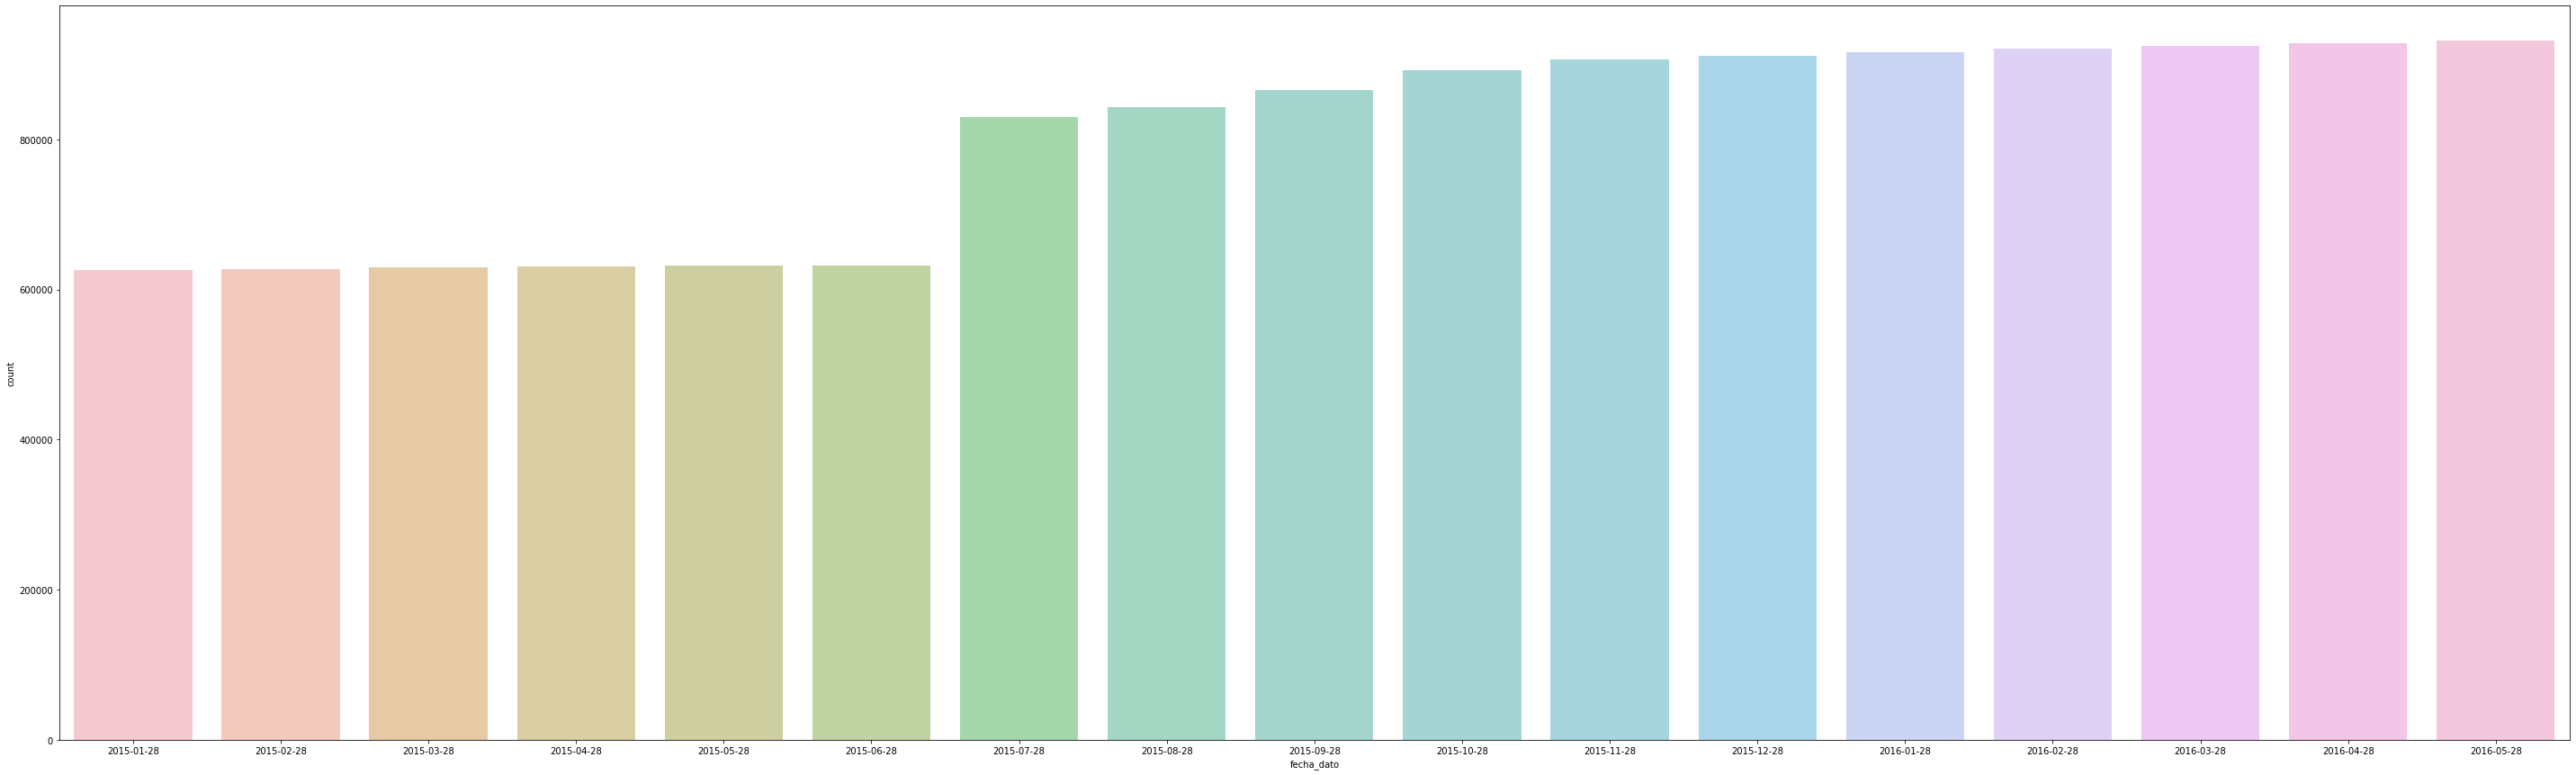

--------------------------------------------------
col:  ind_empleado


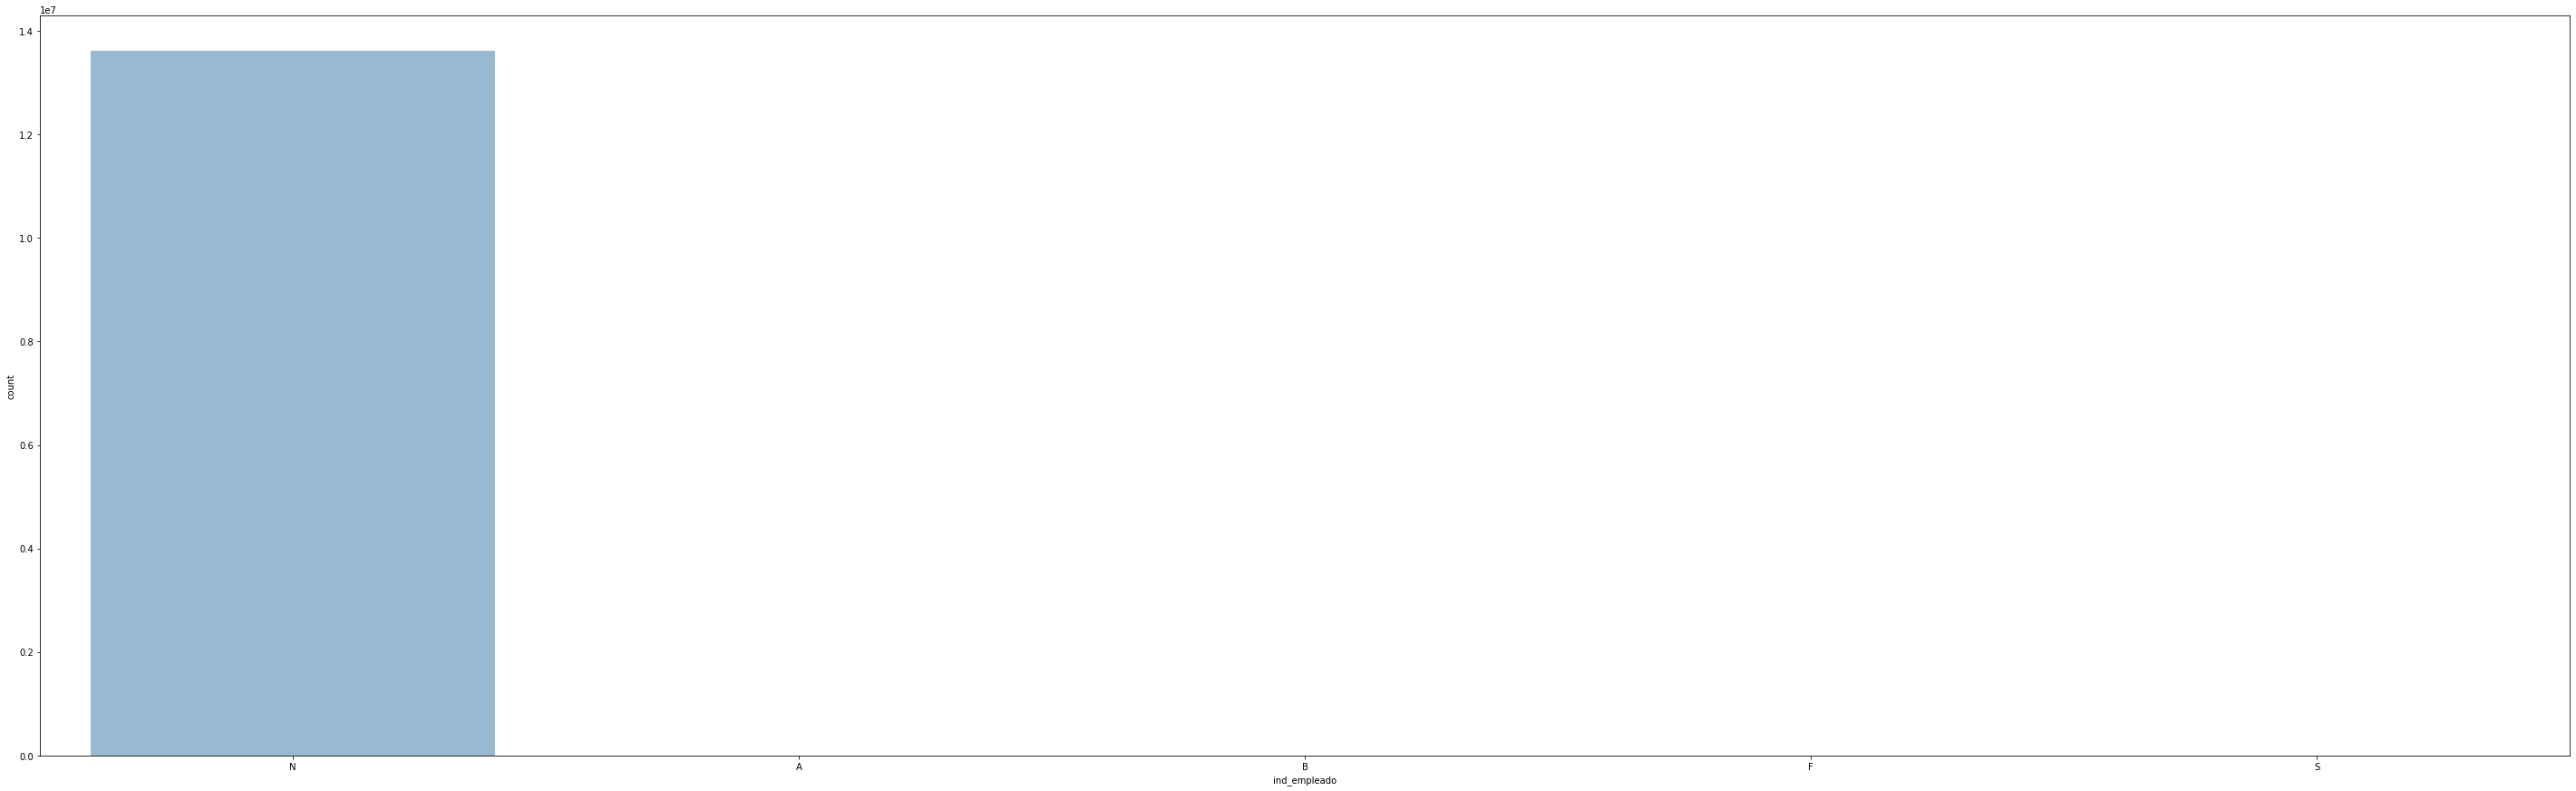

--------------------------------------------------
col:  pais_residencia


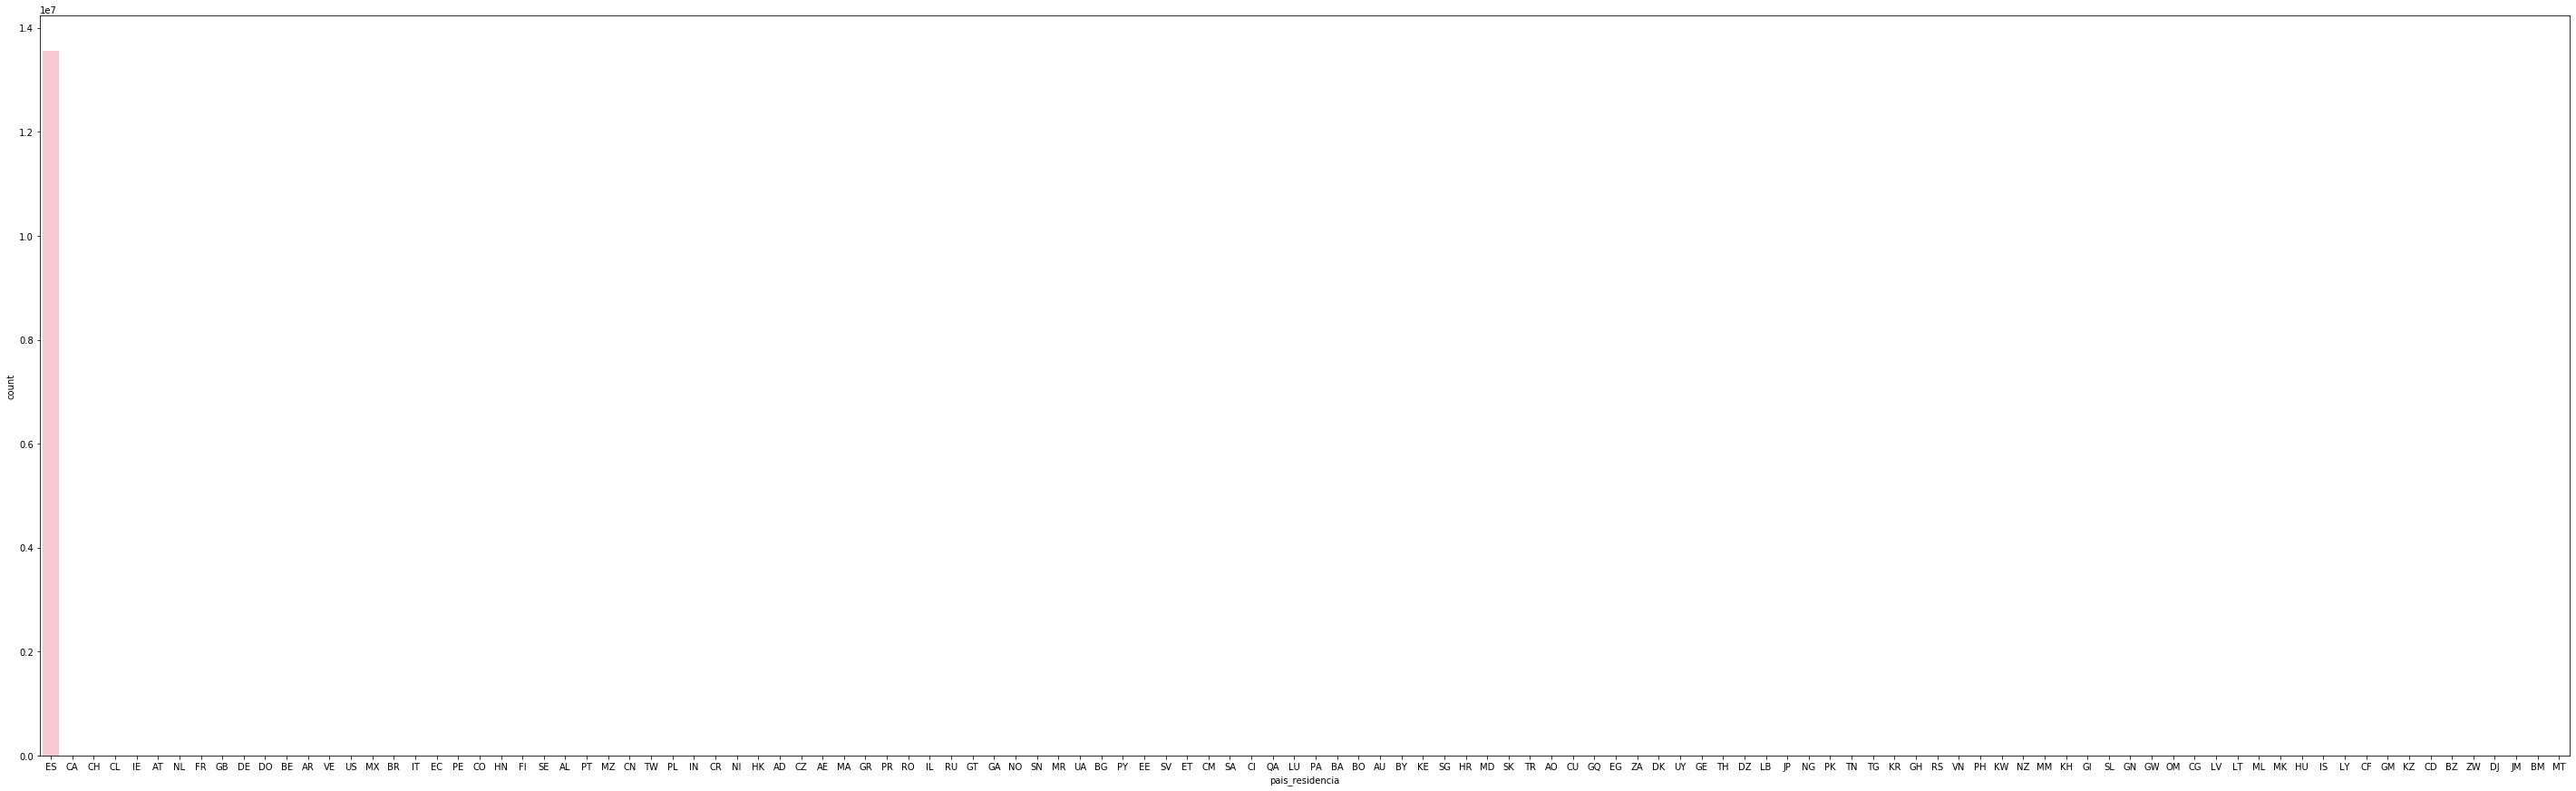

--------------------------------------------------
col:  sexo


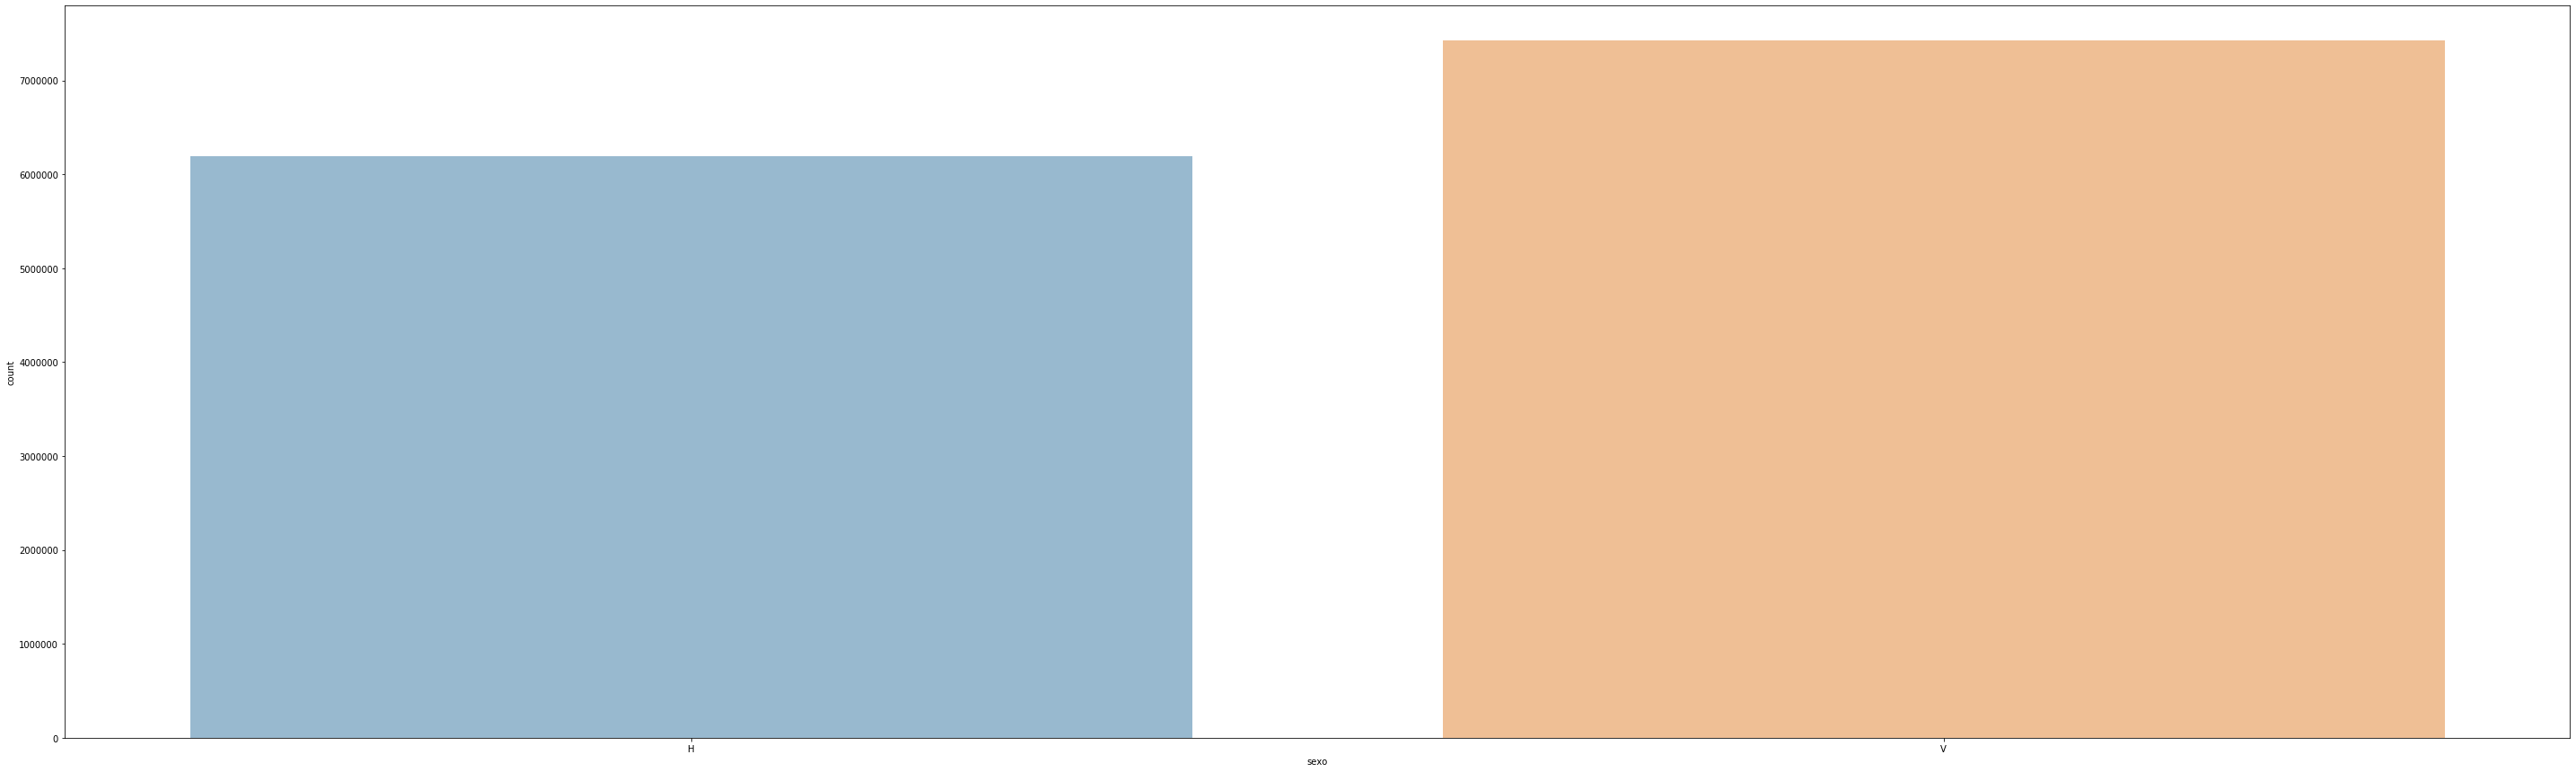

--------------------------------------------------
col:  age


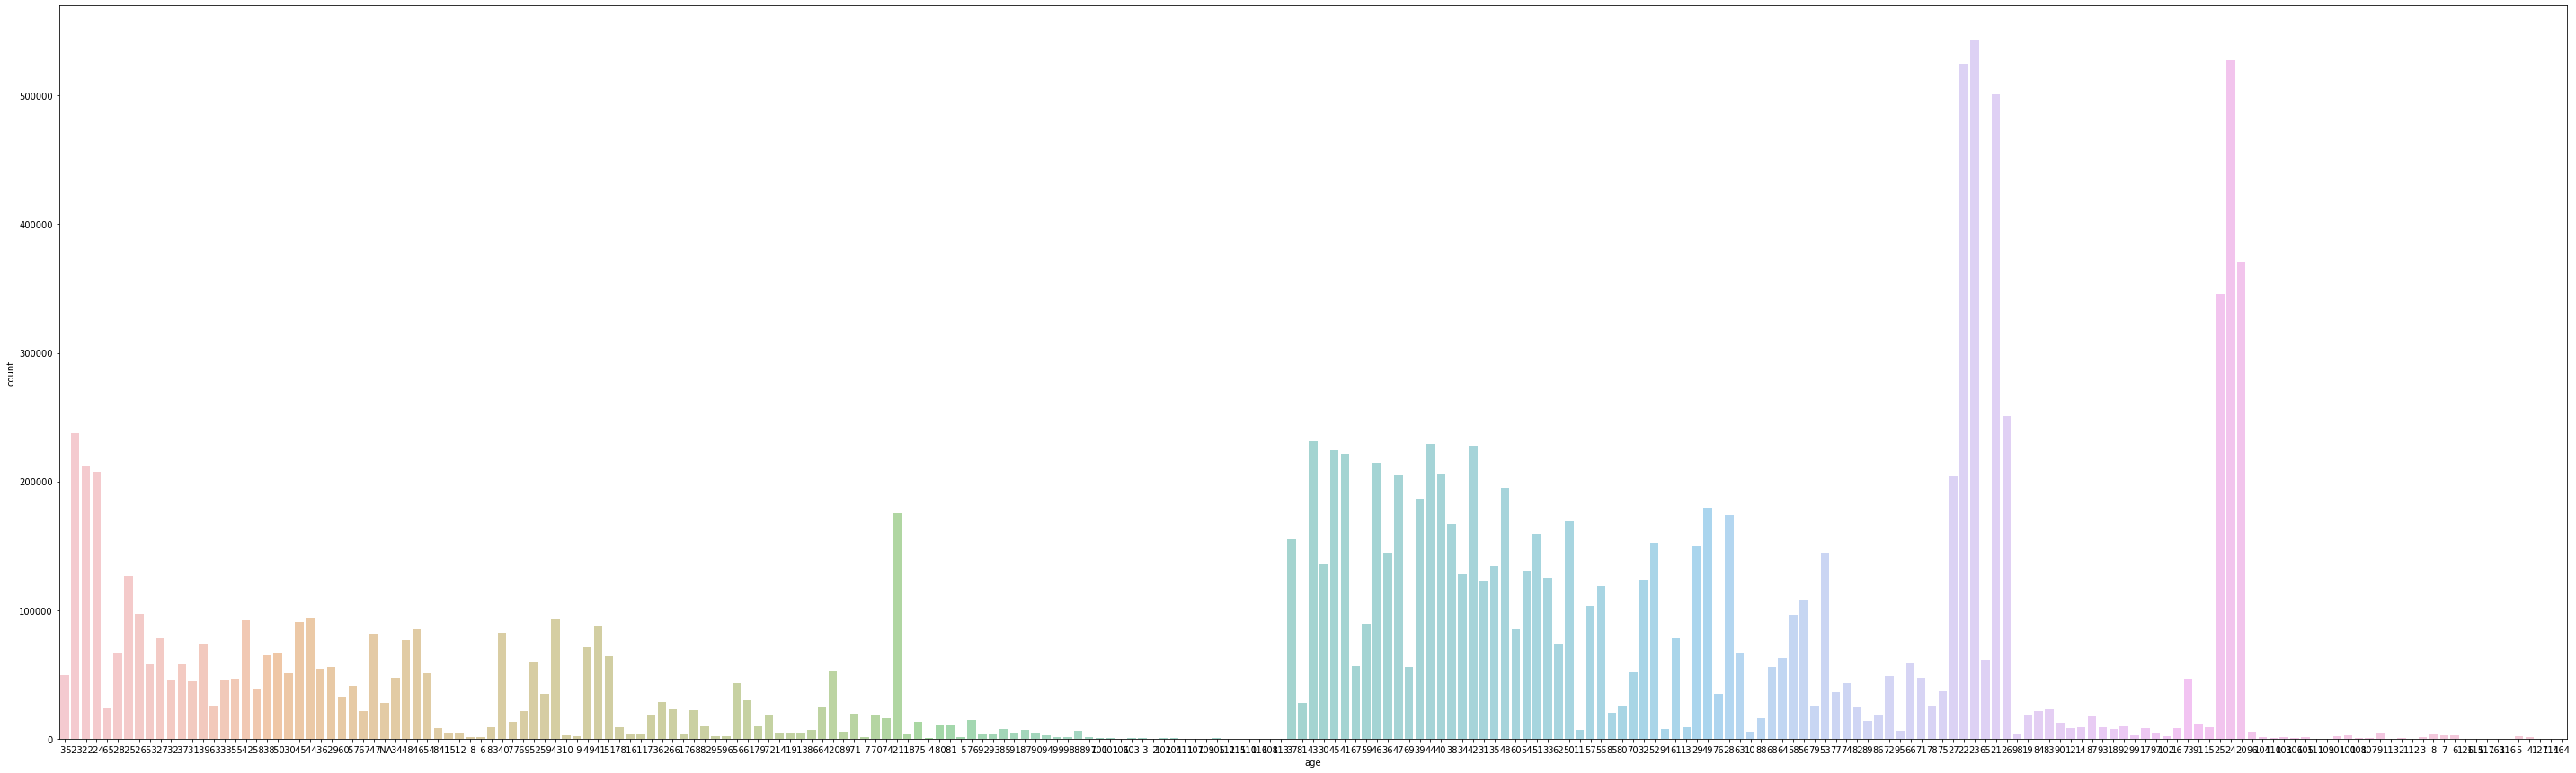

--------------------------------------------------
col:  fecha_alta


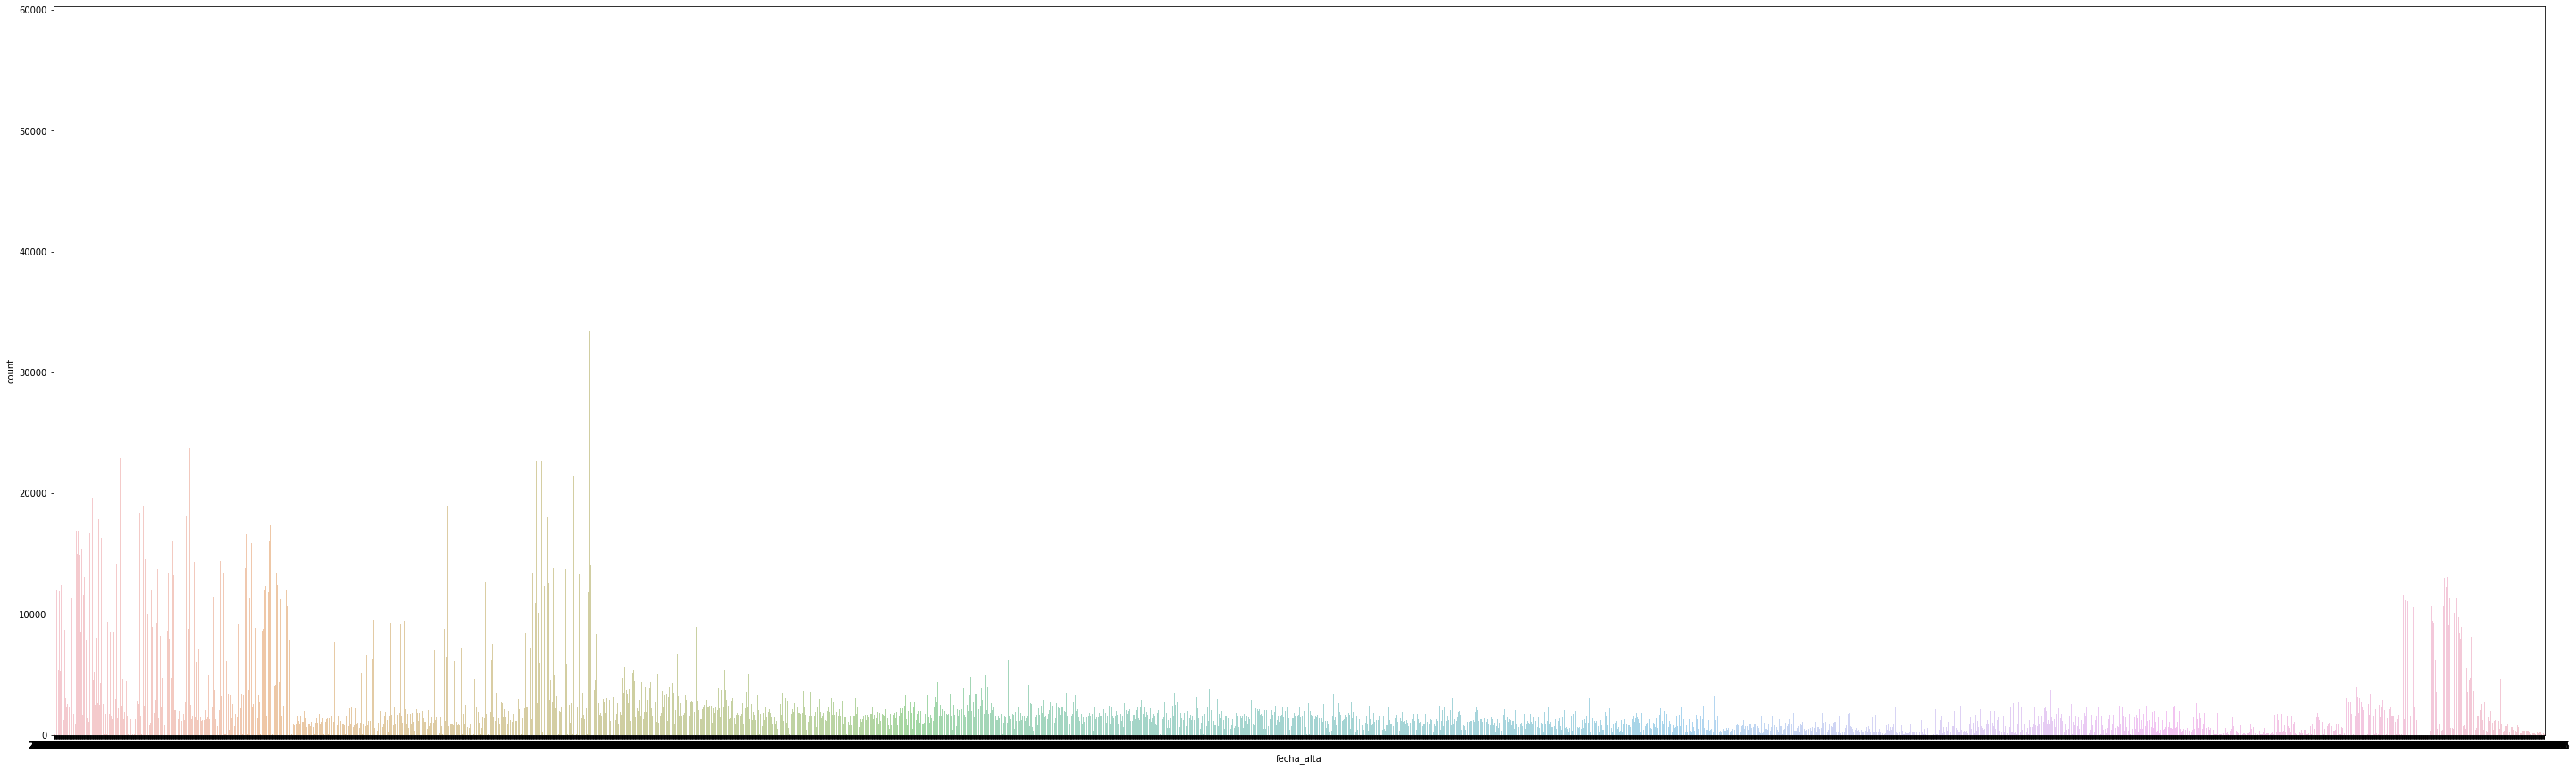

--------------------------------------------------
col:  ind_nuevo


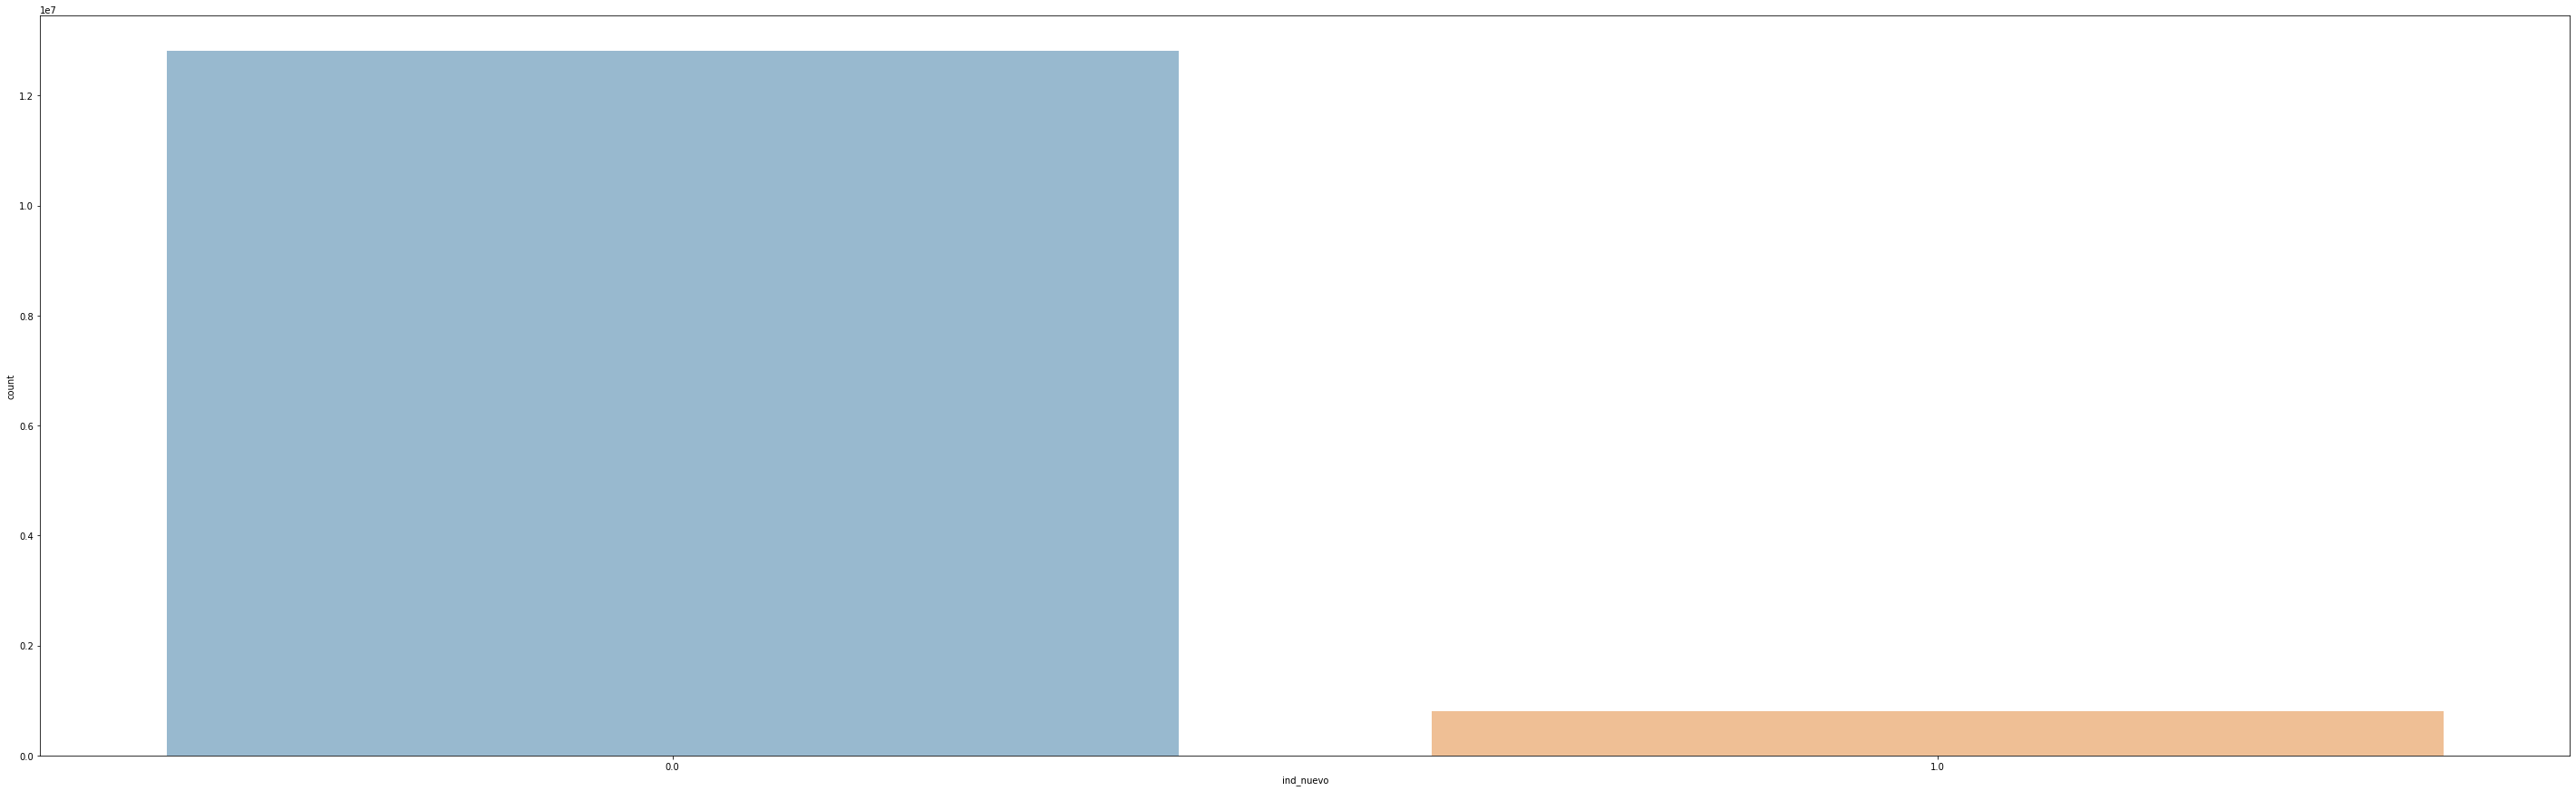

--------------------------------------------------
col:  antiguedad


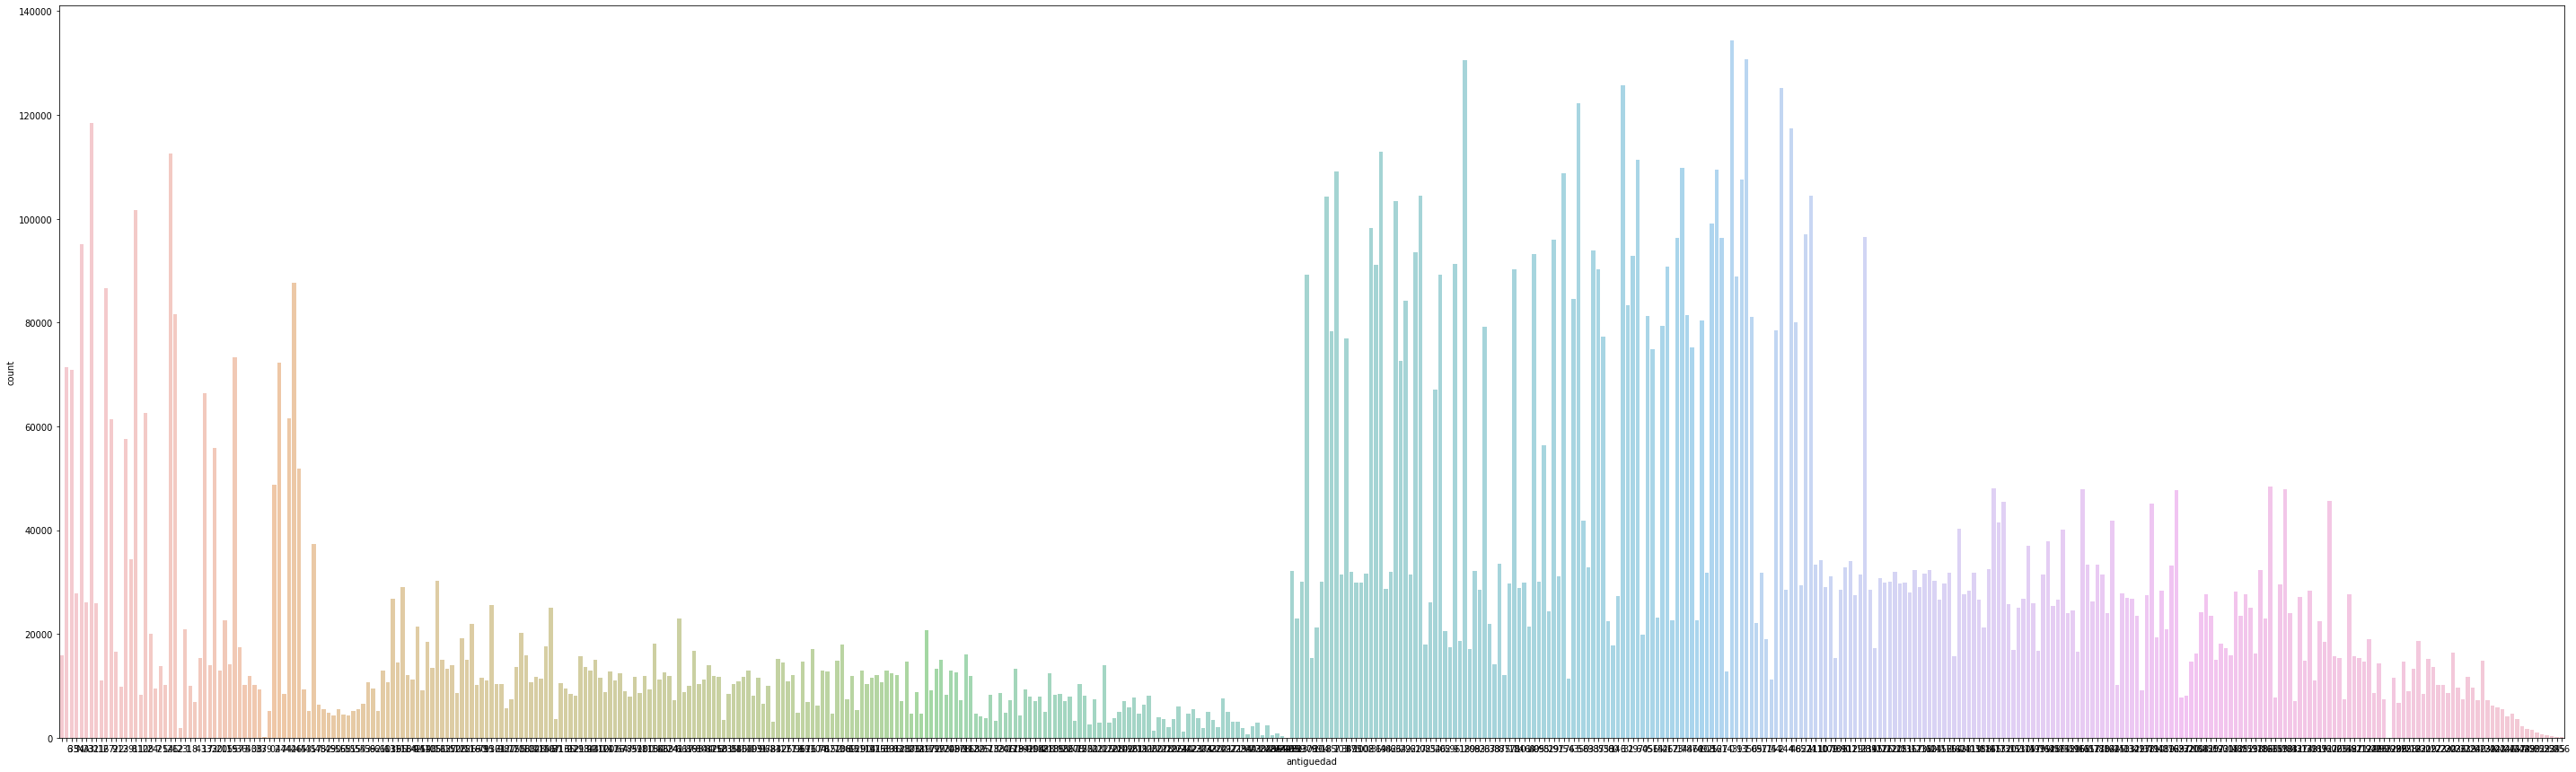

--------------------------------------------------
col:  indrel


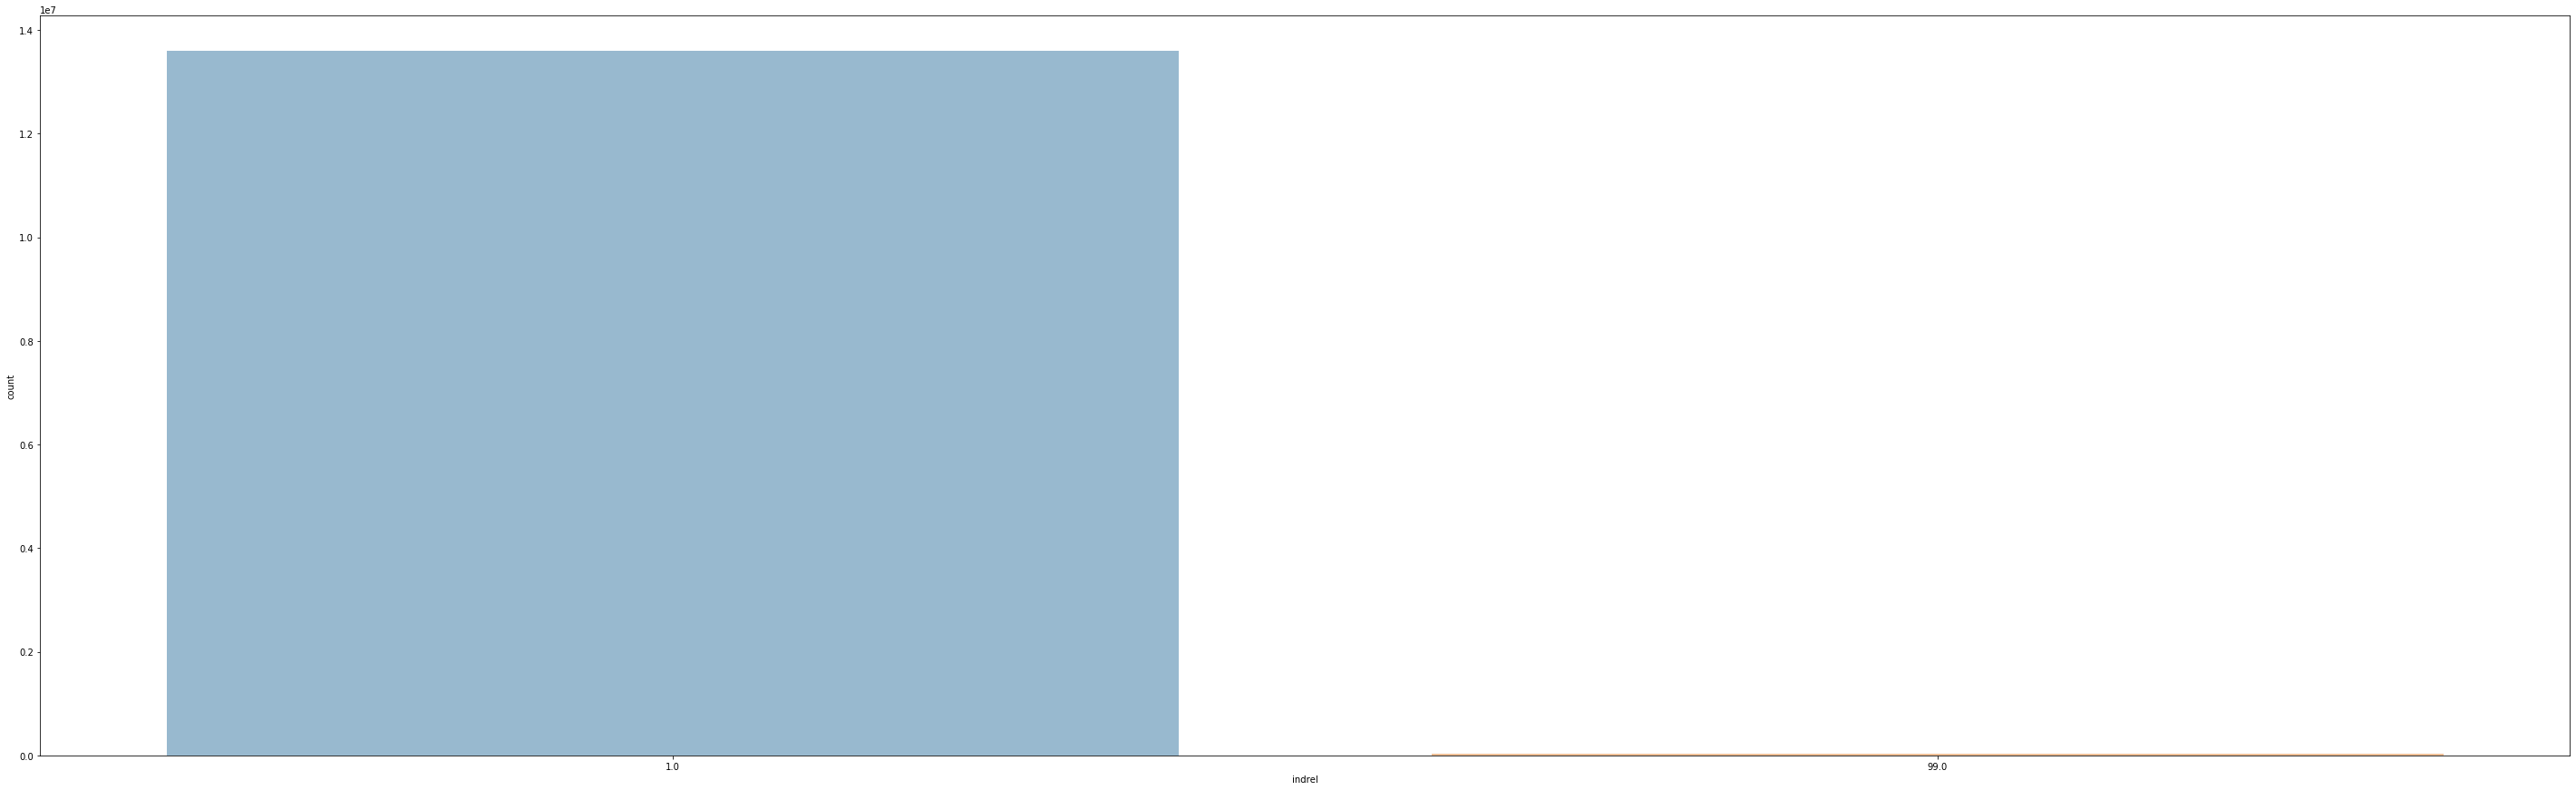

--------------------------------------------------
col:  ult_fec_cli_1t


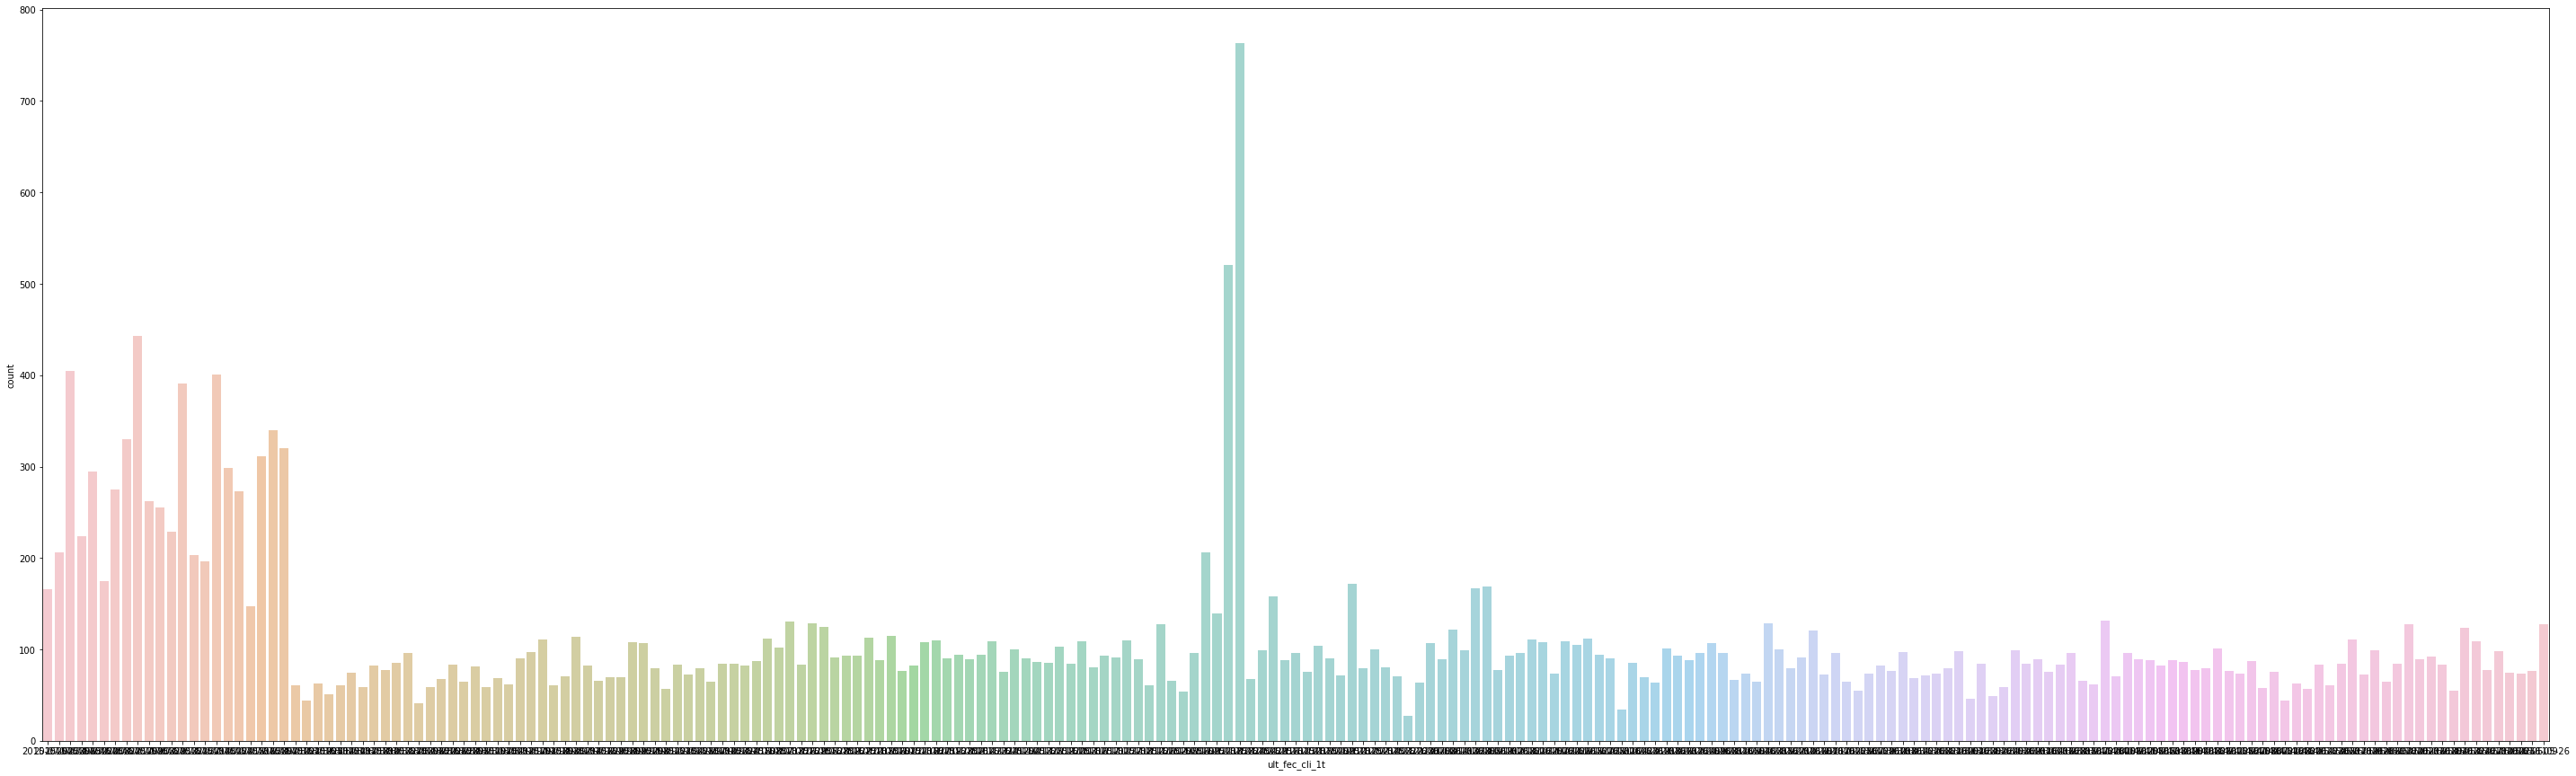

--------------------------------------------------
col:  indrel_1mes


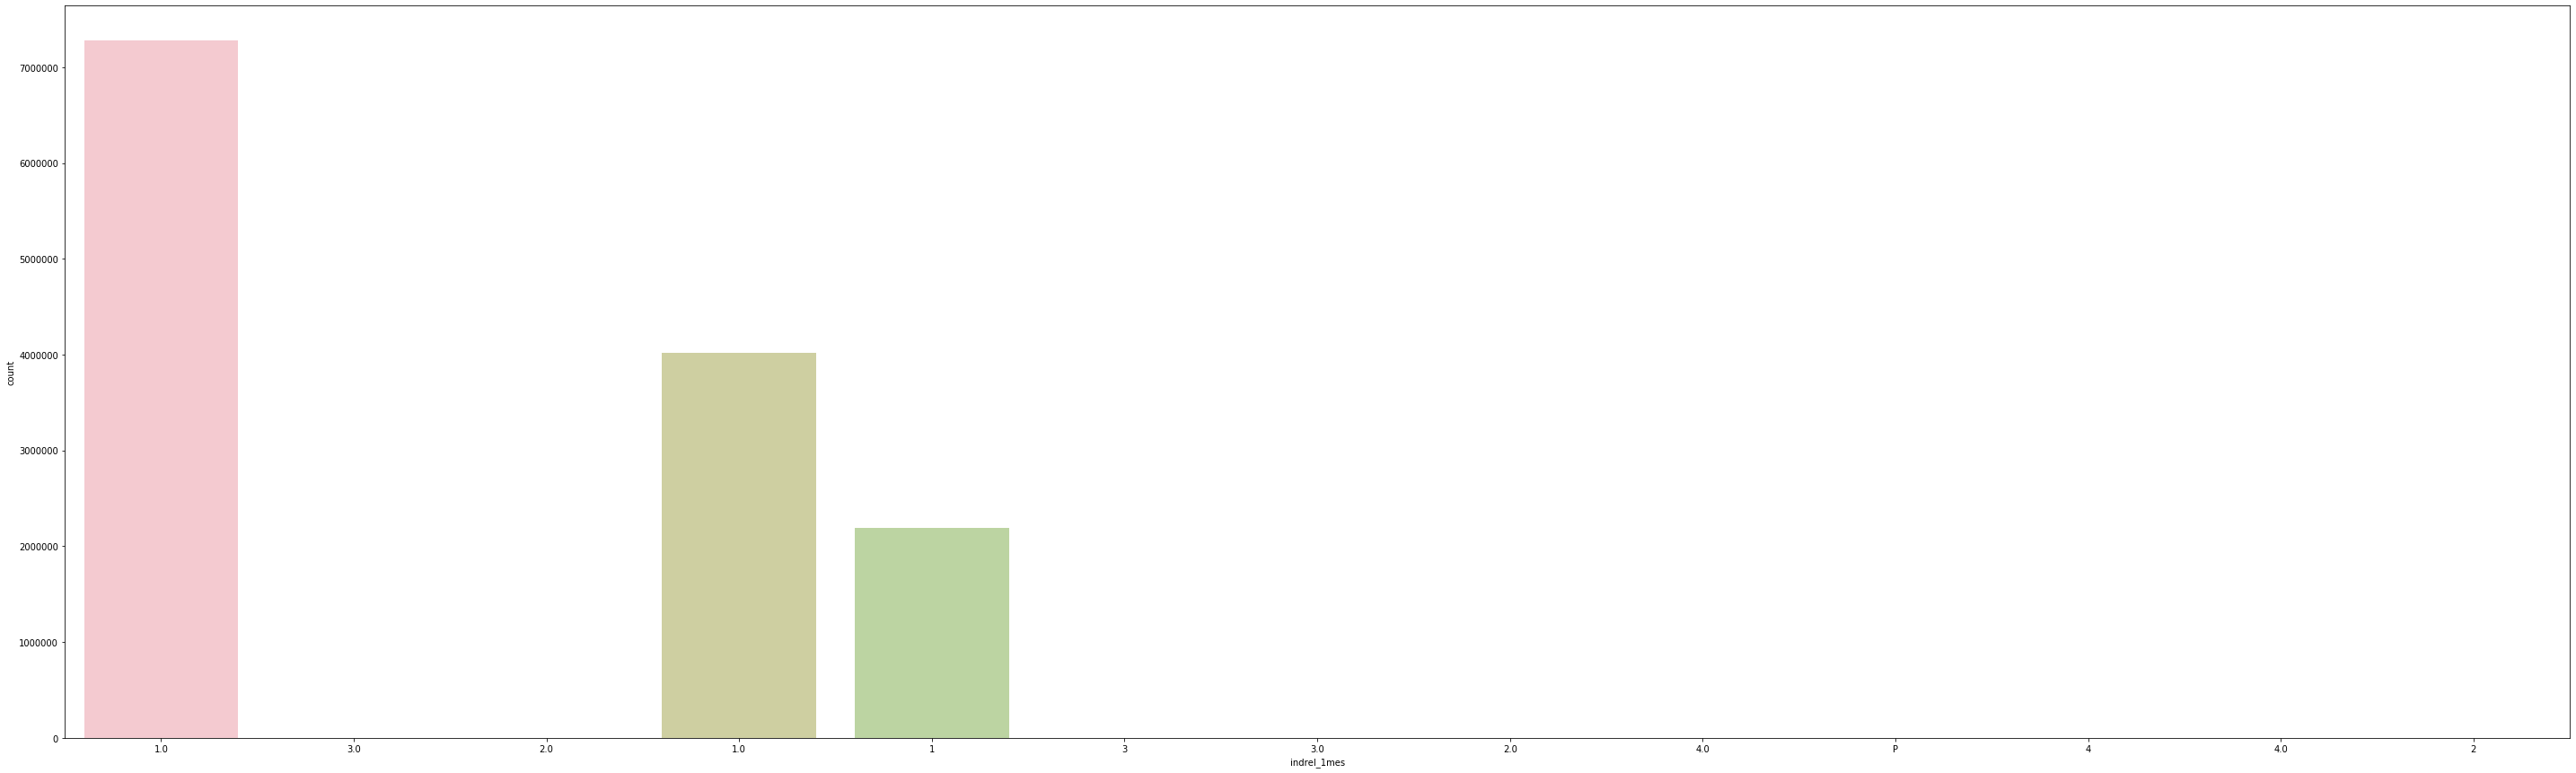

--------------------------------------------------
col:  tiprel_1mes


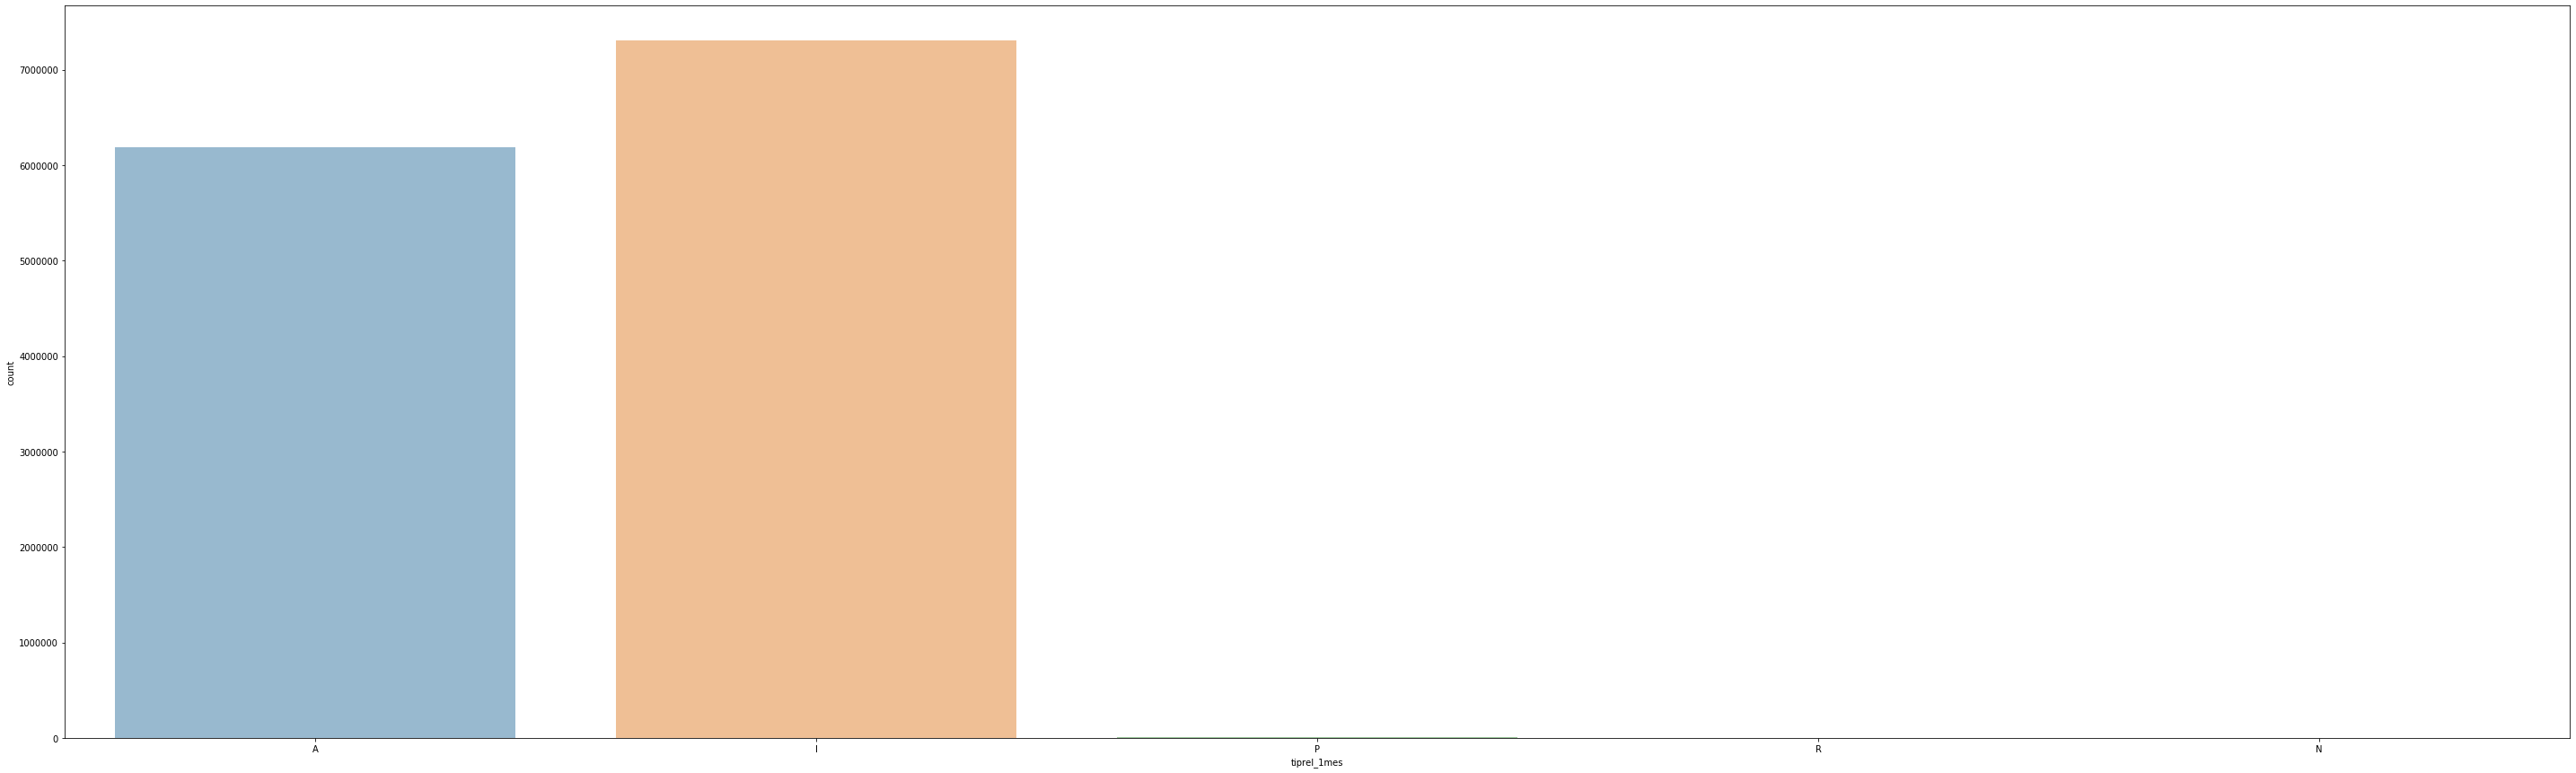

--------------------------------------------------
col:  indresi


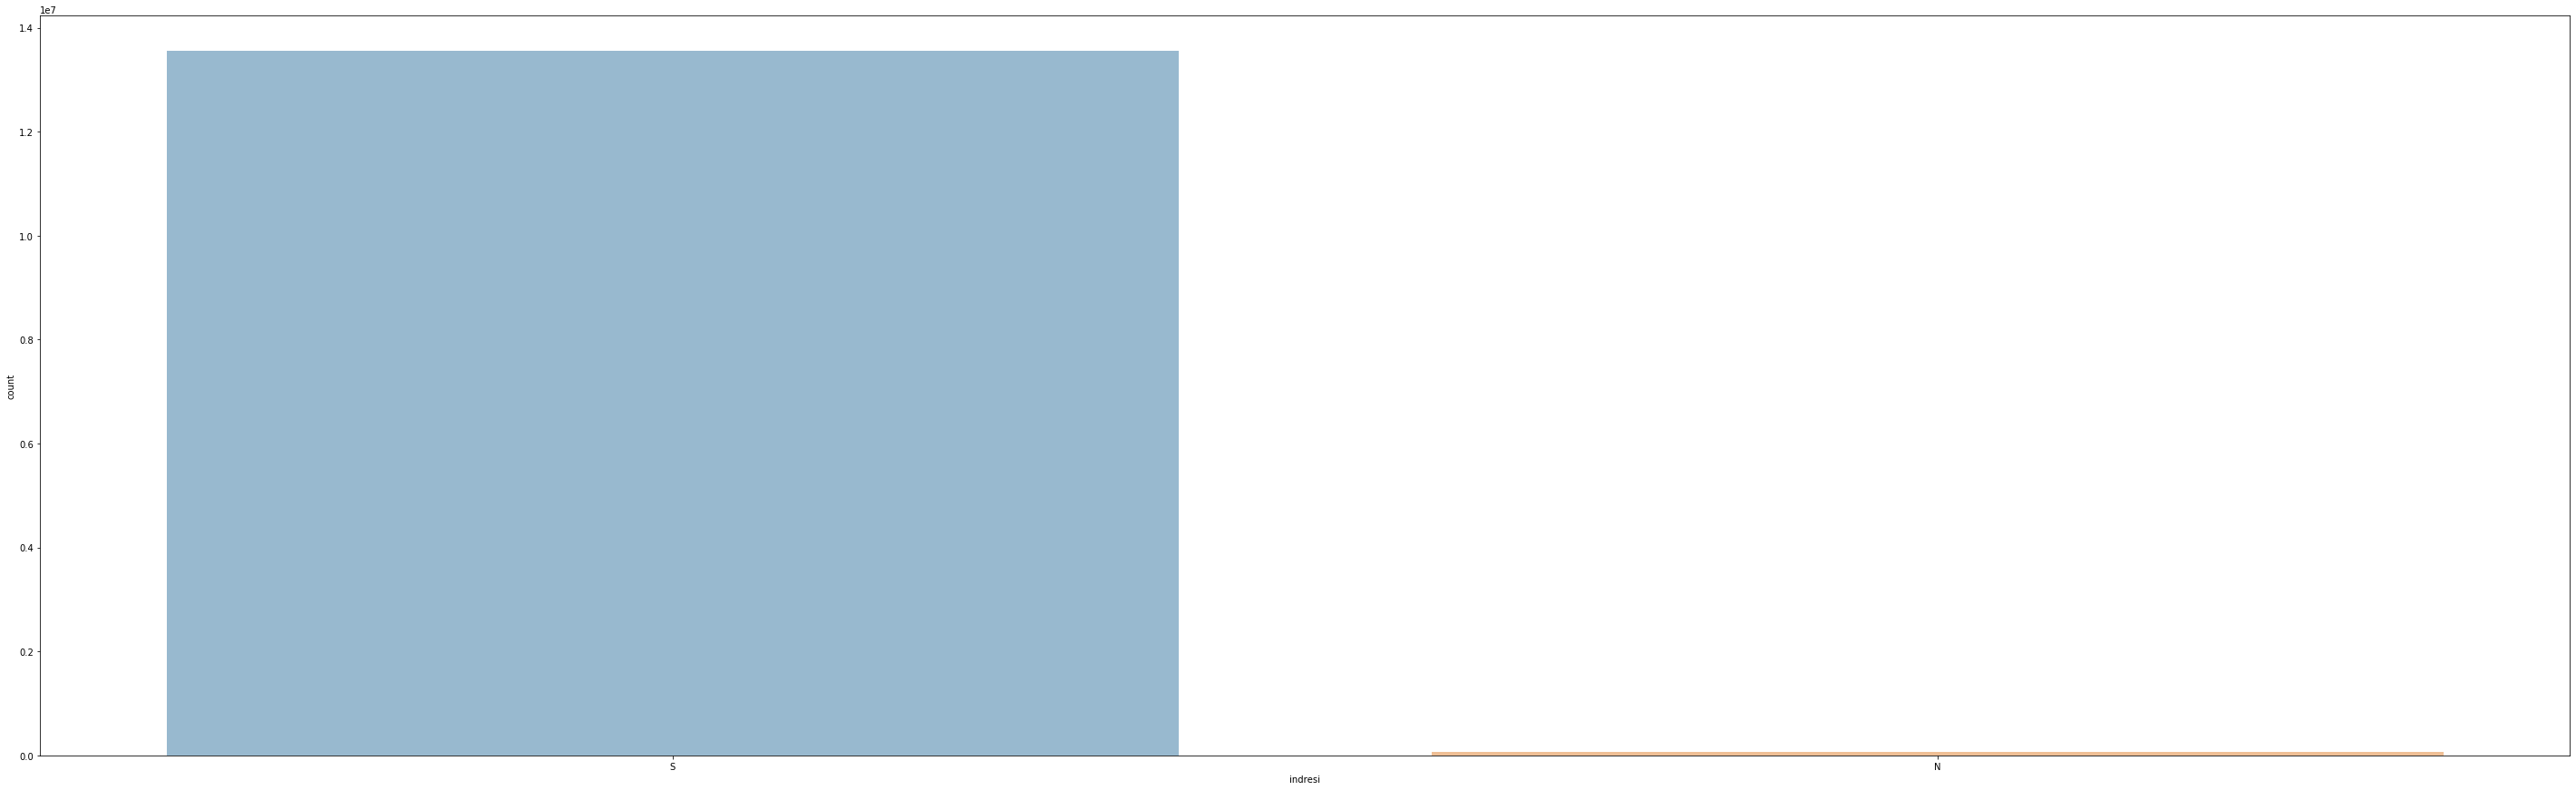

--------------------------------------------------
col:  indext


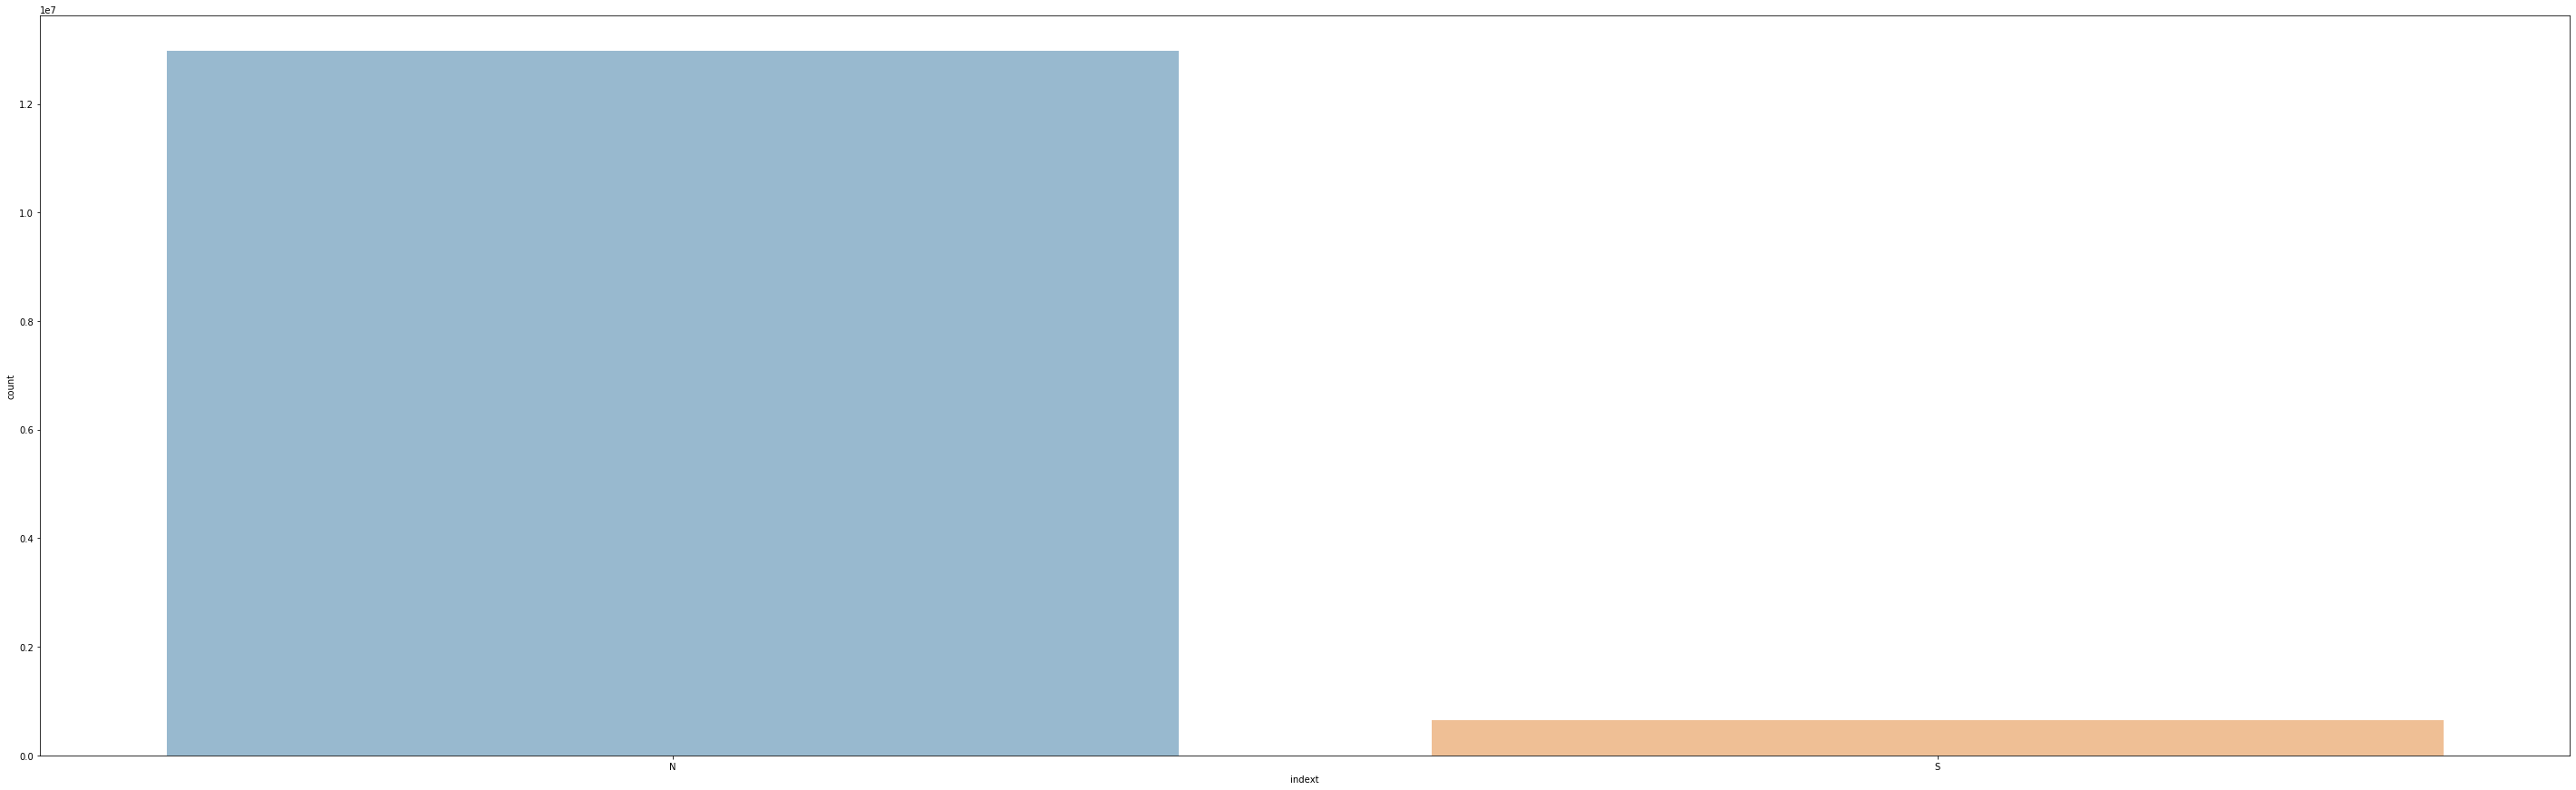

--------------------------------------------------
col:  conyuemp


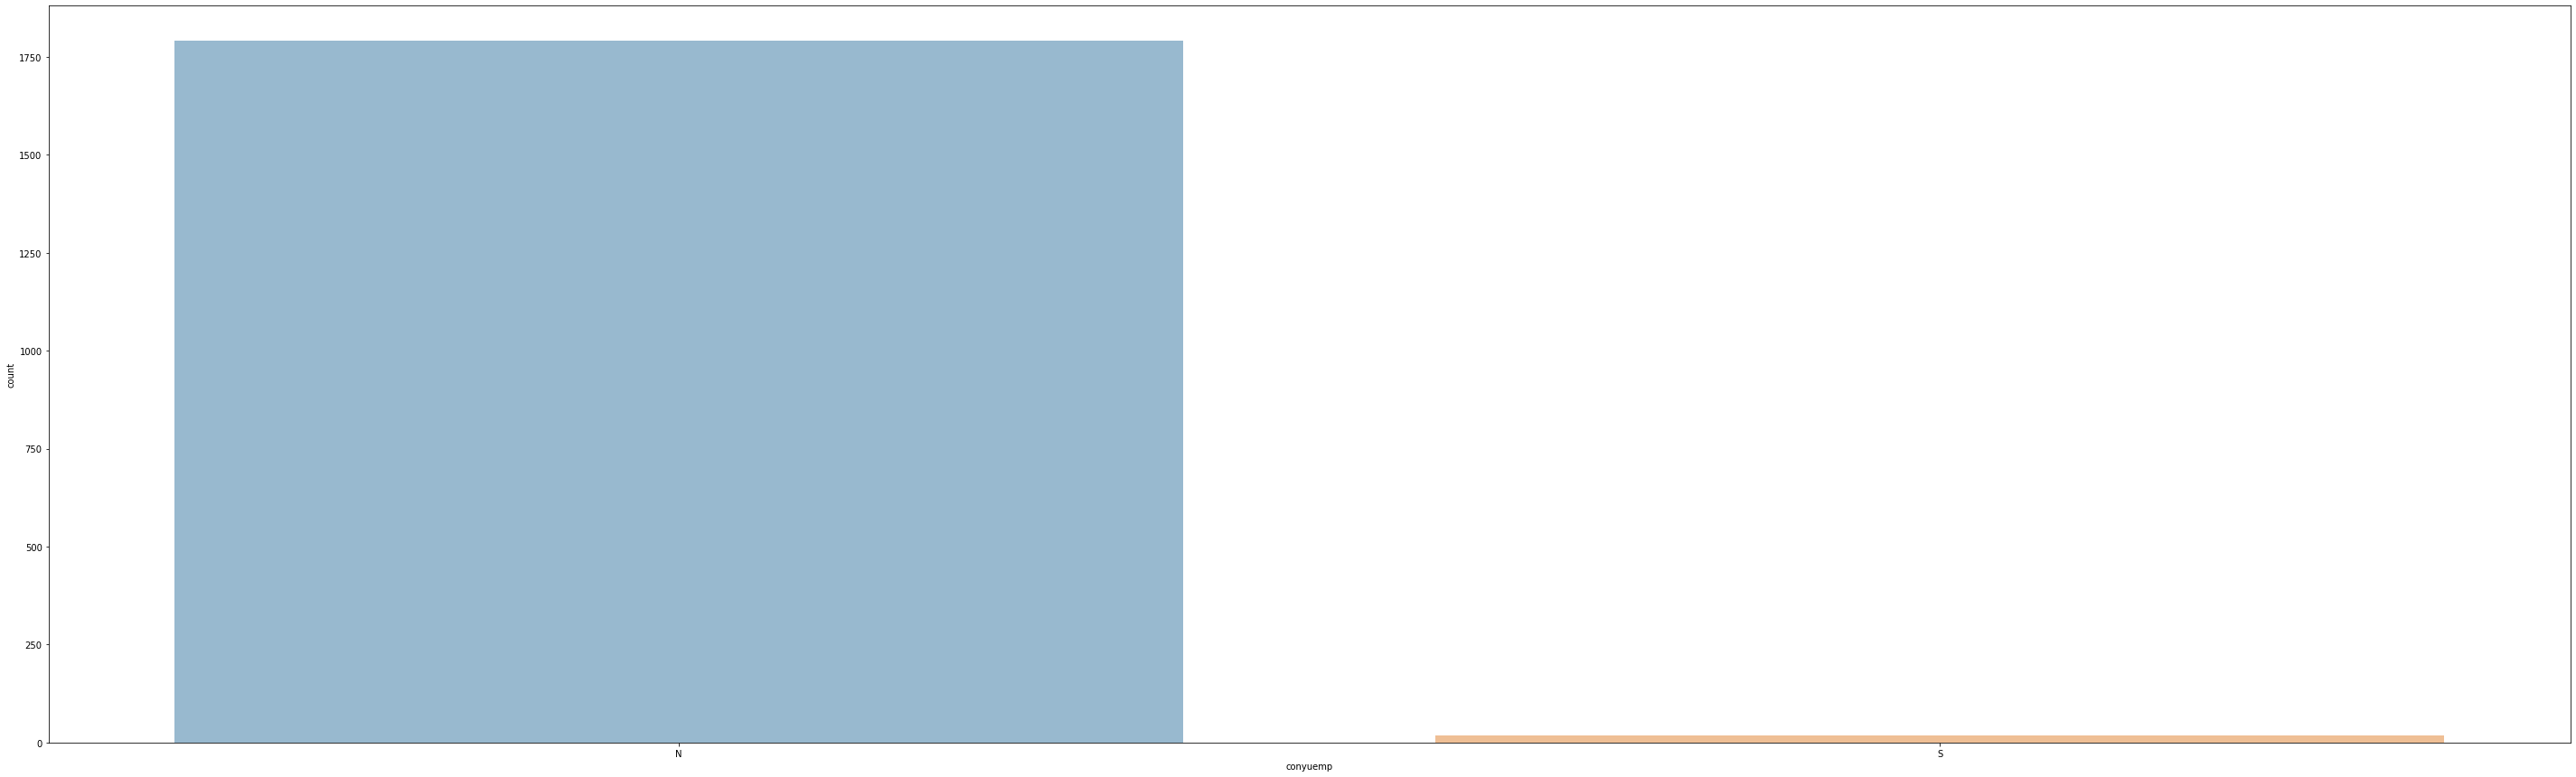

--------------------------------------------------
col:  canal_entrada


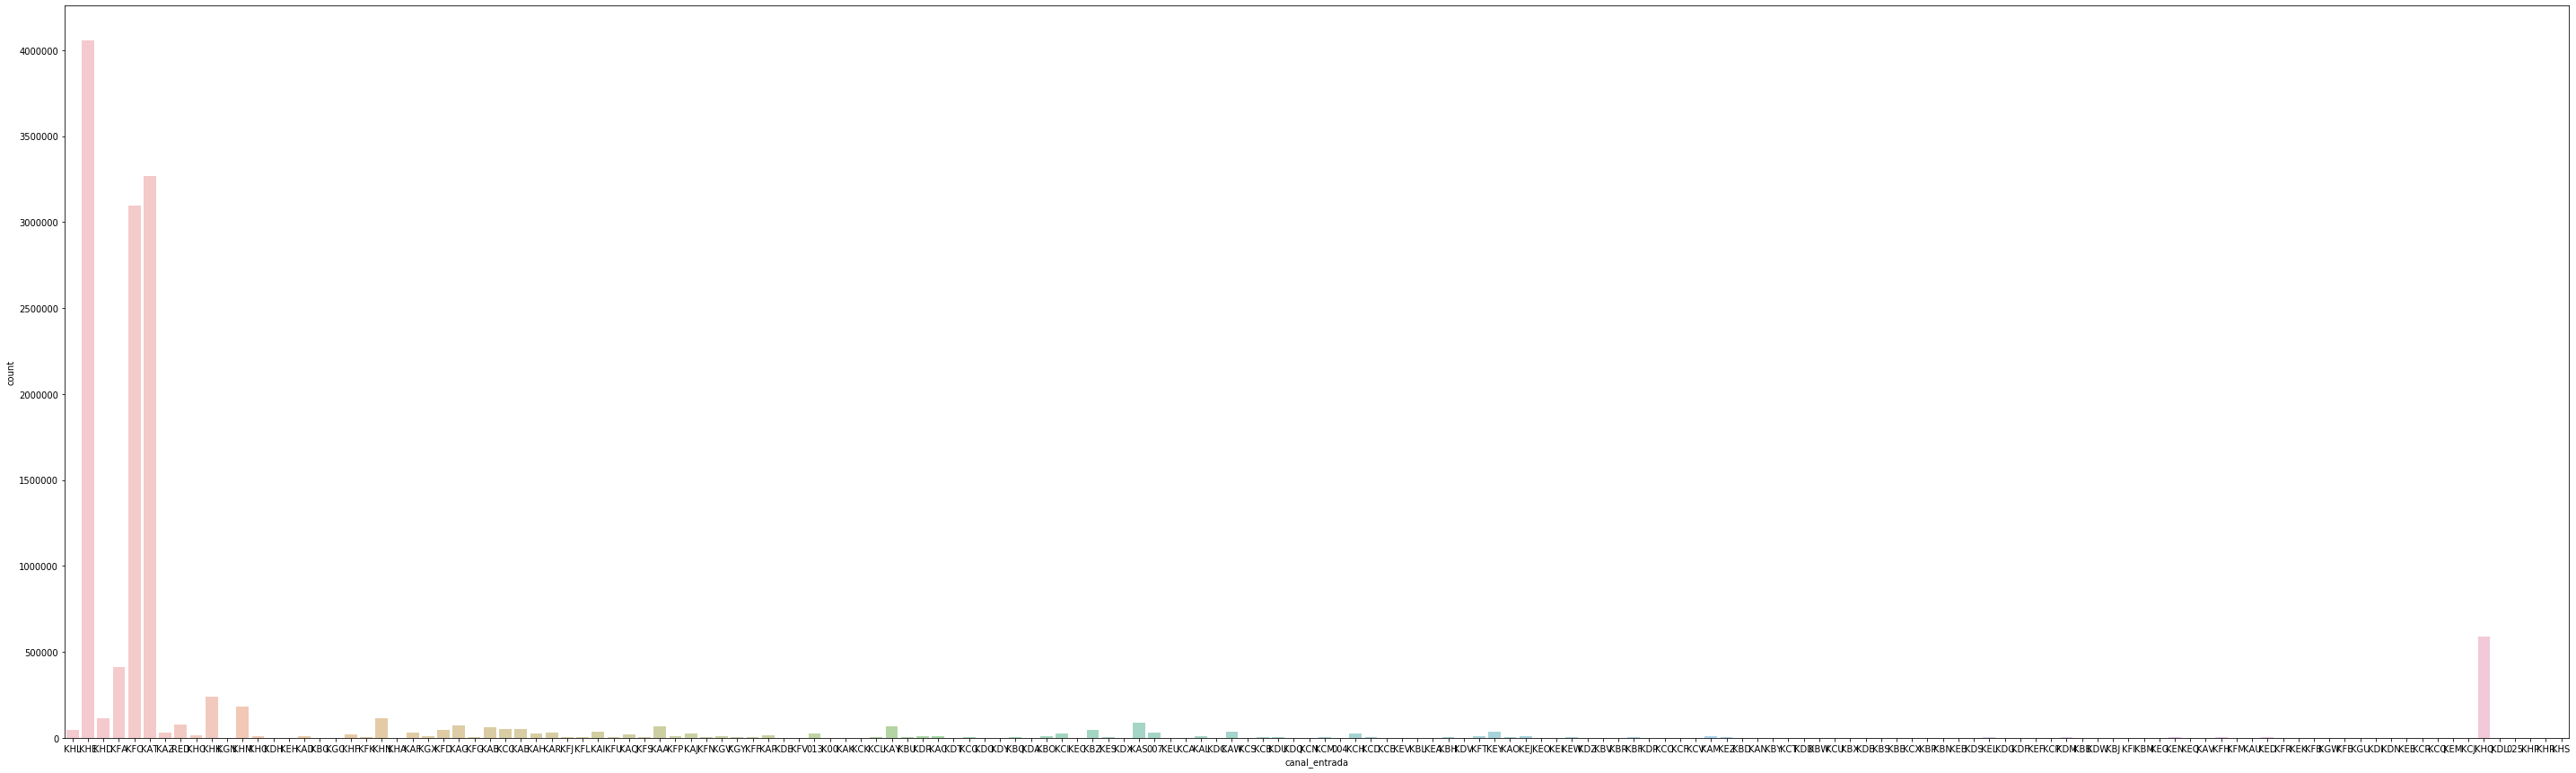

--------------------------------------------------
col:  indfall


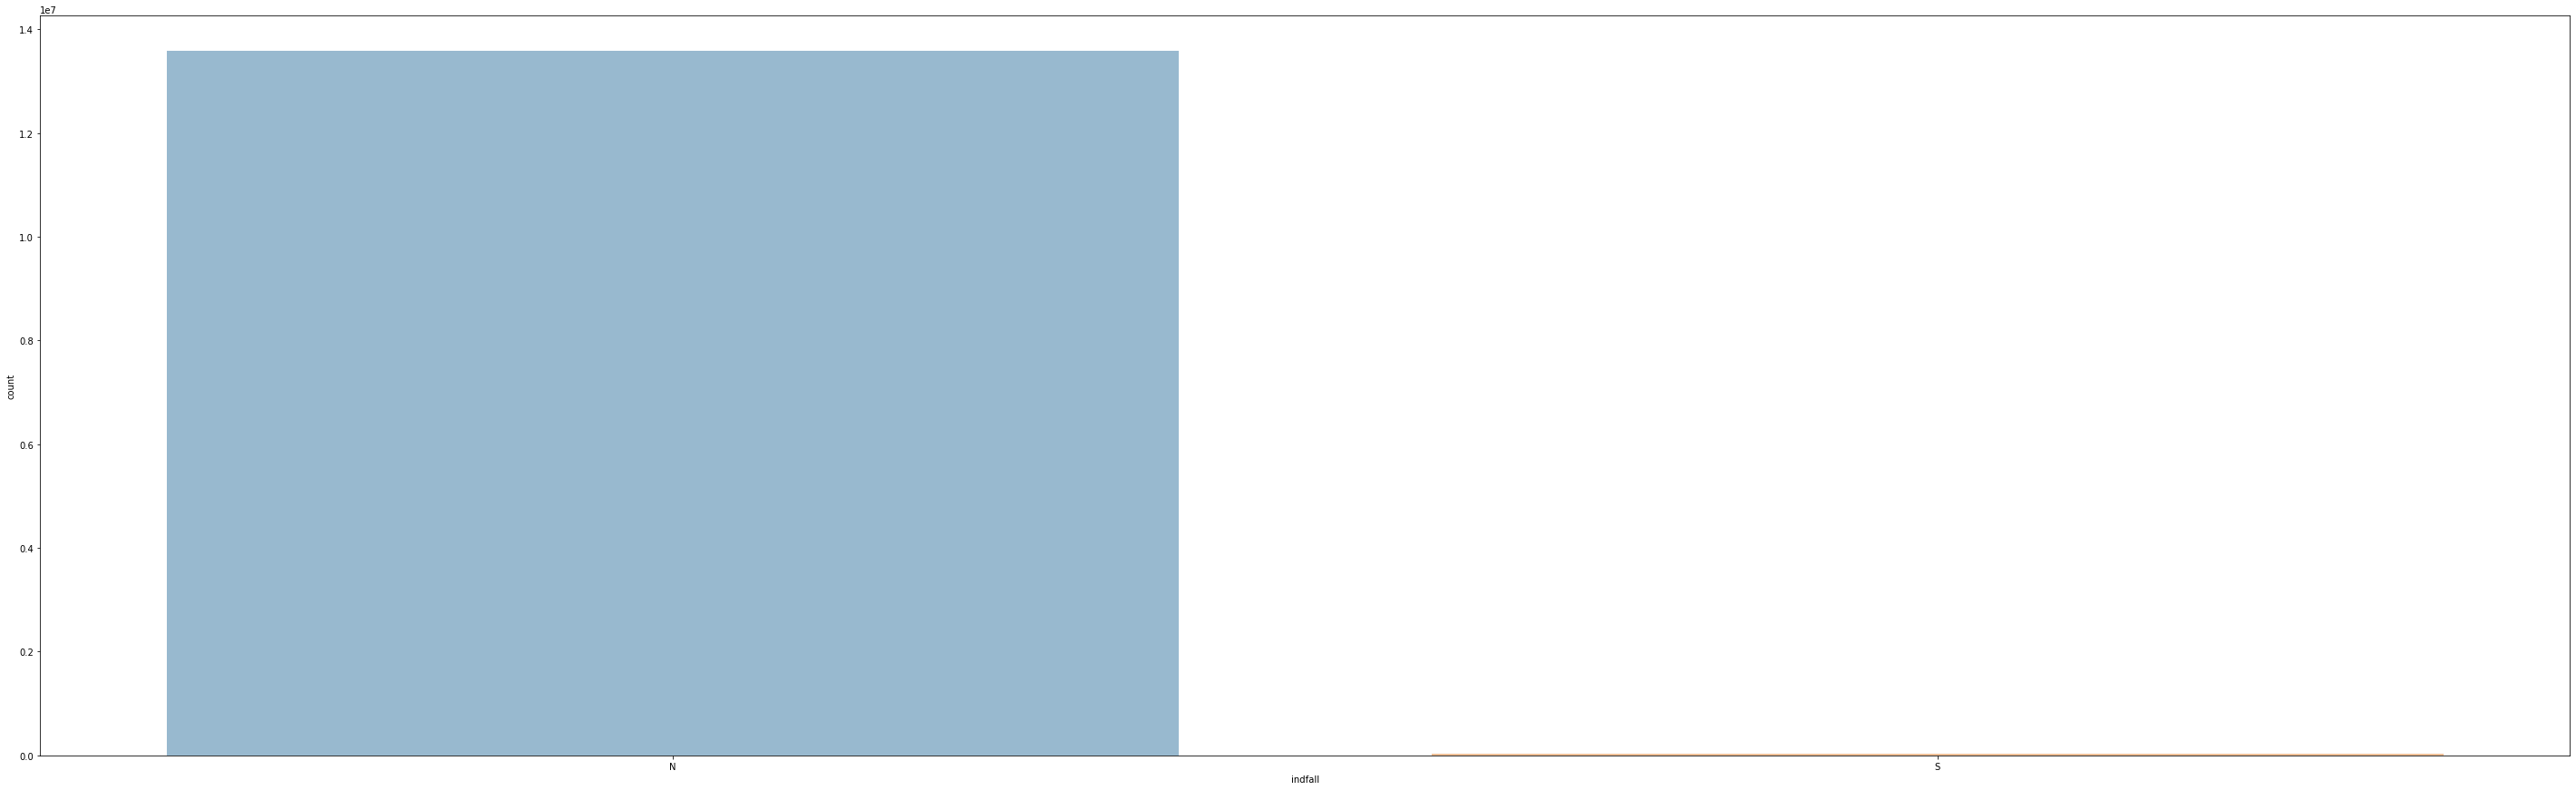

--------------------------------------------------
col:  tipodom


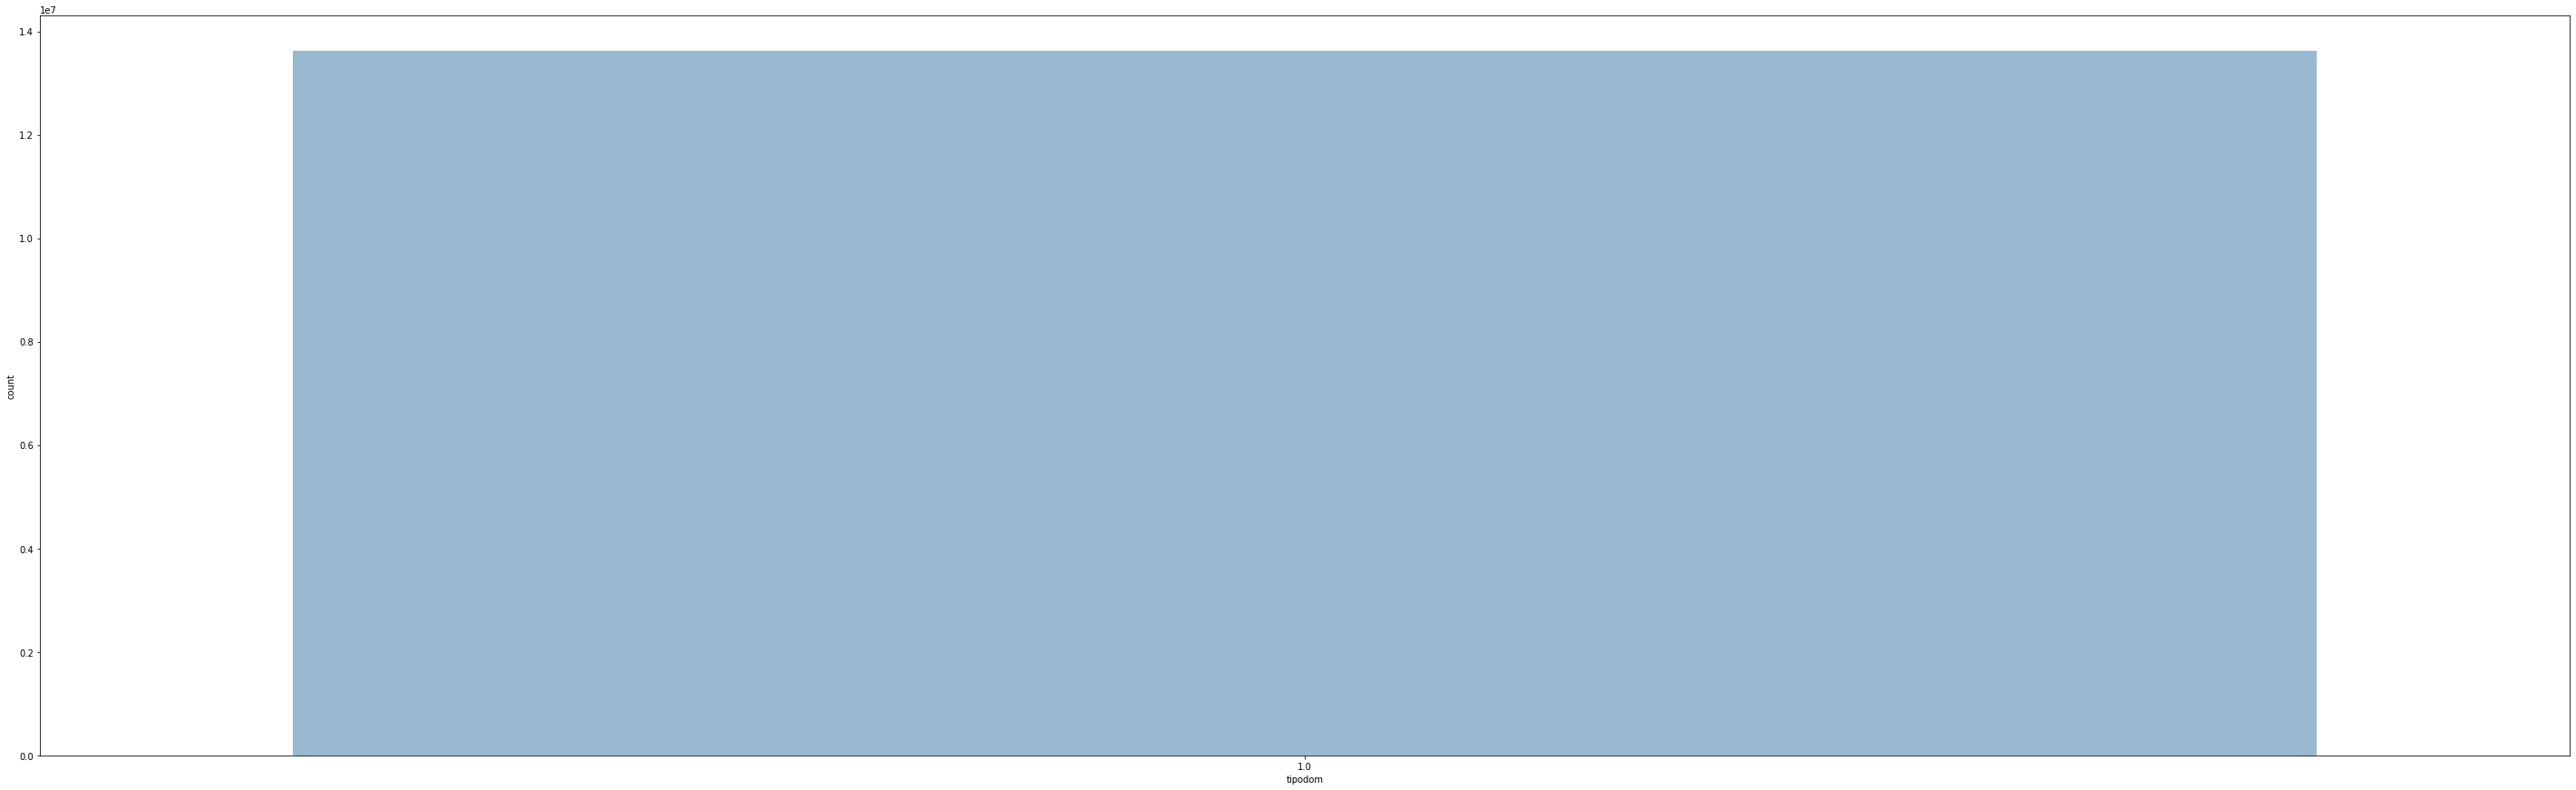

--------------------------------------------------
col:  cod_prov


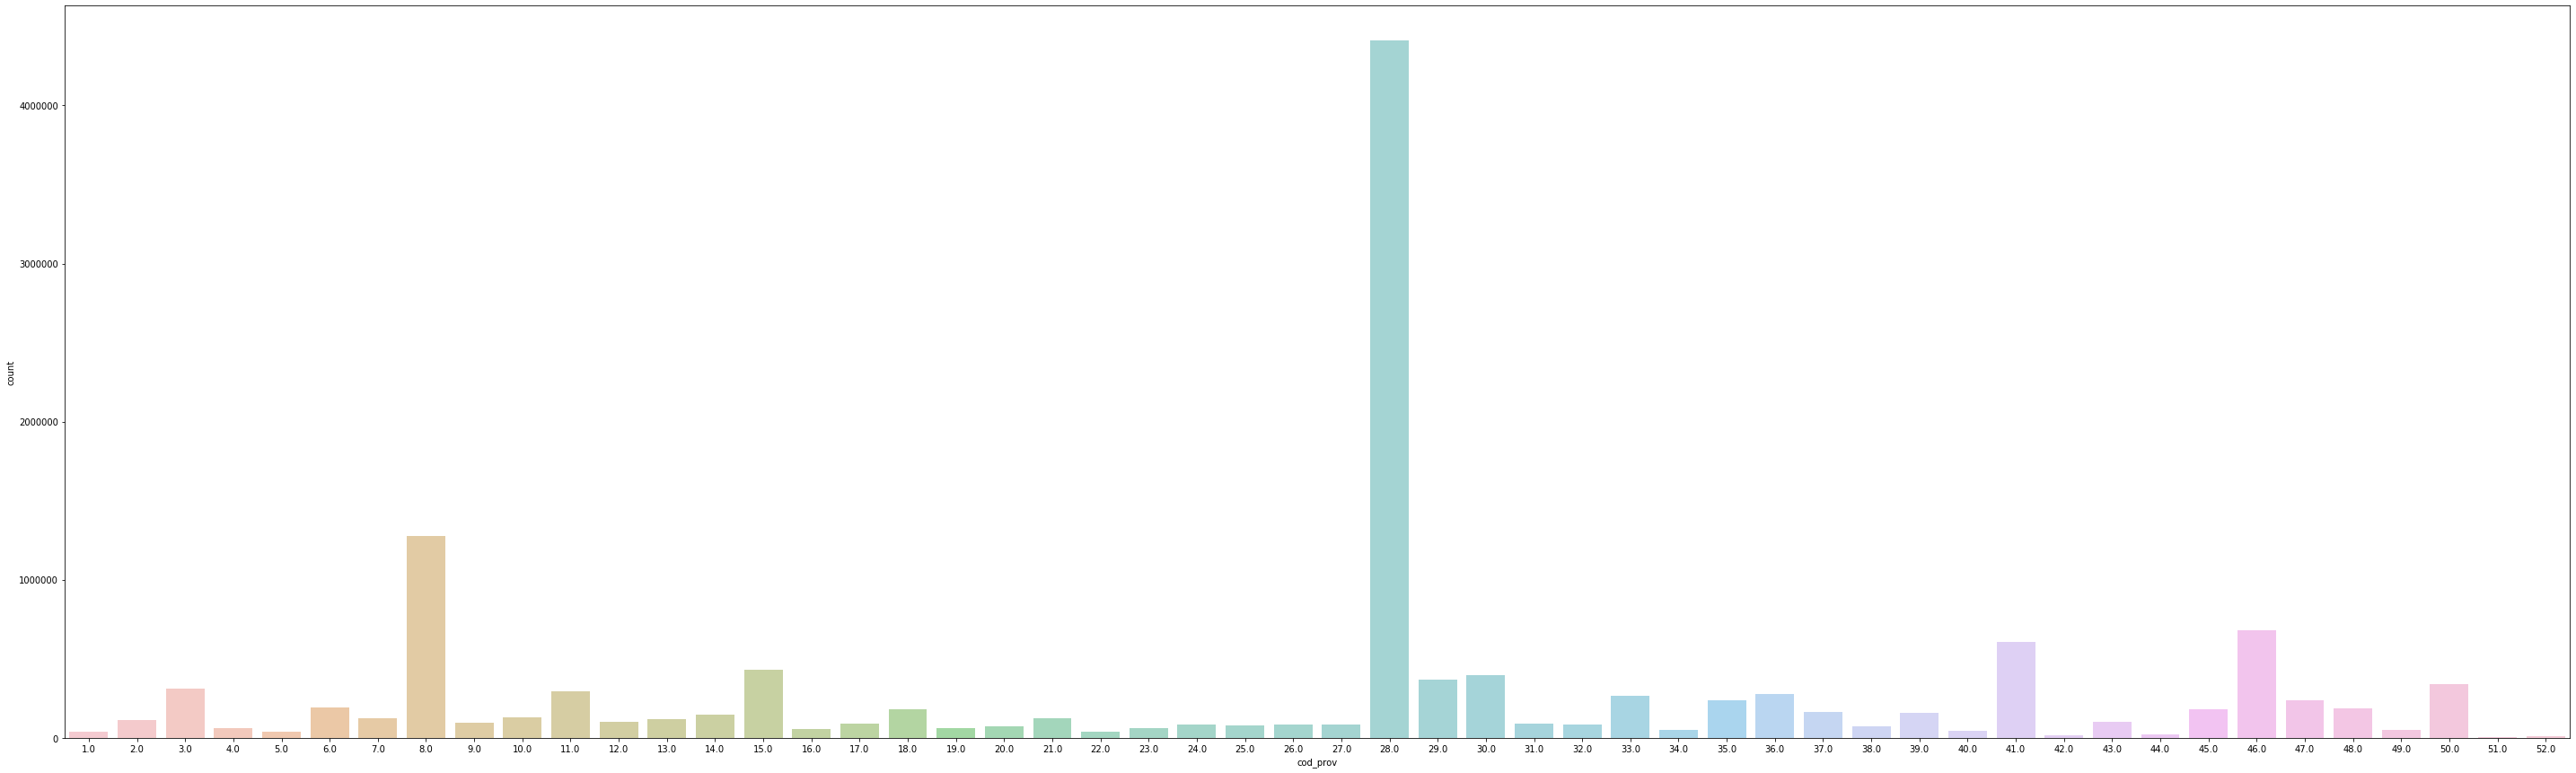

--------------------------------------------------
col:  nomprov


/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 54935 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 54935 missing from current font.
  font.set_text(s, 0, flags=flags)


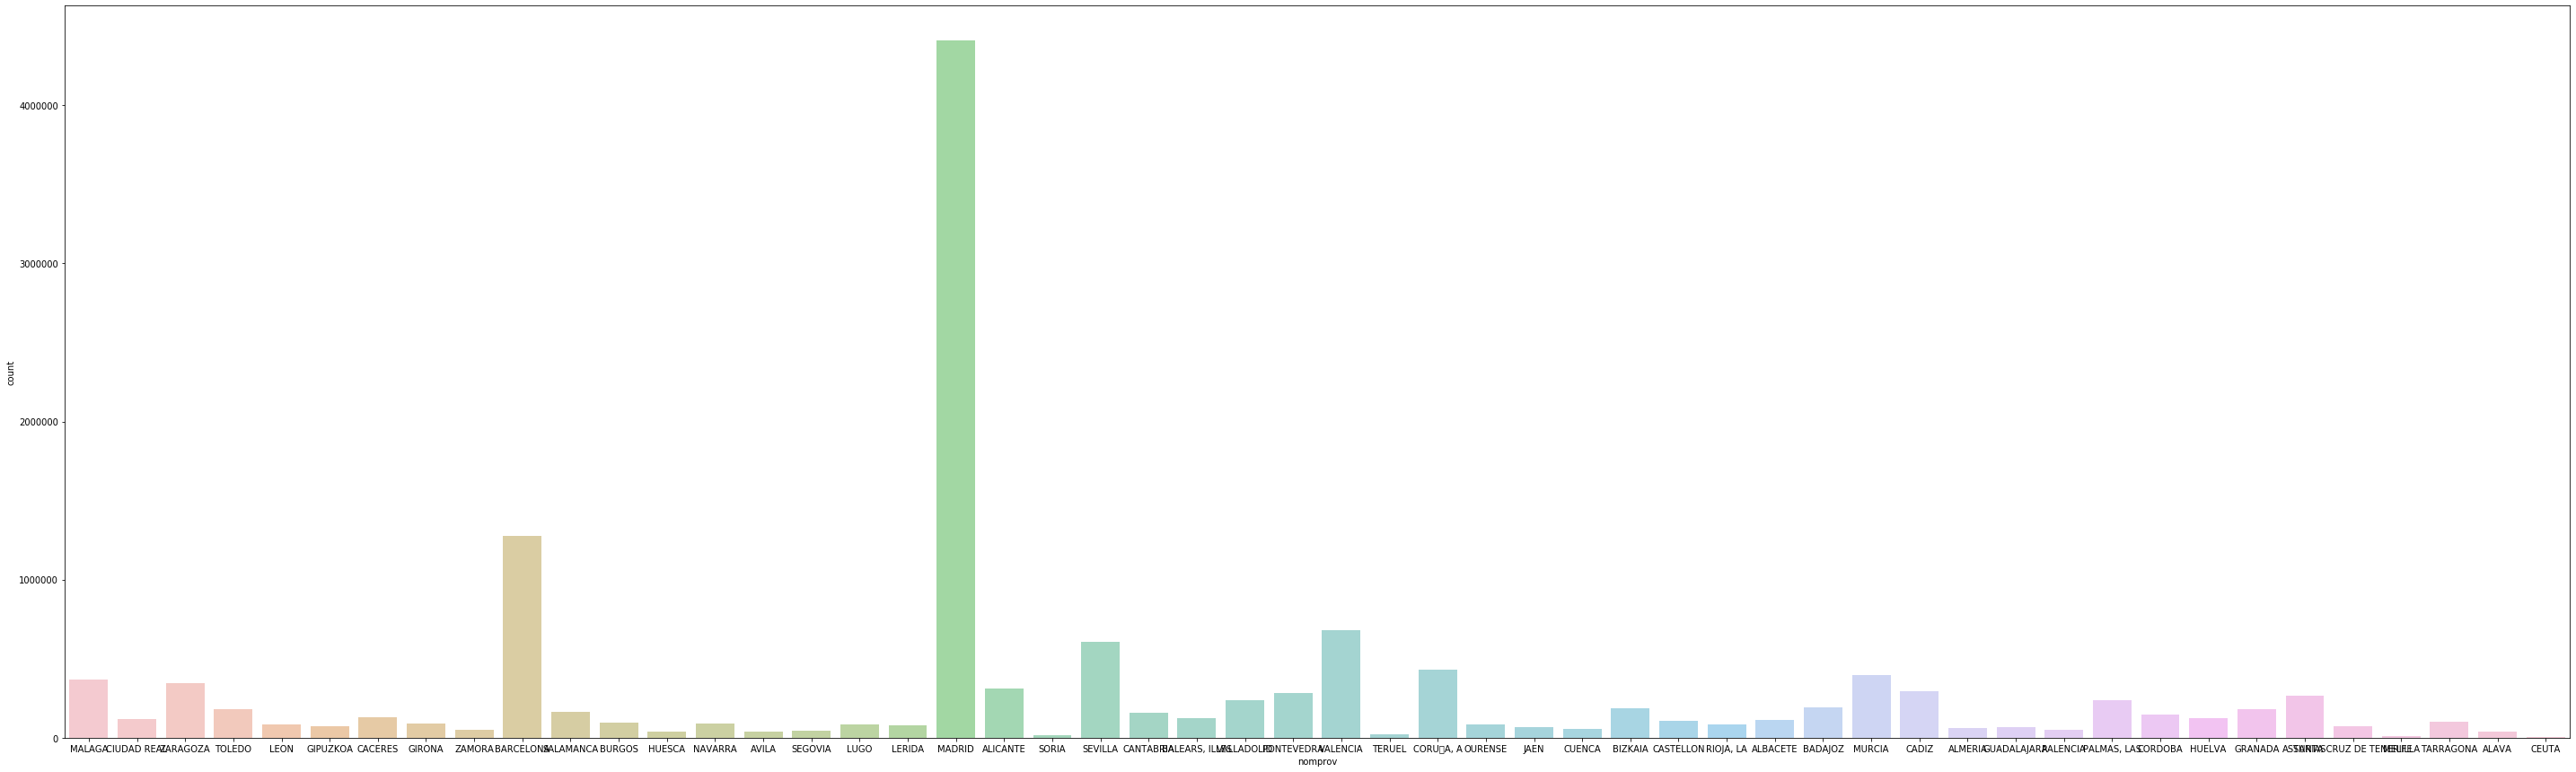

--------------------------------------------------
col:  ind_actividad_cliente


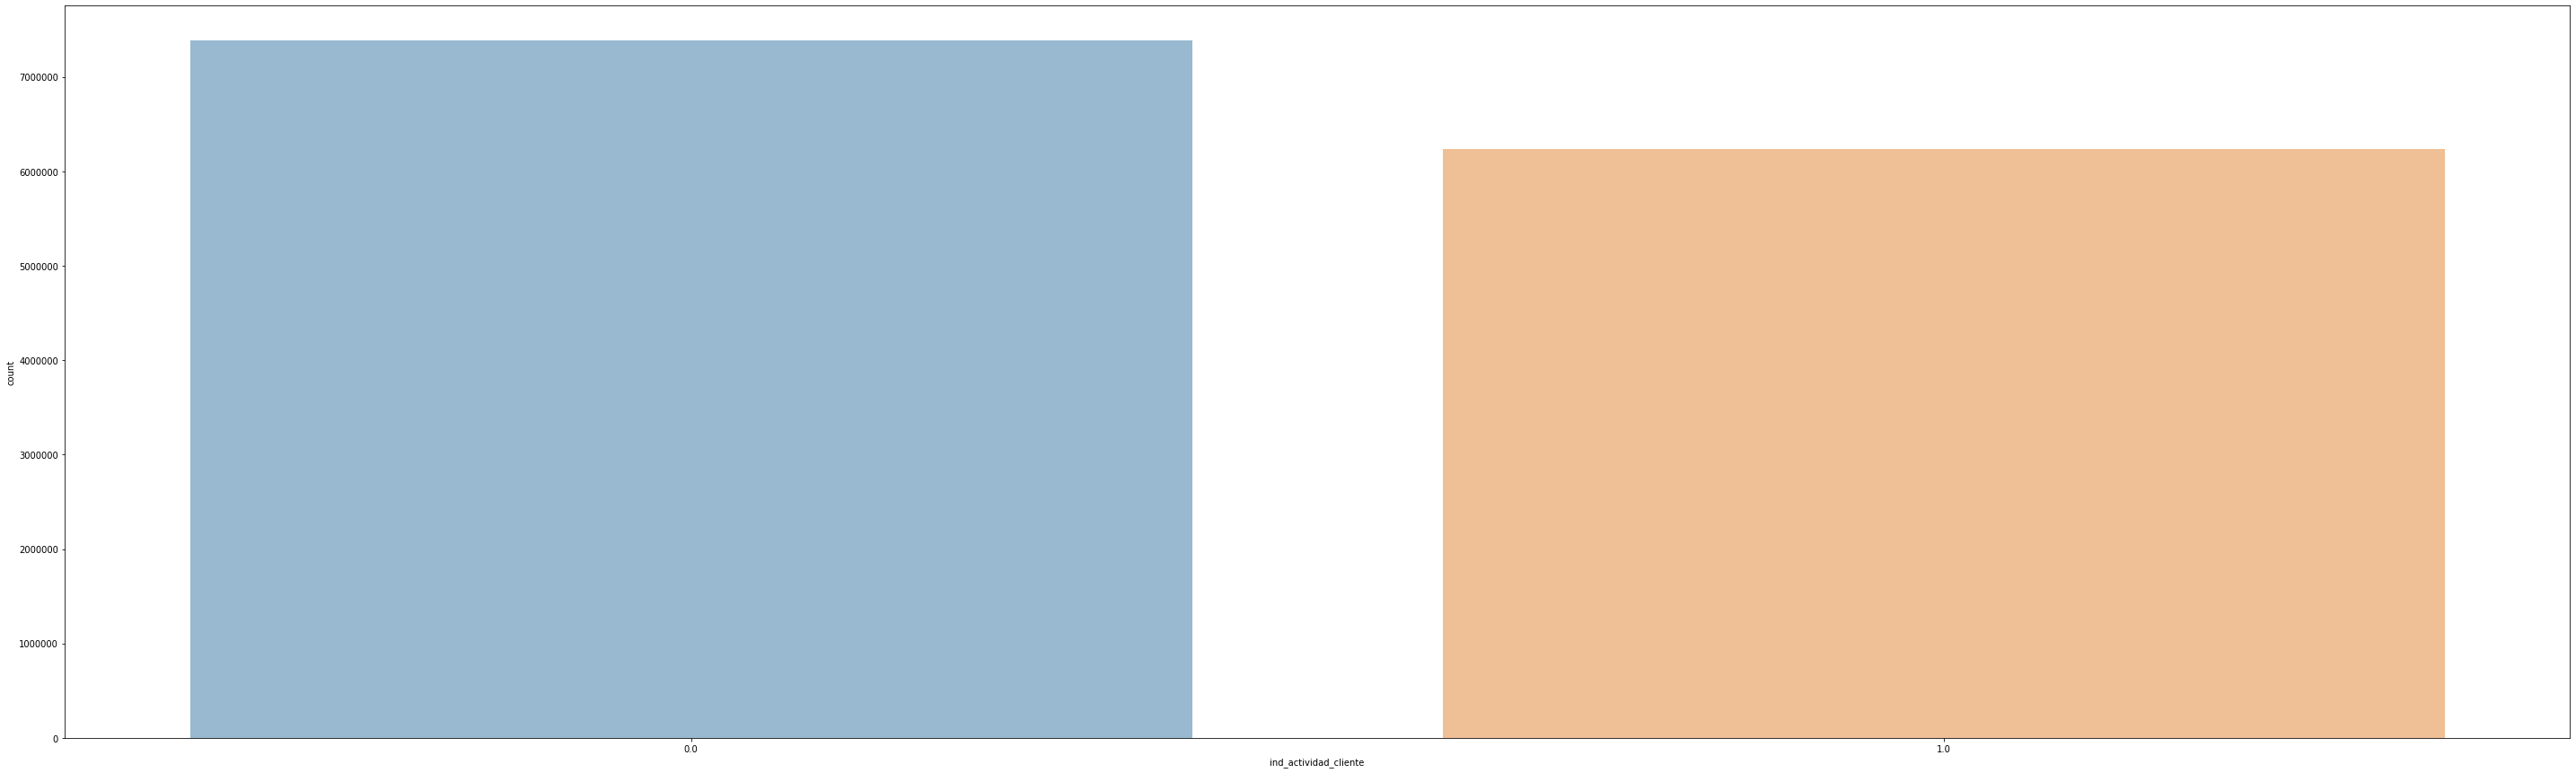

--------------------------------------------------
col:  segmento


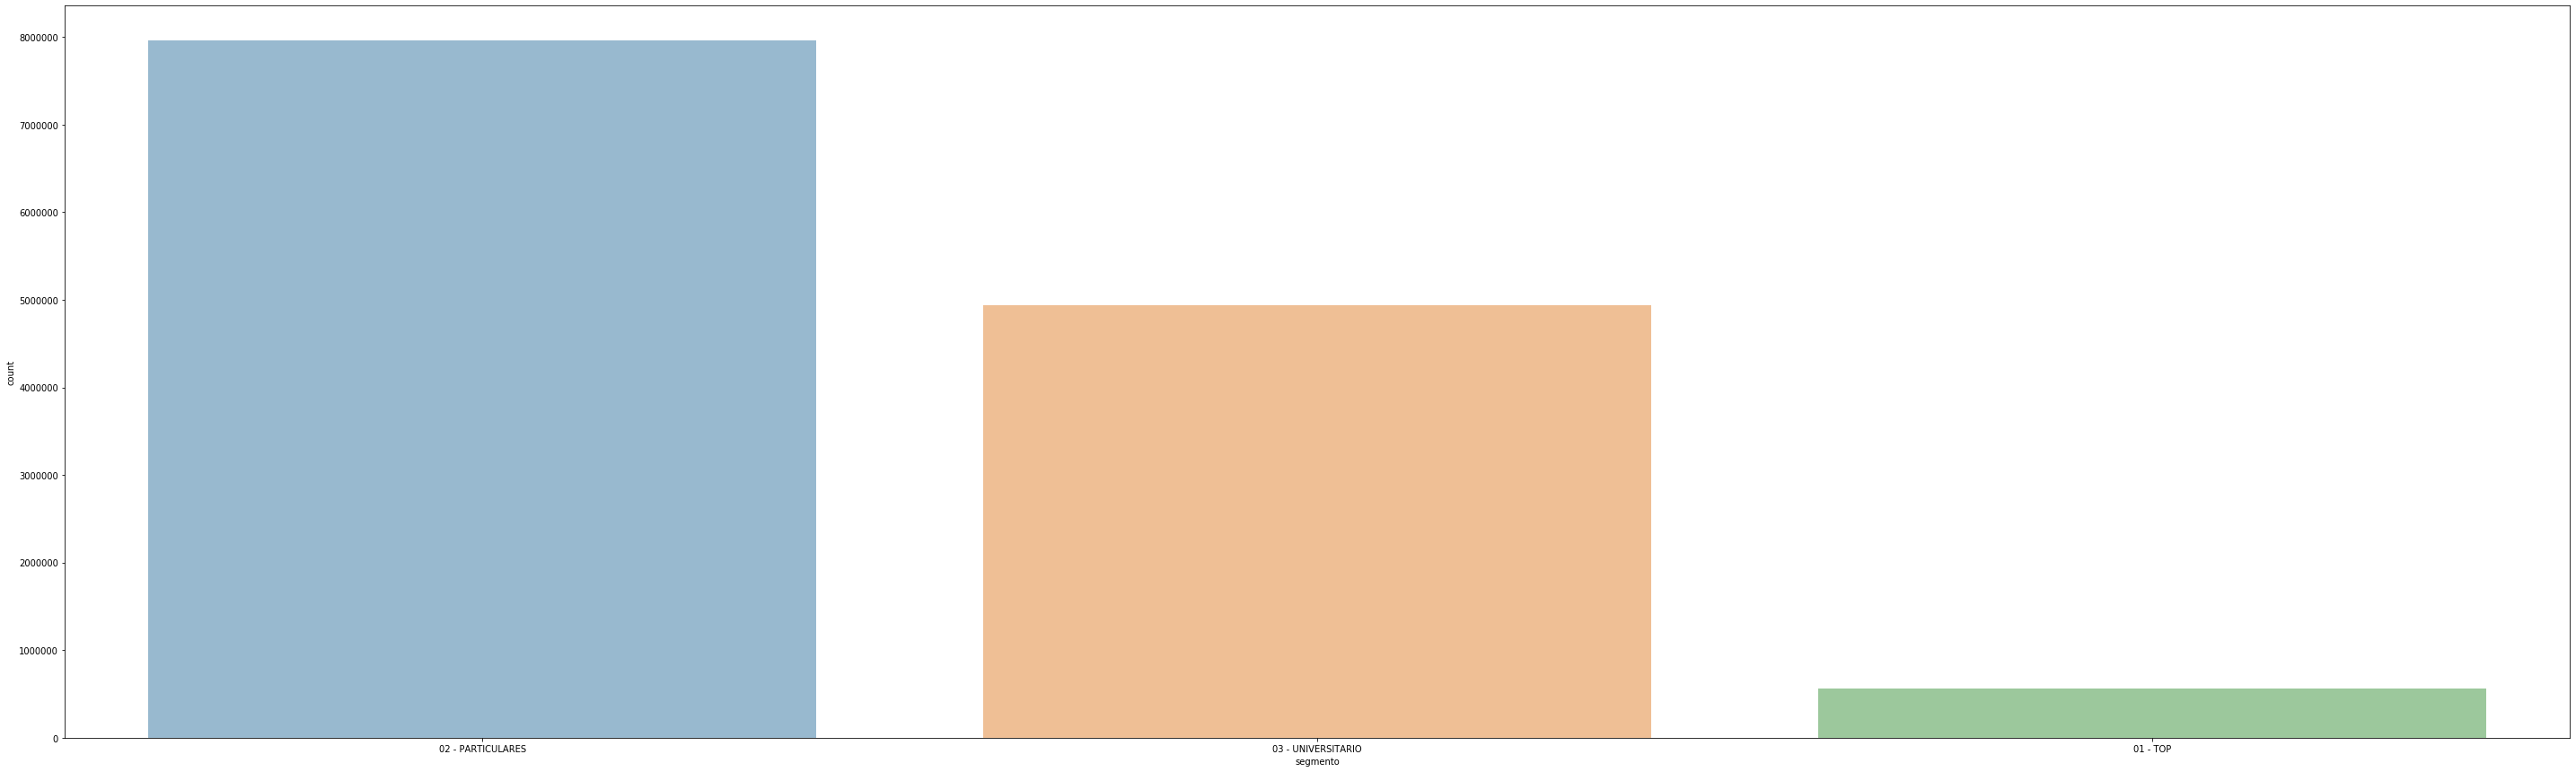

--------------------------------------------------
col:  ind_ahor_fin_ult1


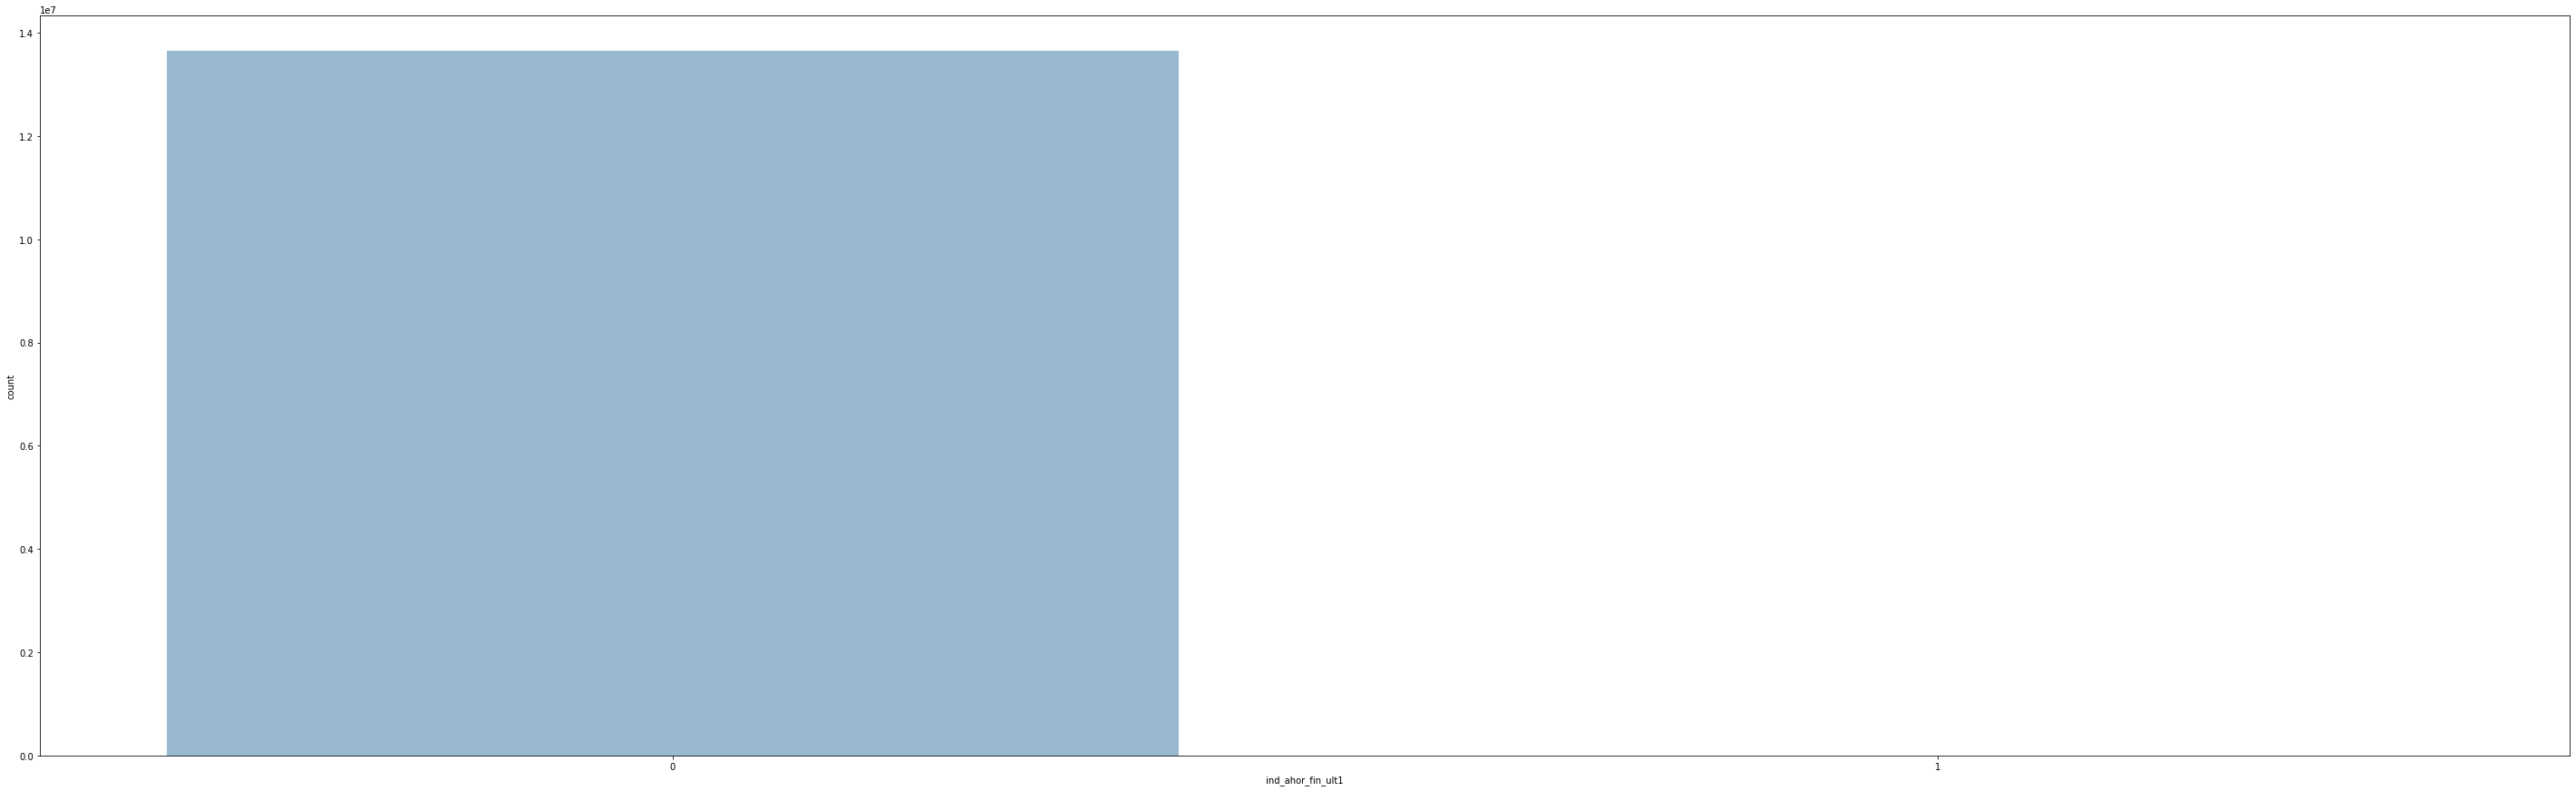

--------------------------------------------------
col:  ind_aval_fin_ult1


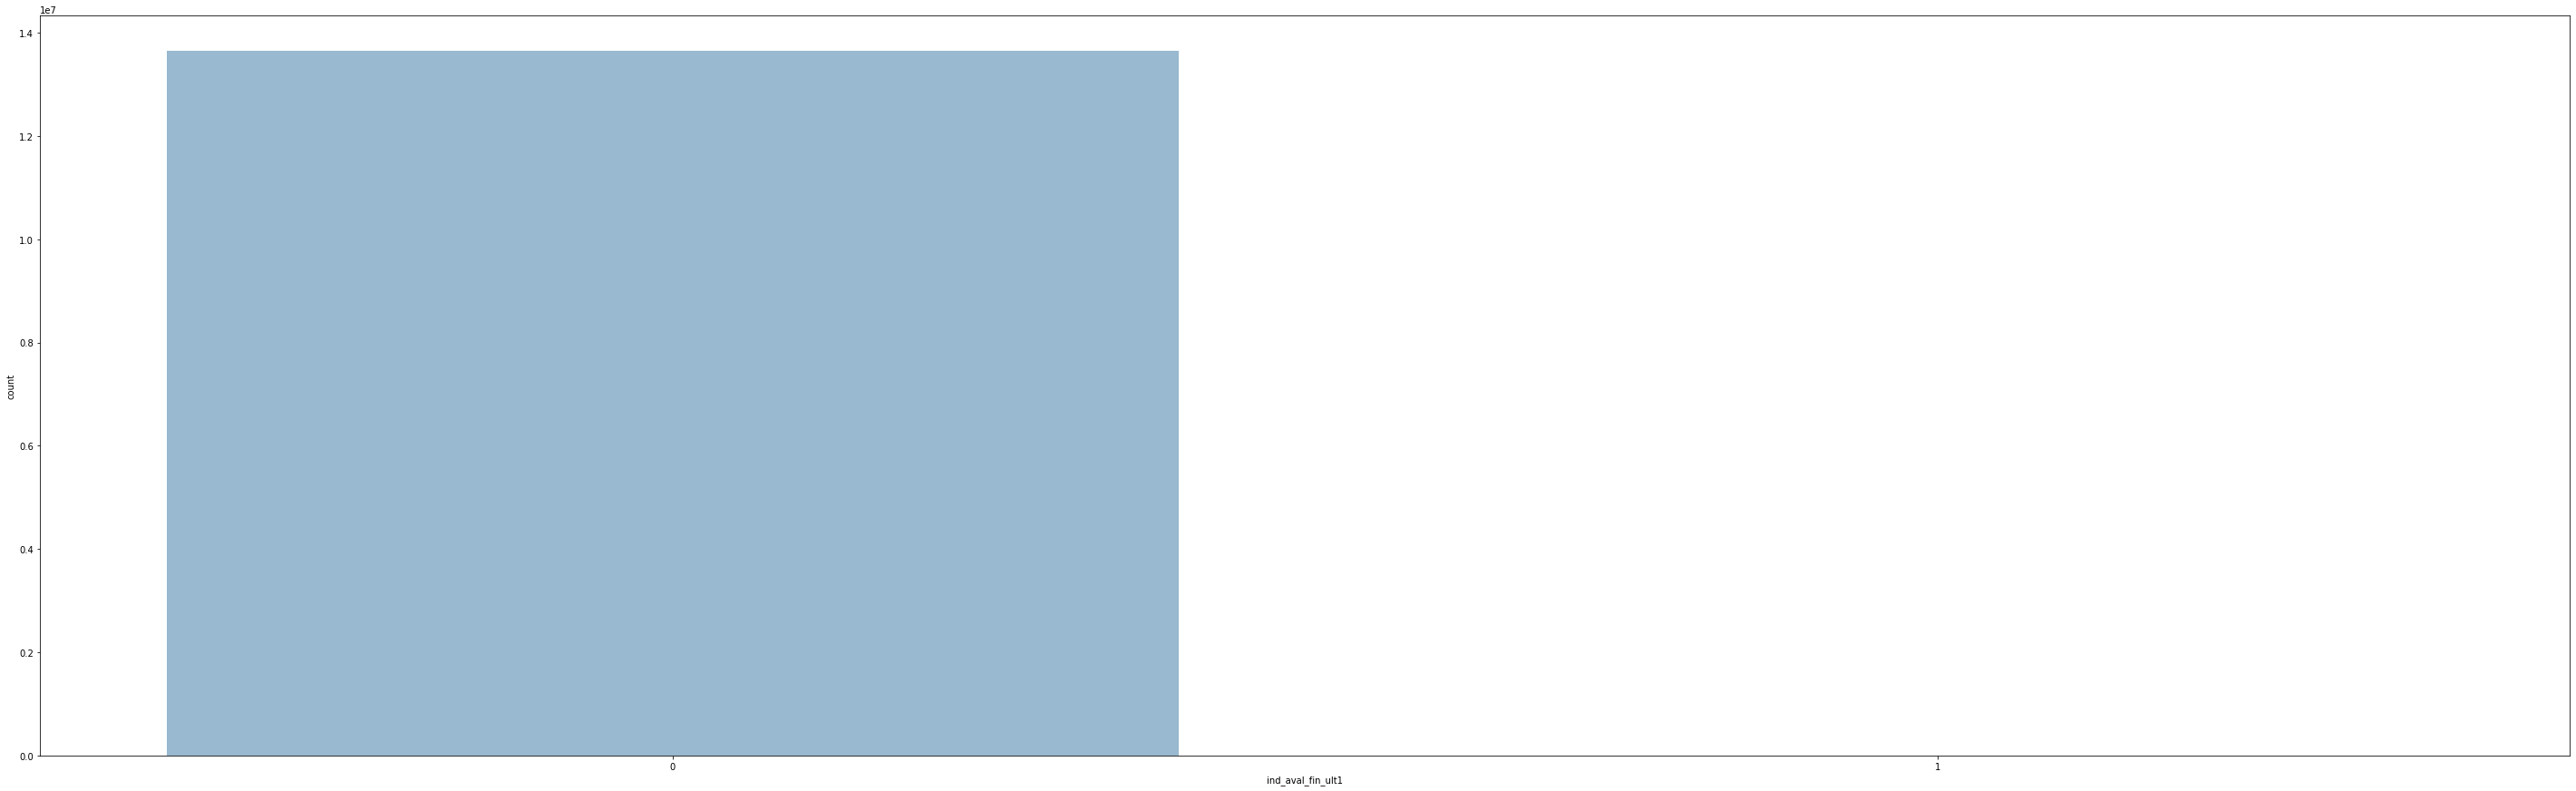

--------------------------------------------------
col:  ind_cco_fin_ult1


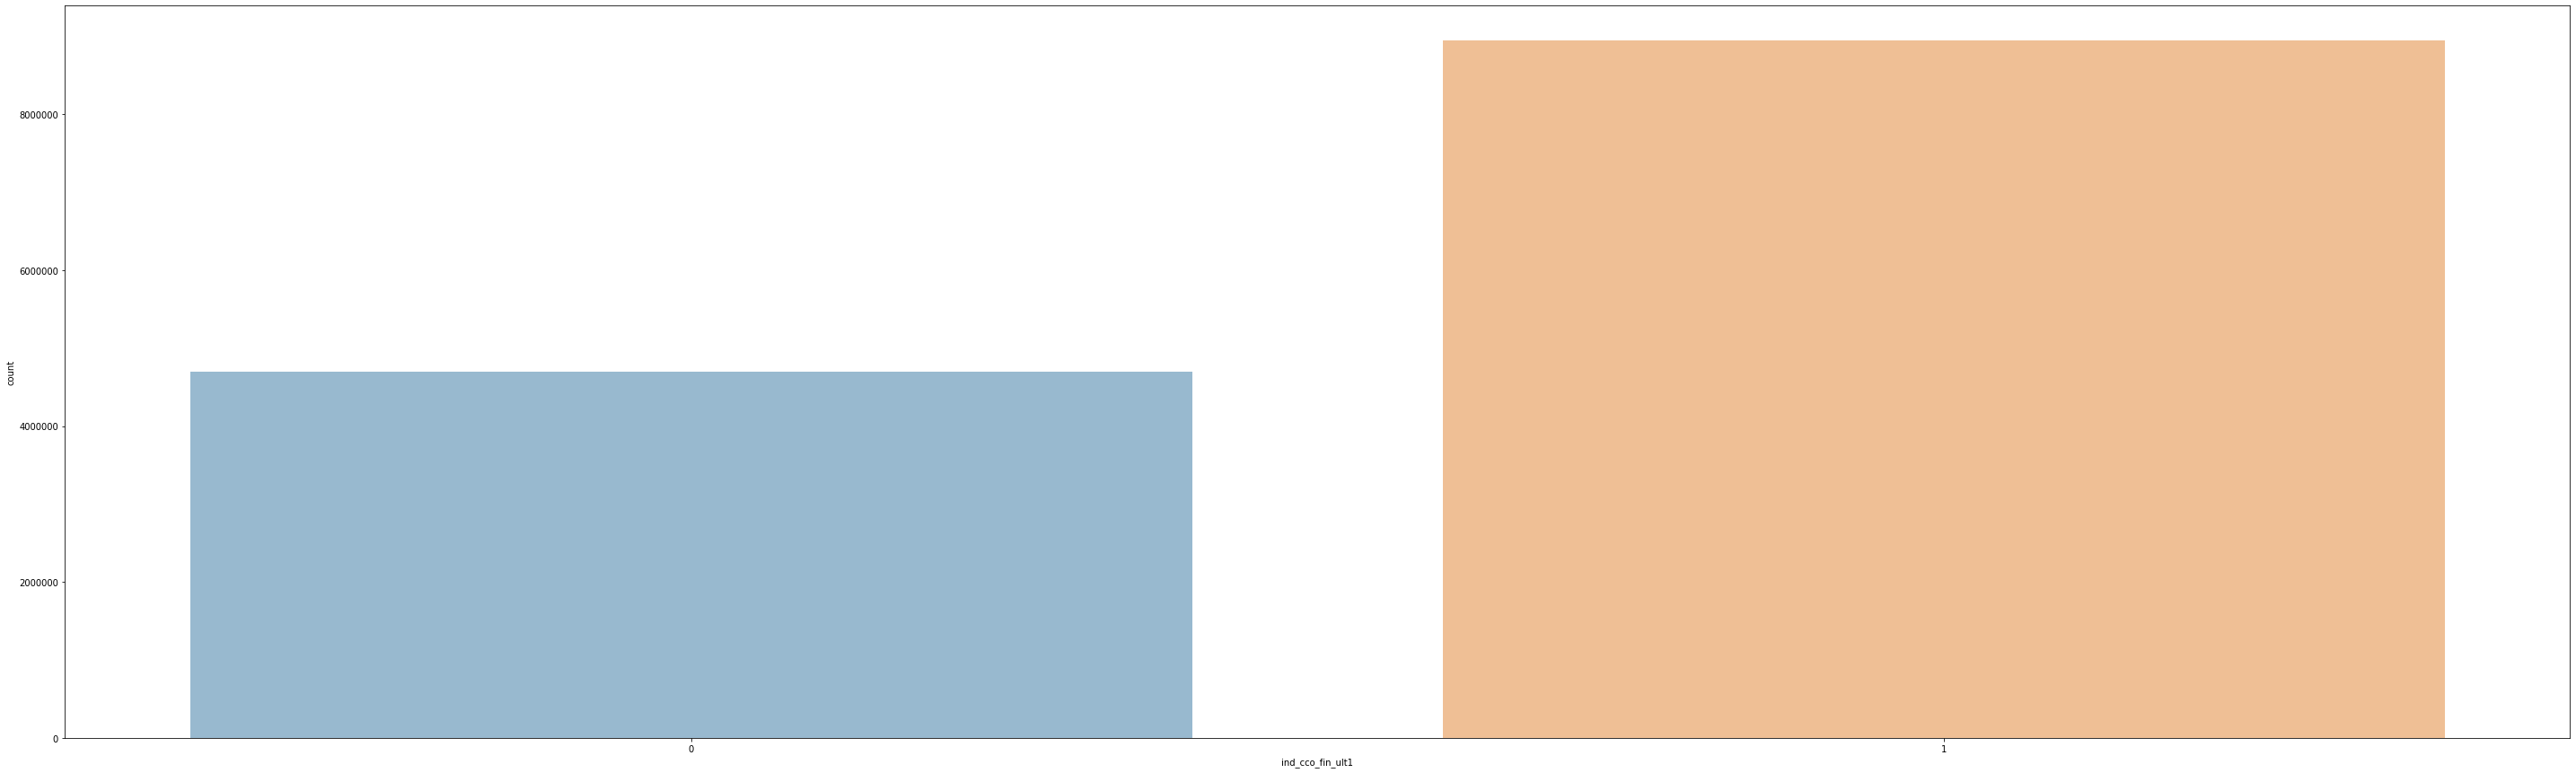

--------------------------------------------------
col:  ind_cder_fin_ult1


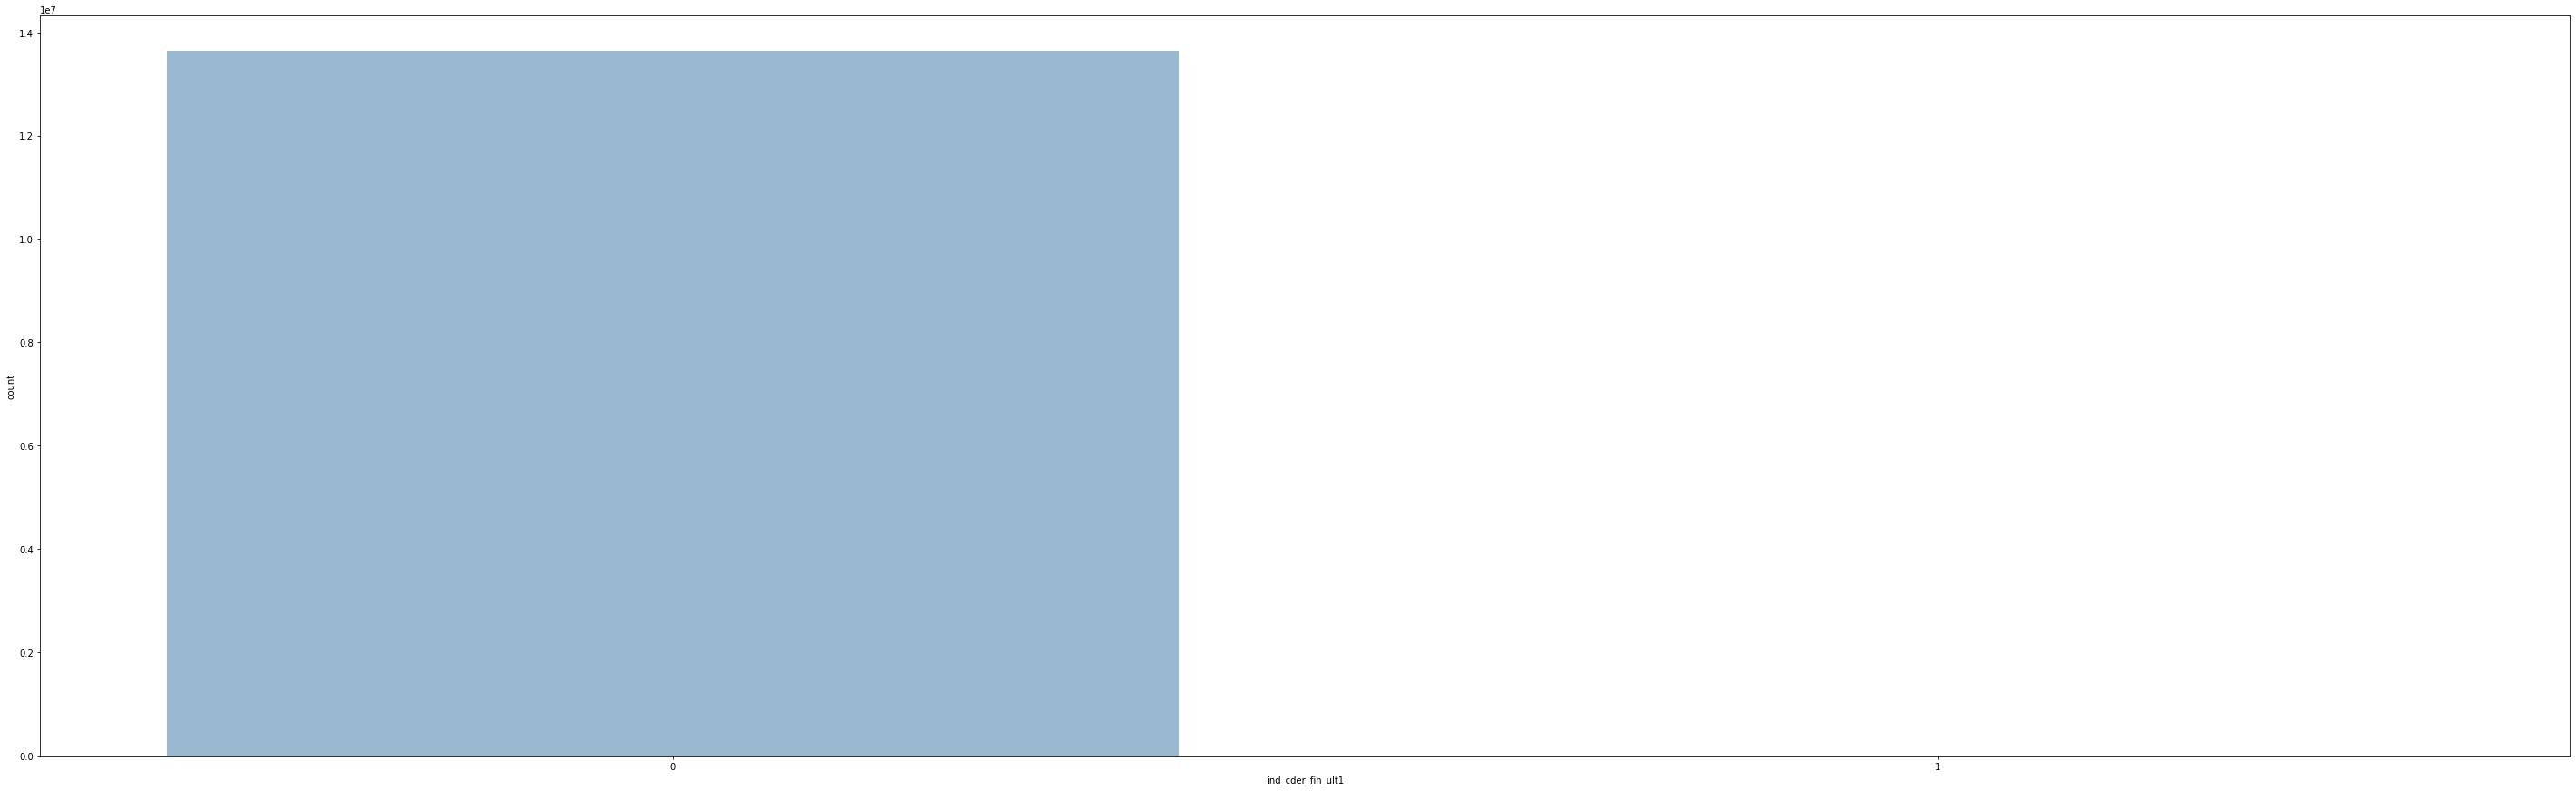

--------------------------------------------------
col:  ind_cno_fin_ult1


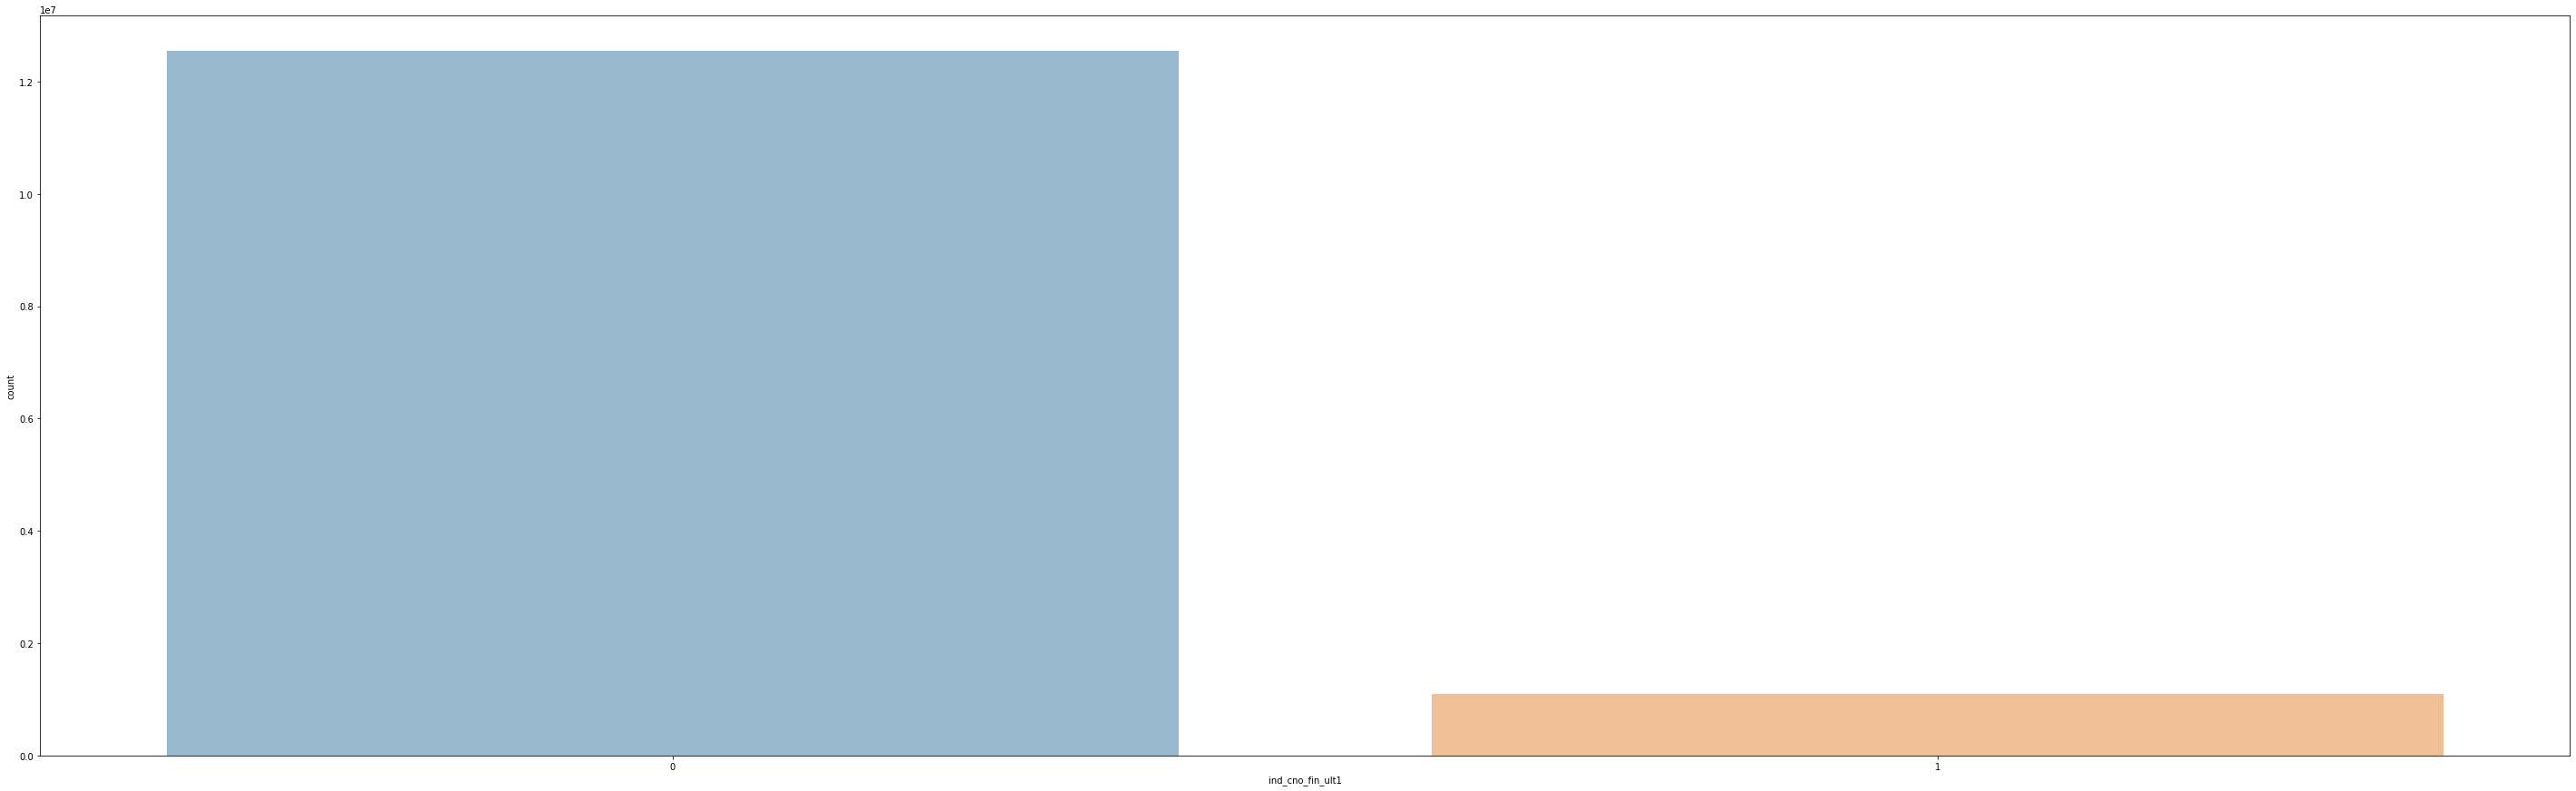

--------------------------------------------------
col:  ind_ctju_fin_ult1


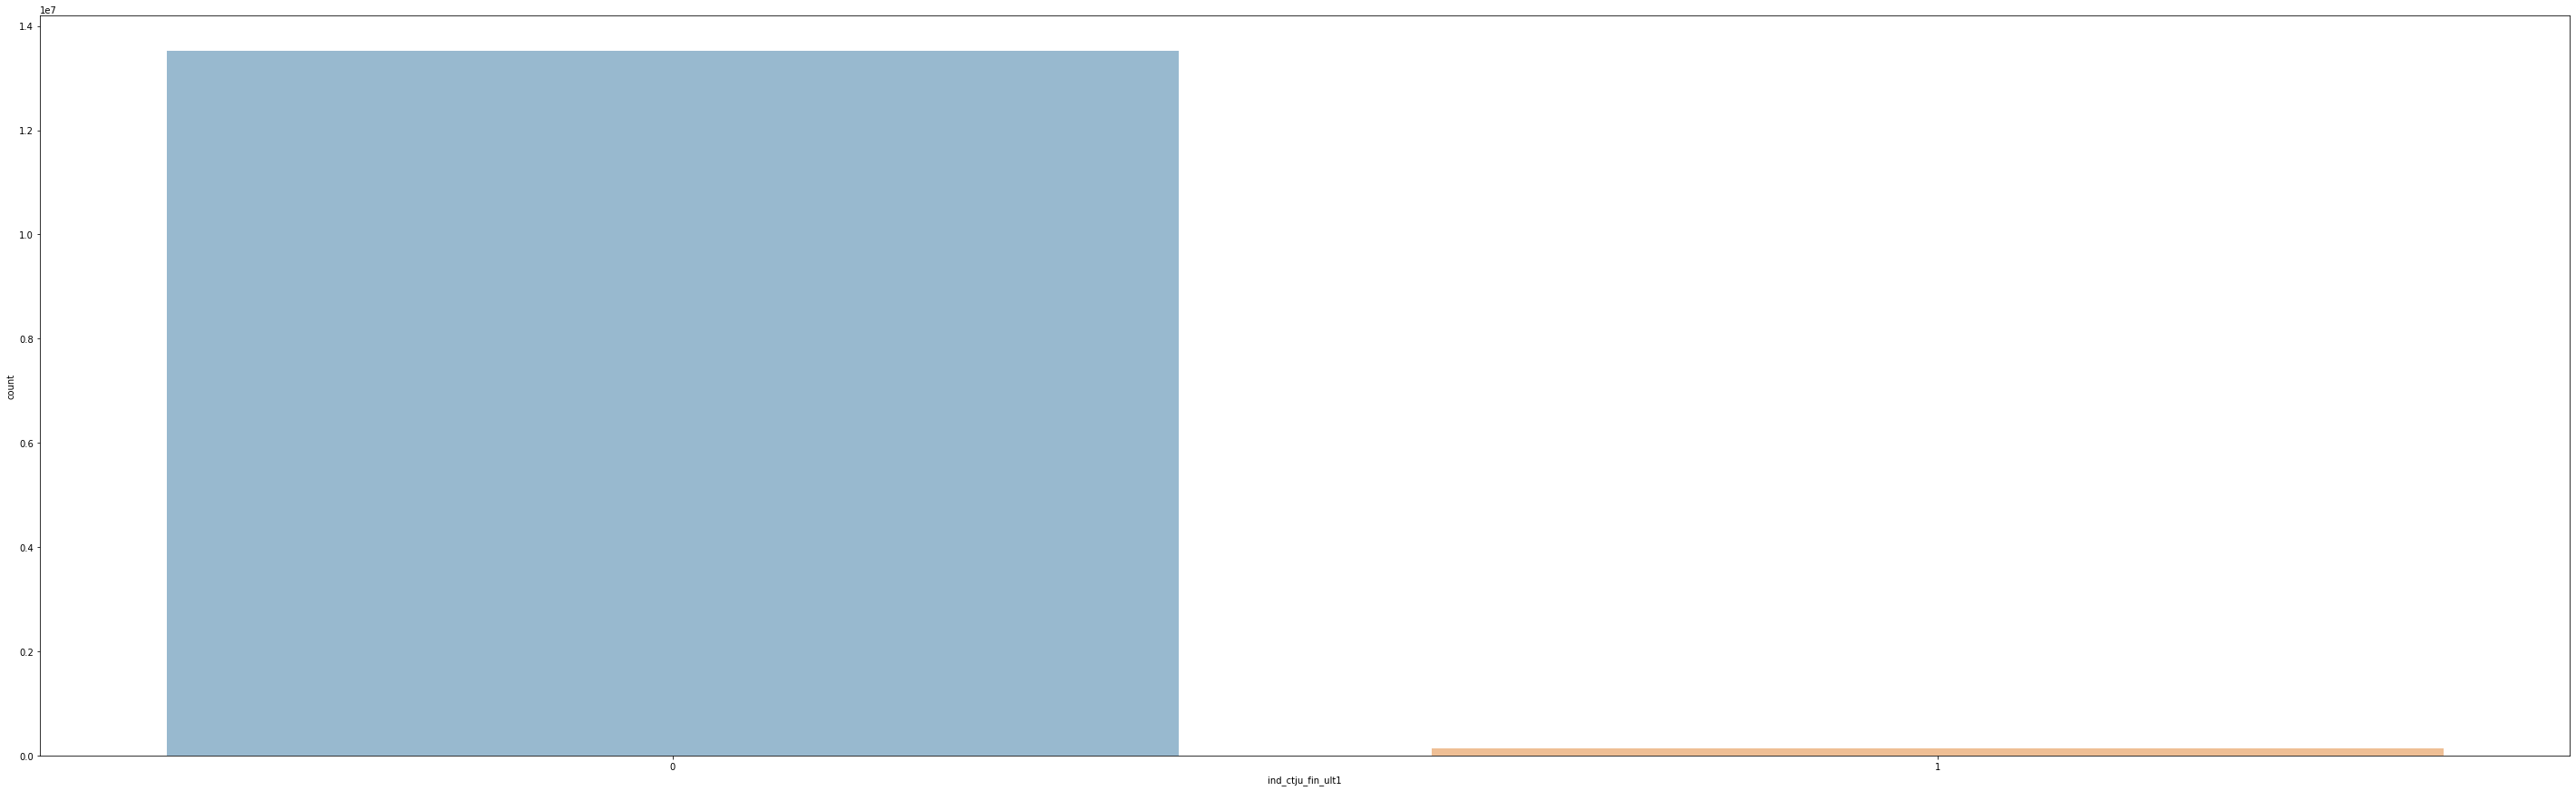

--------------------------------------------------
col:  ind_ctma_fin_ult1


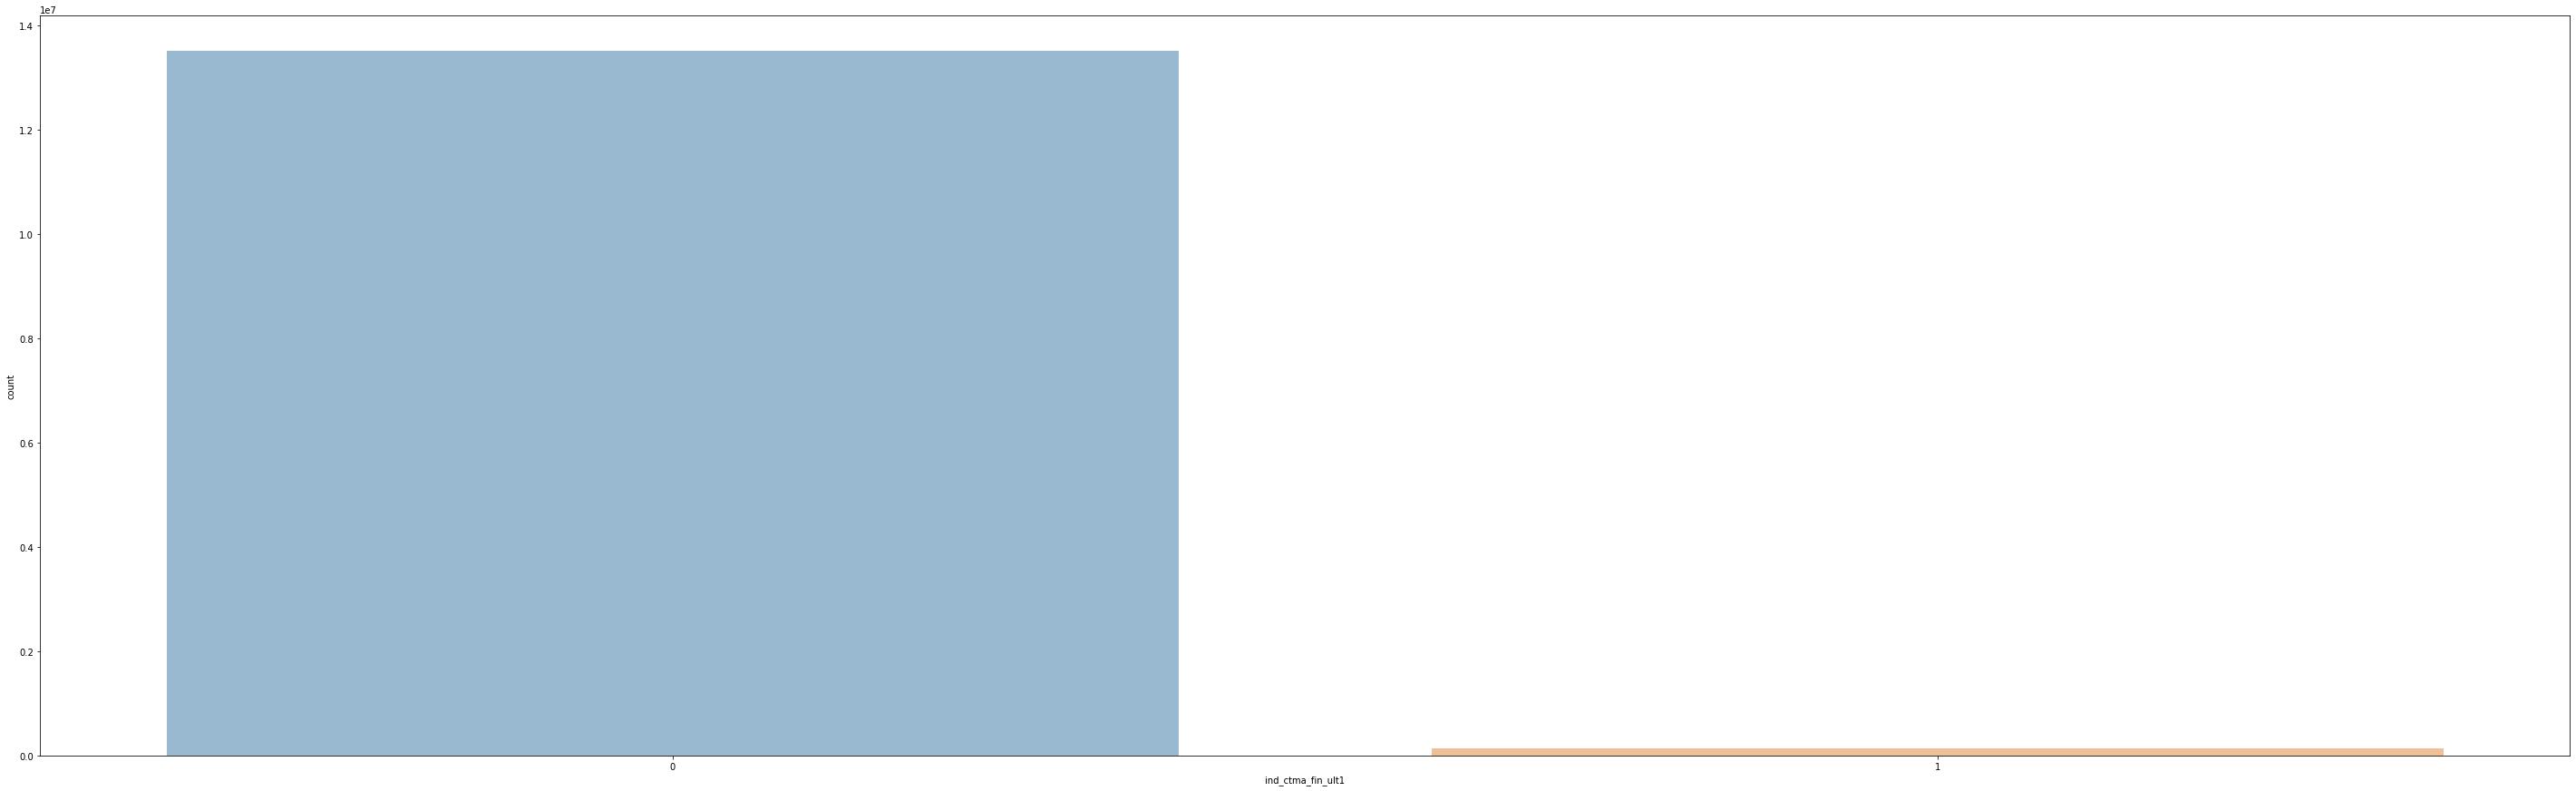

--------------------------------------------------
col:  ind_ctop_fin_ult1


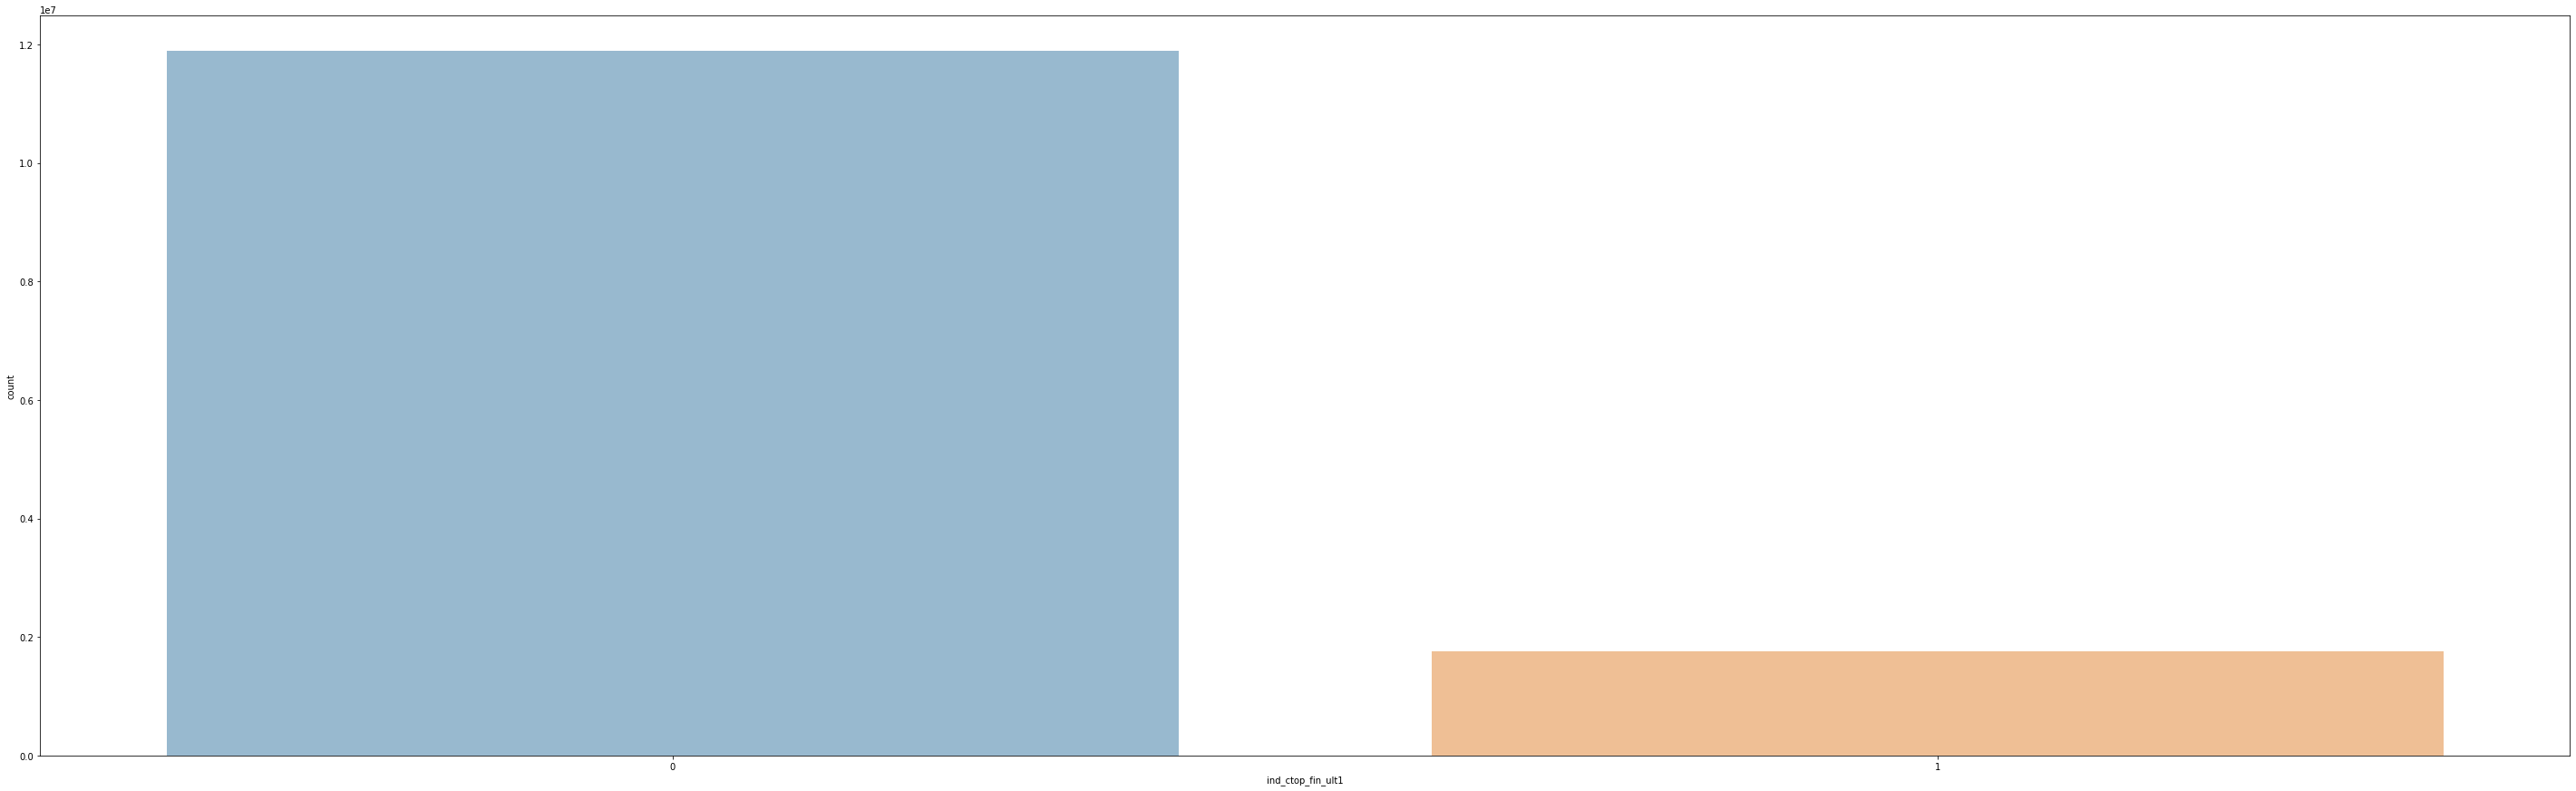

--------------------------------------------------
col:  ind_ctpp_fin_ult1


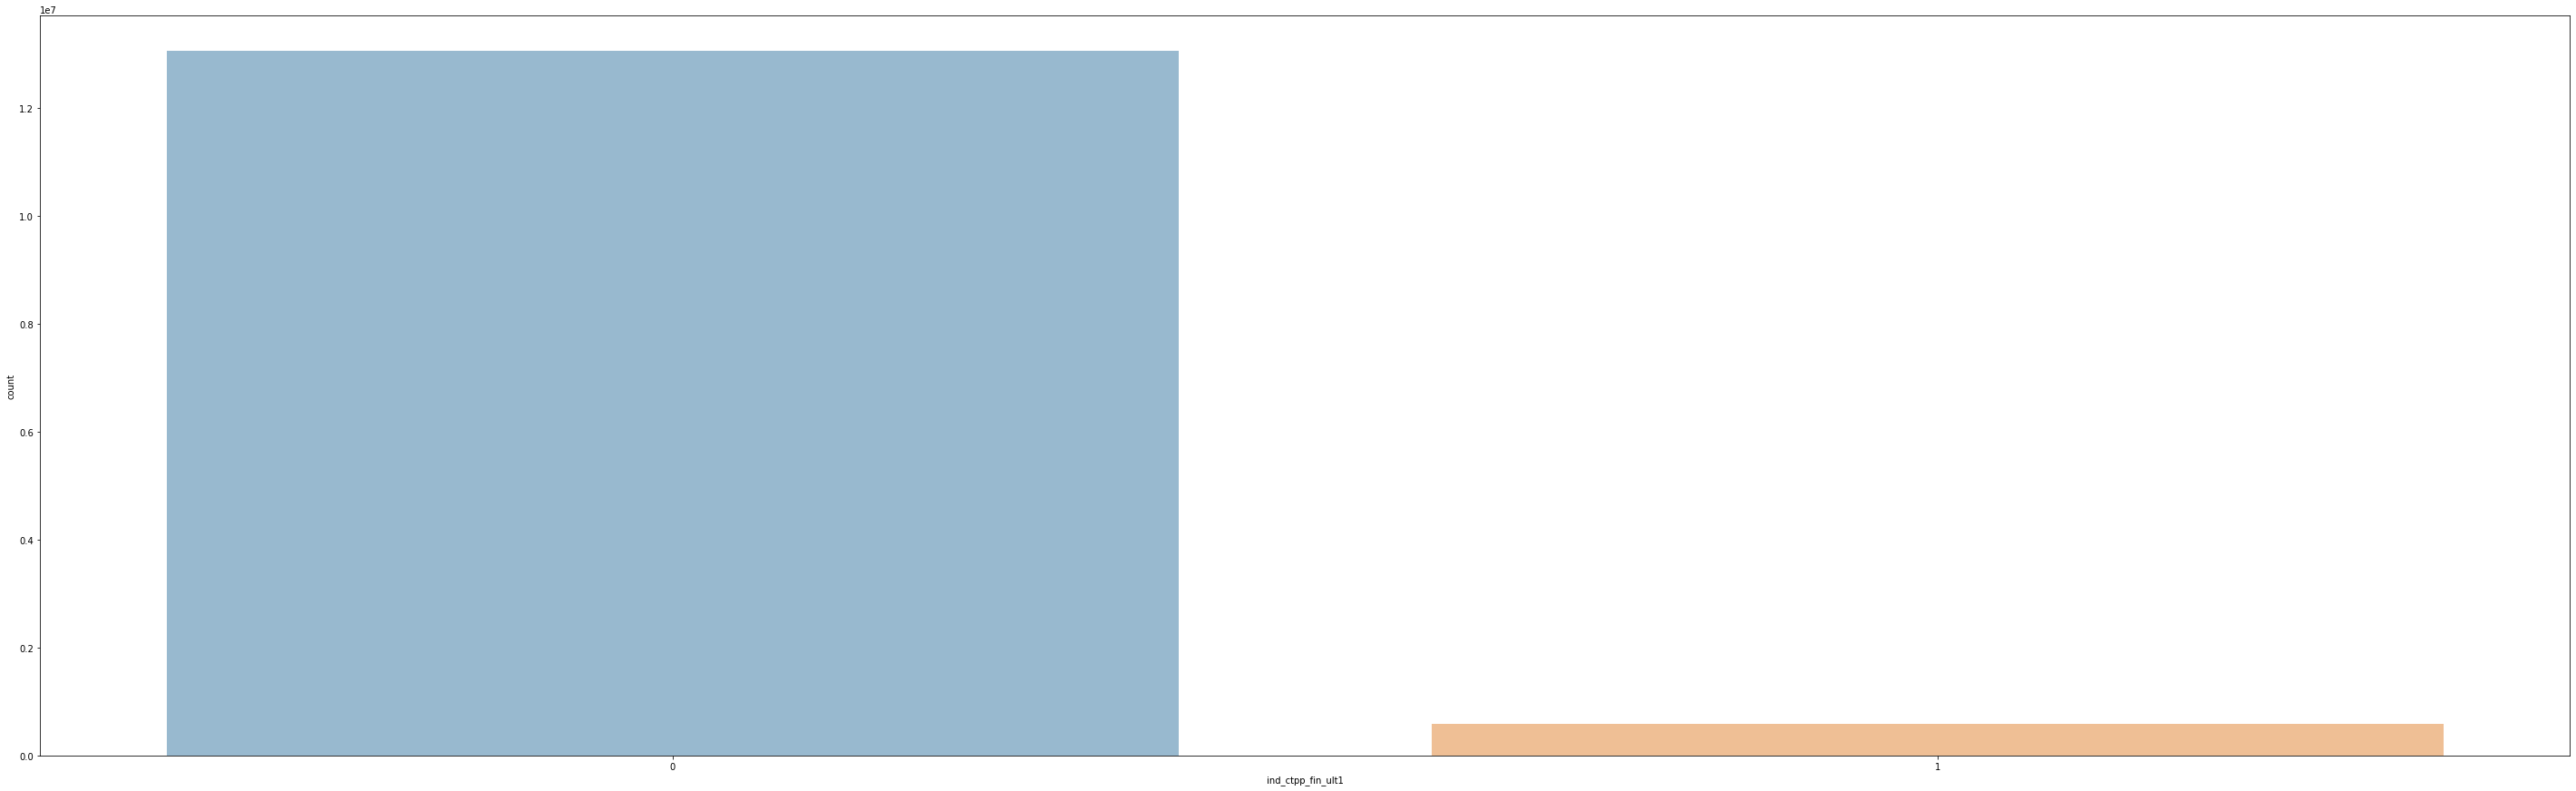

--------------------------------------------------
col:  ind_deco_fin_ult1


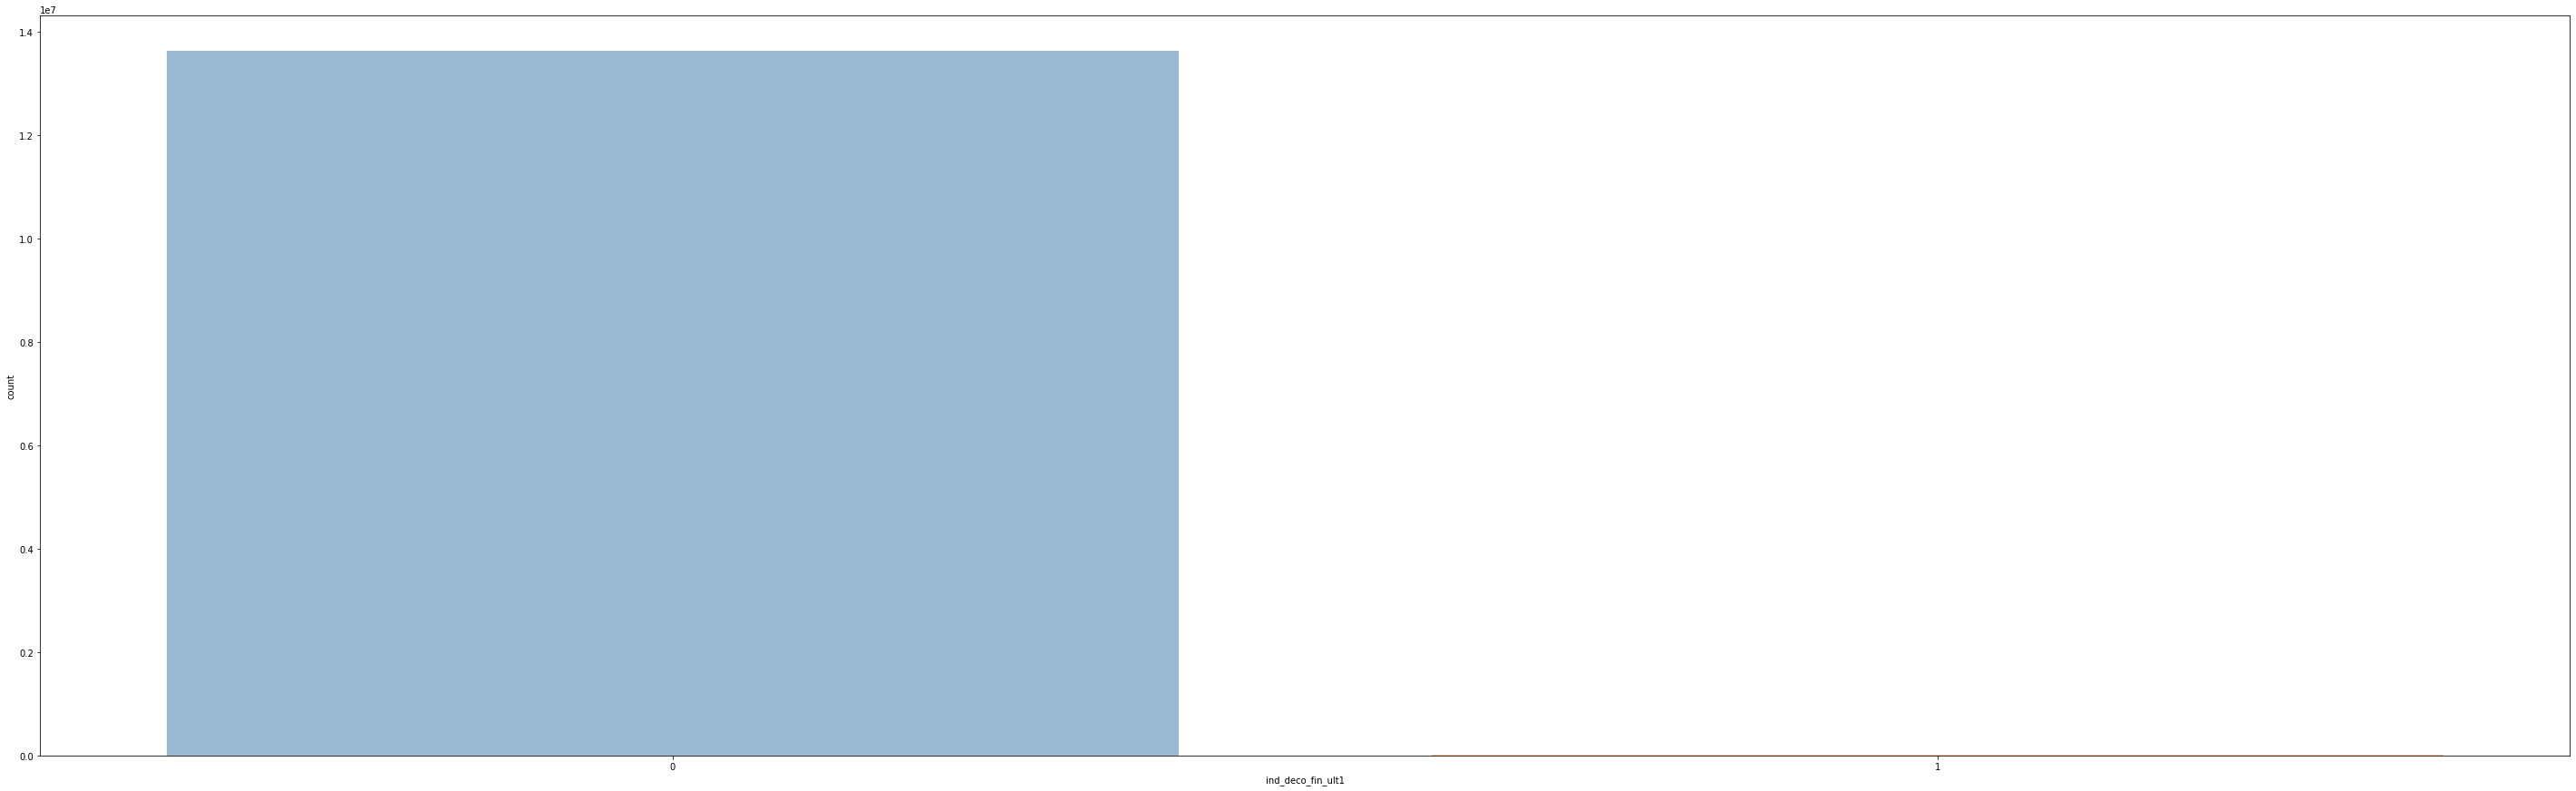

--------------------------------------------------
col:  ind_deme_fin_ult1


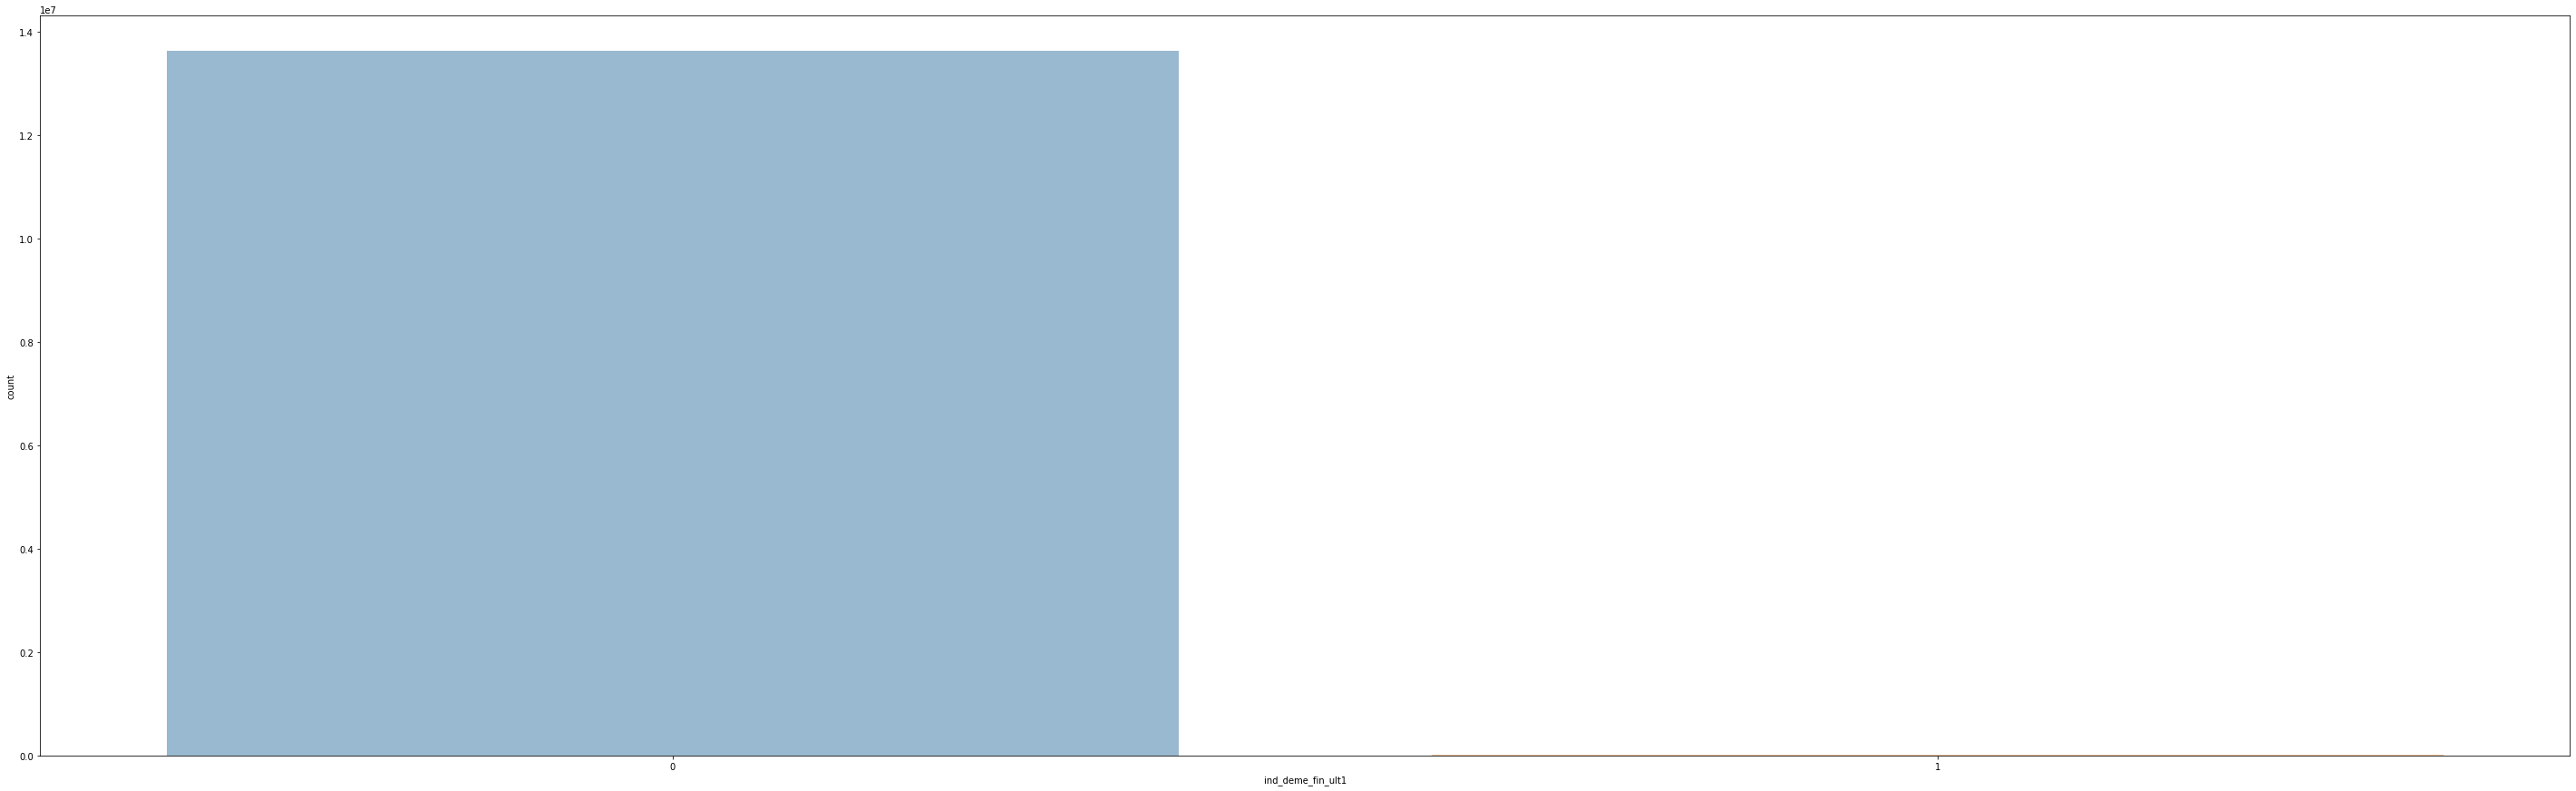

--------------------------------------------------
col:  ind_dela_fin_ult1


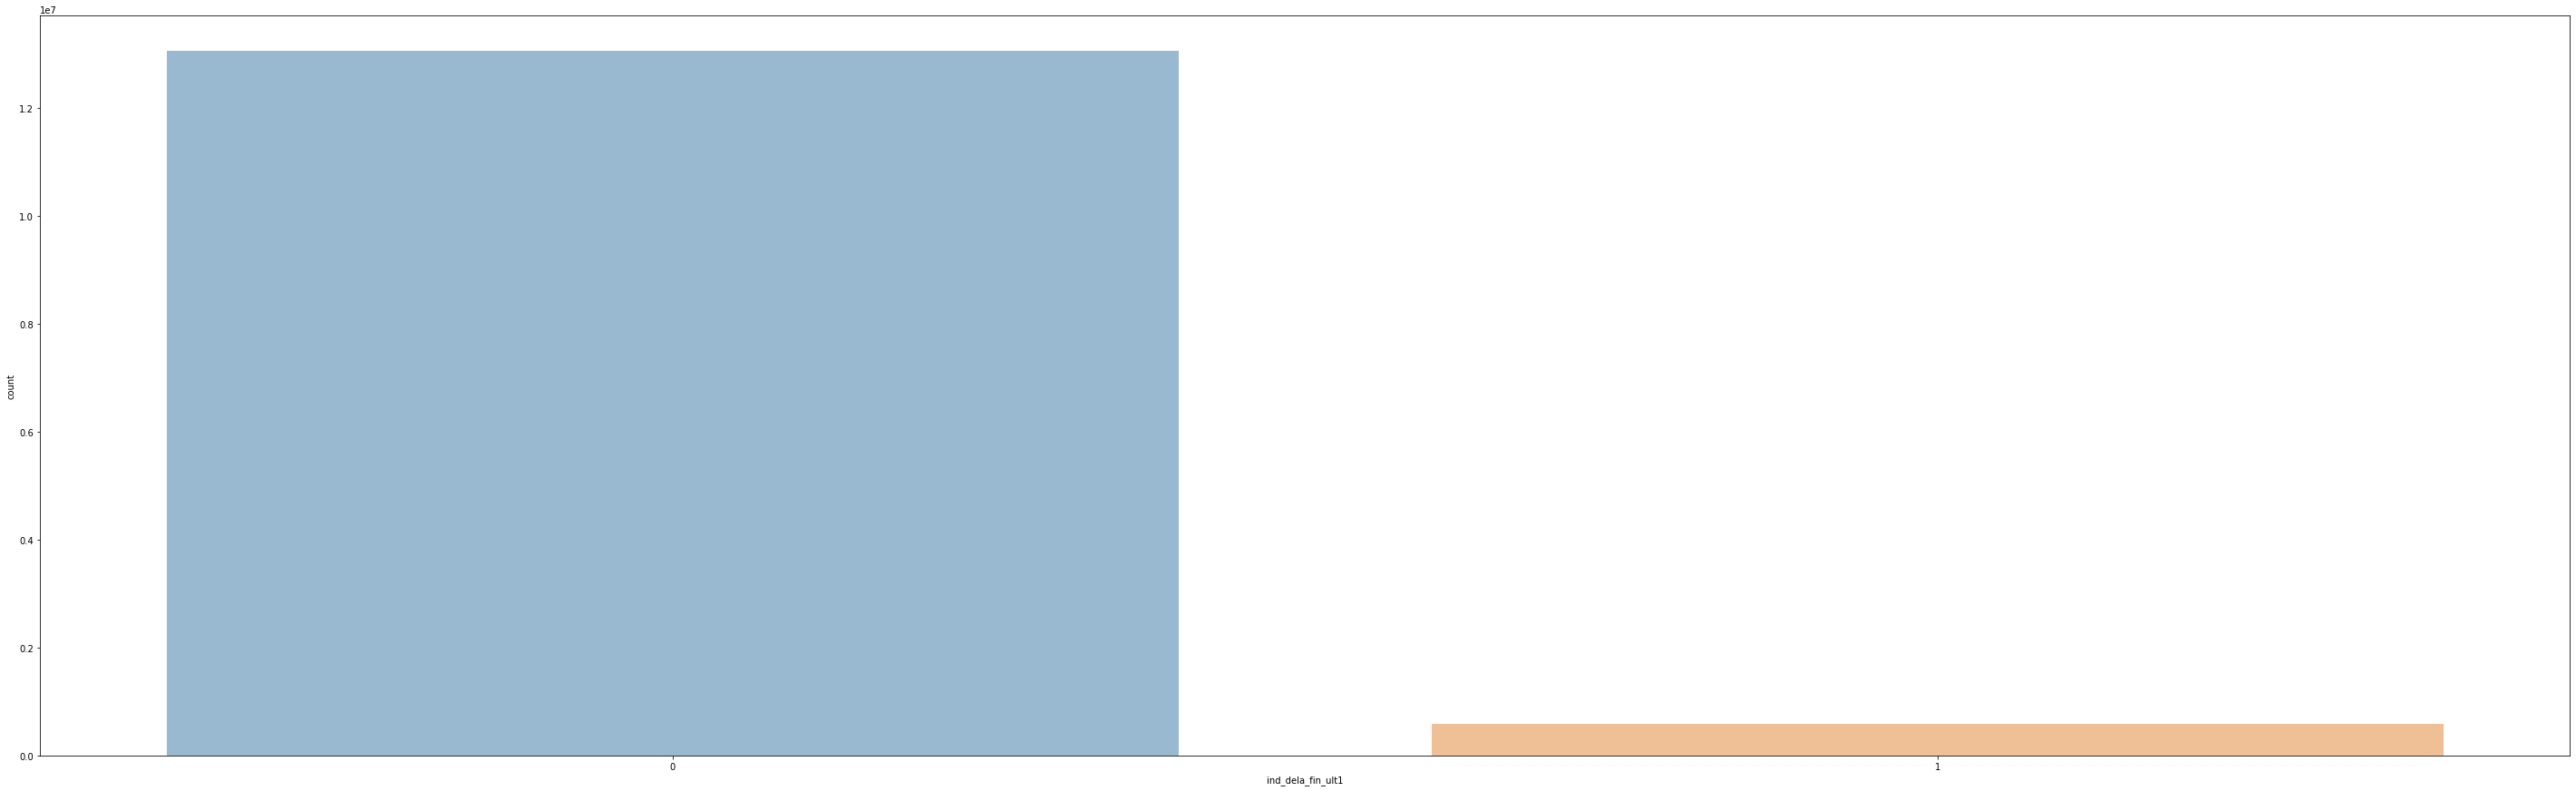

--------------------------------------------------
col:  ind_ecue_fin_ult1


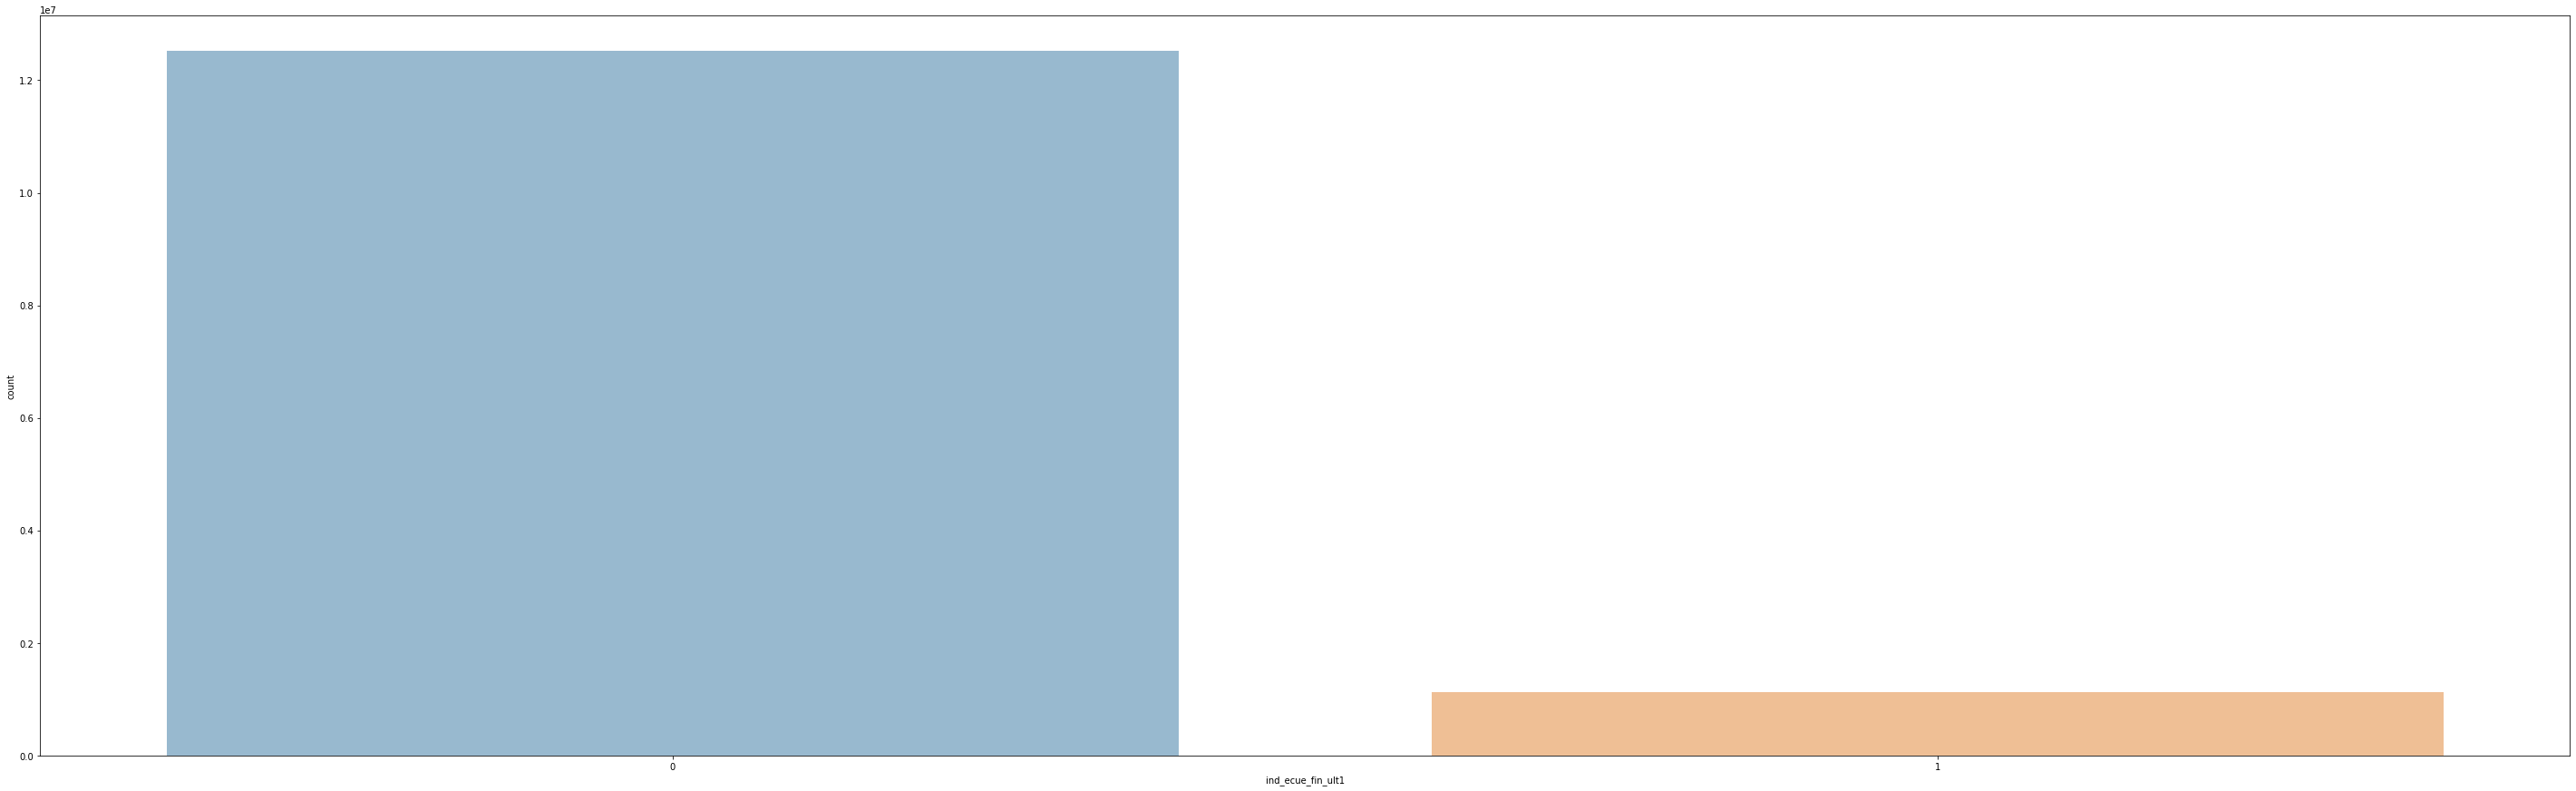

--------------------------------------------------
col:  ind_fond_fin_ult1


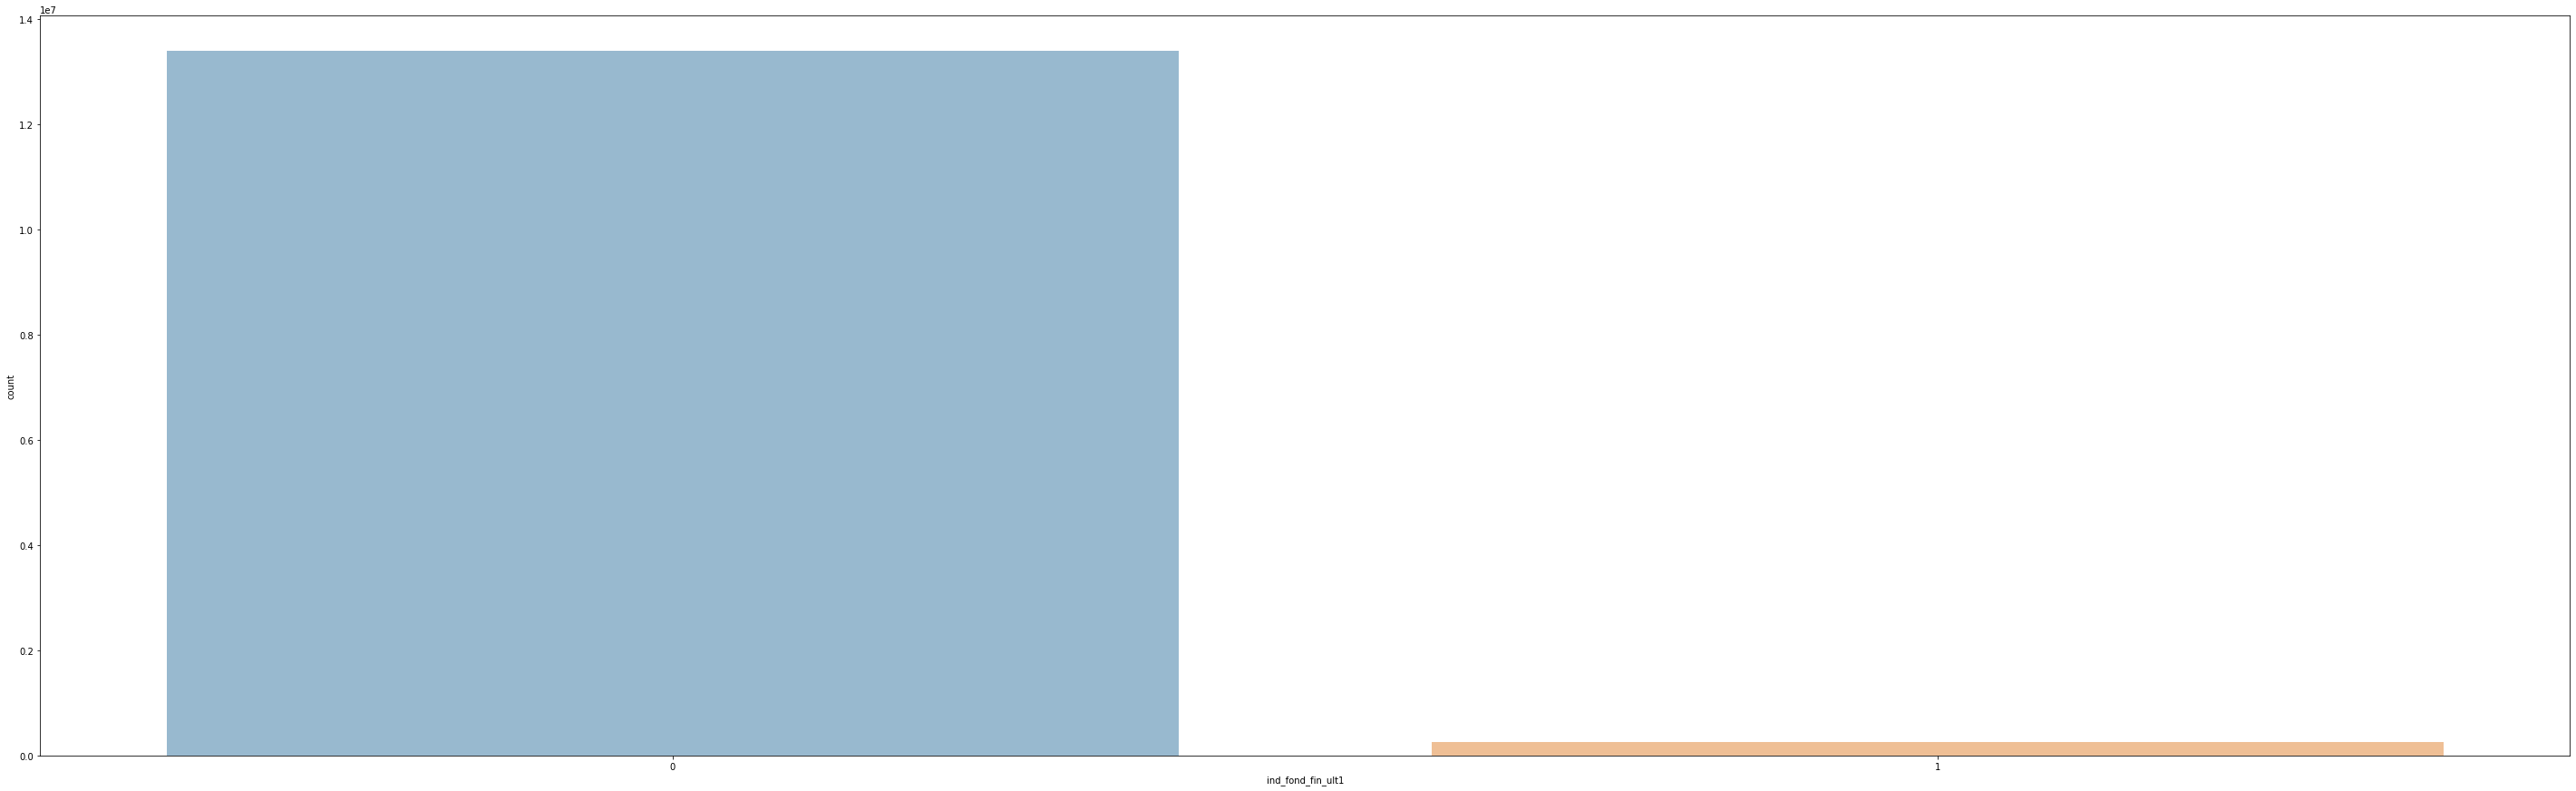

--------------------------------------------------
col:  ind_hip_fin_ult1


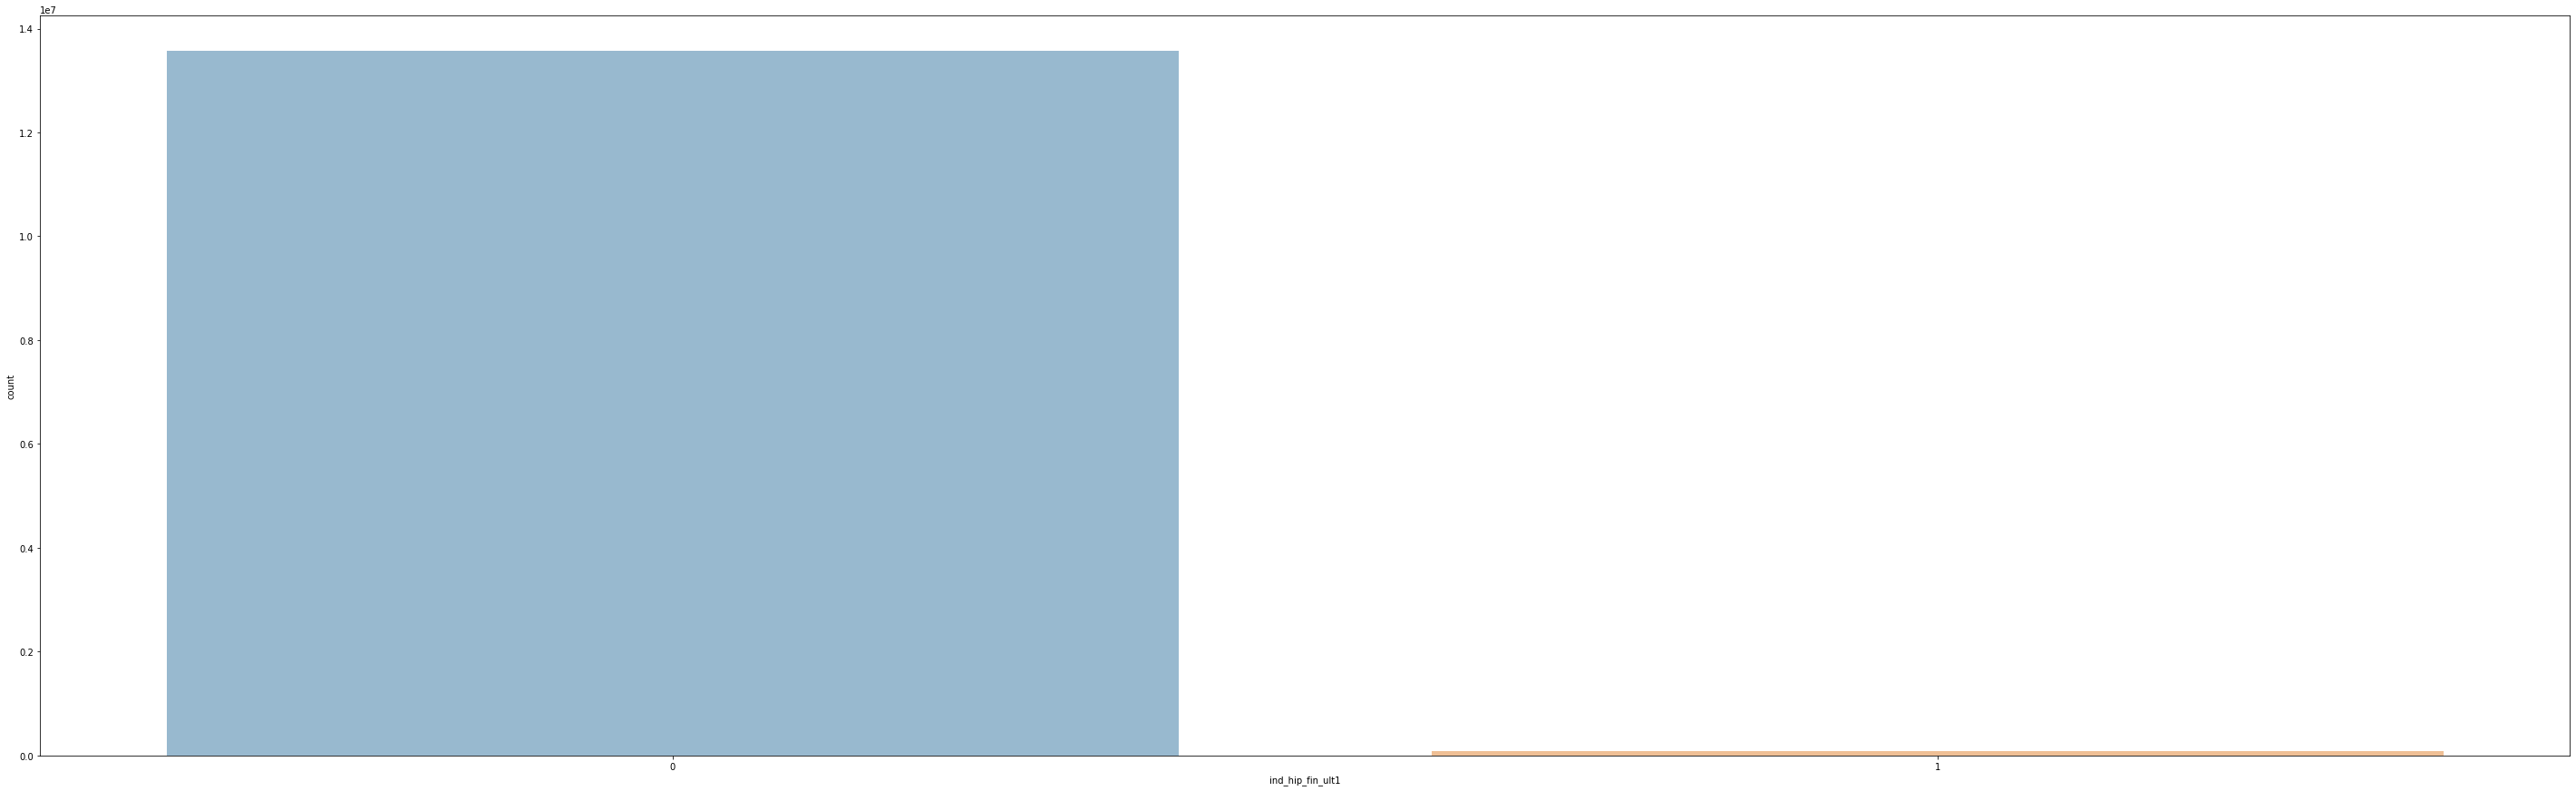

--------------------------------------------------
col:  ind_plan_fin_ult1


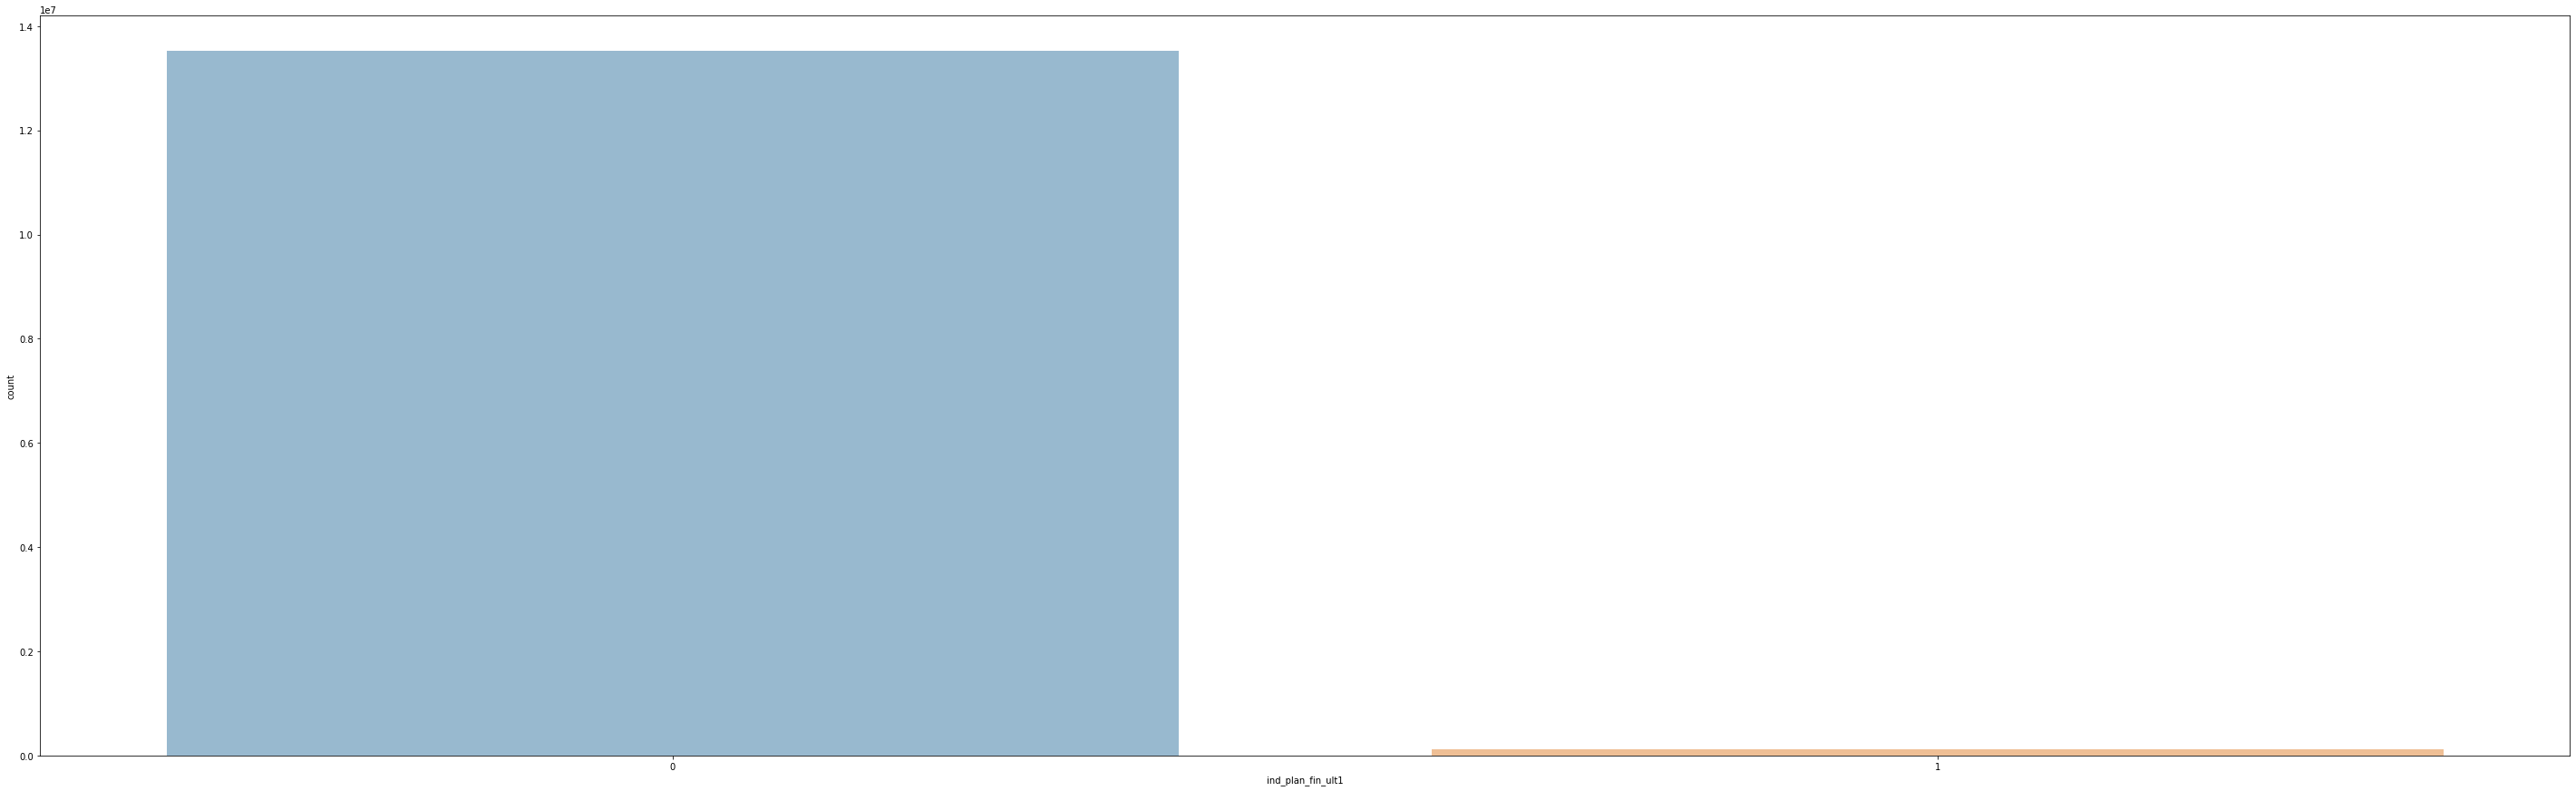

--------------------------------------------------
col:  ind_pres_fin_ult1


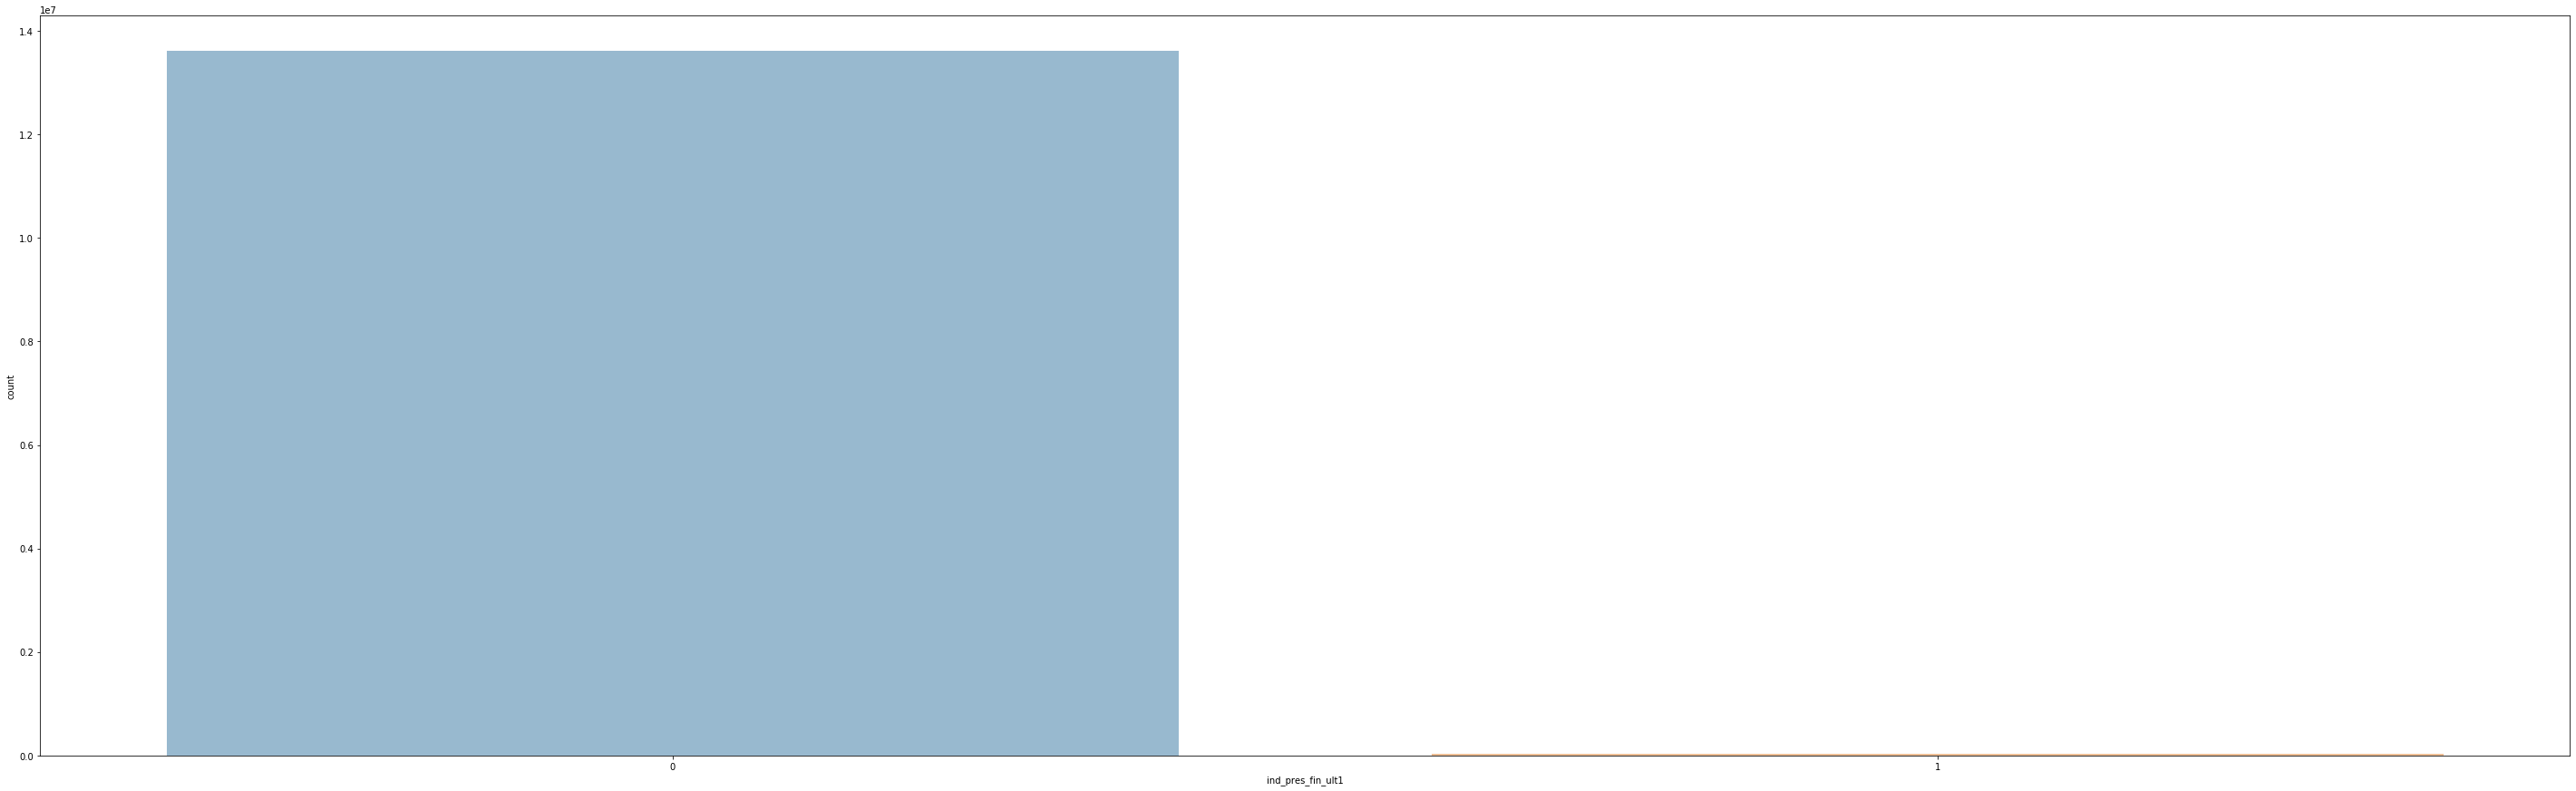

--------------------------------------------------
col:  ind_reca_fin_ult1


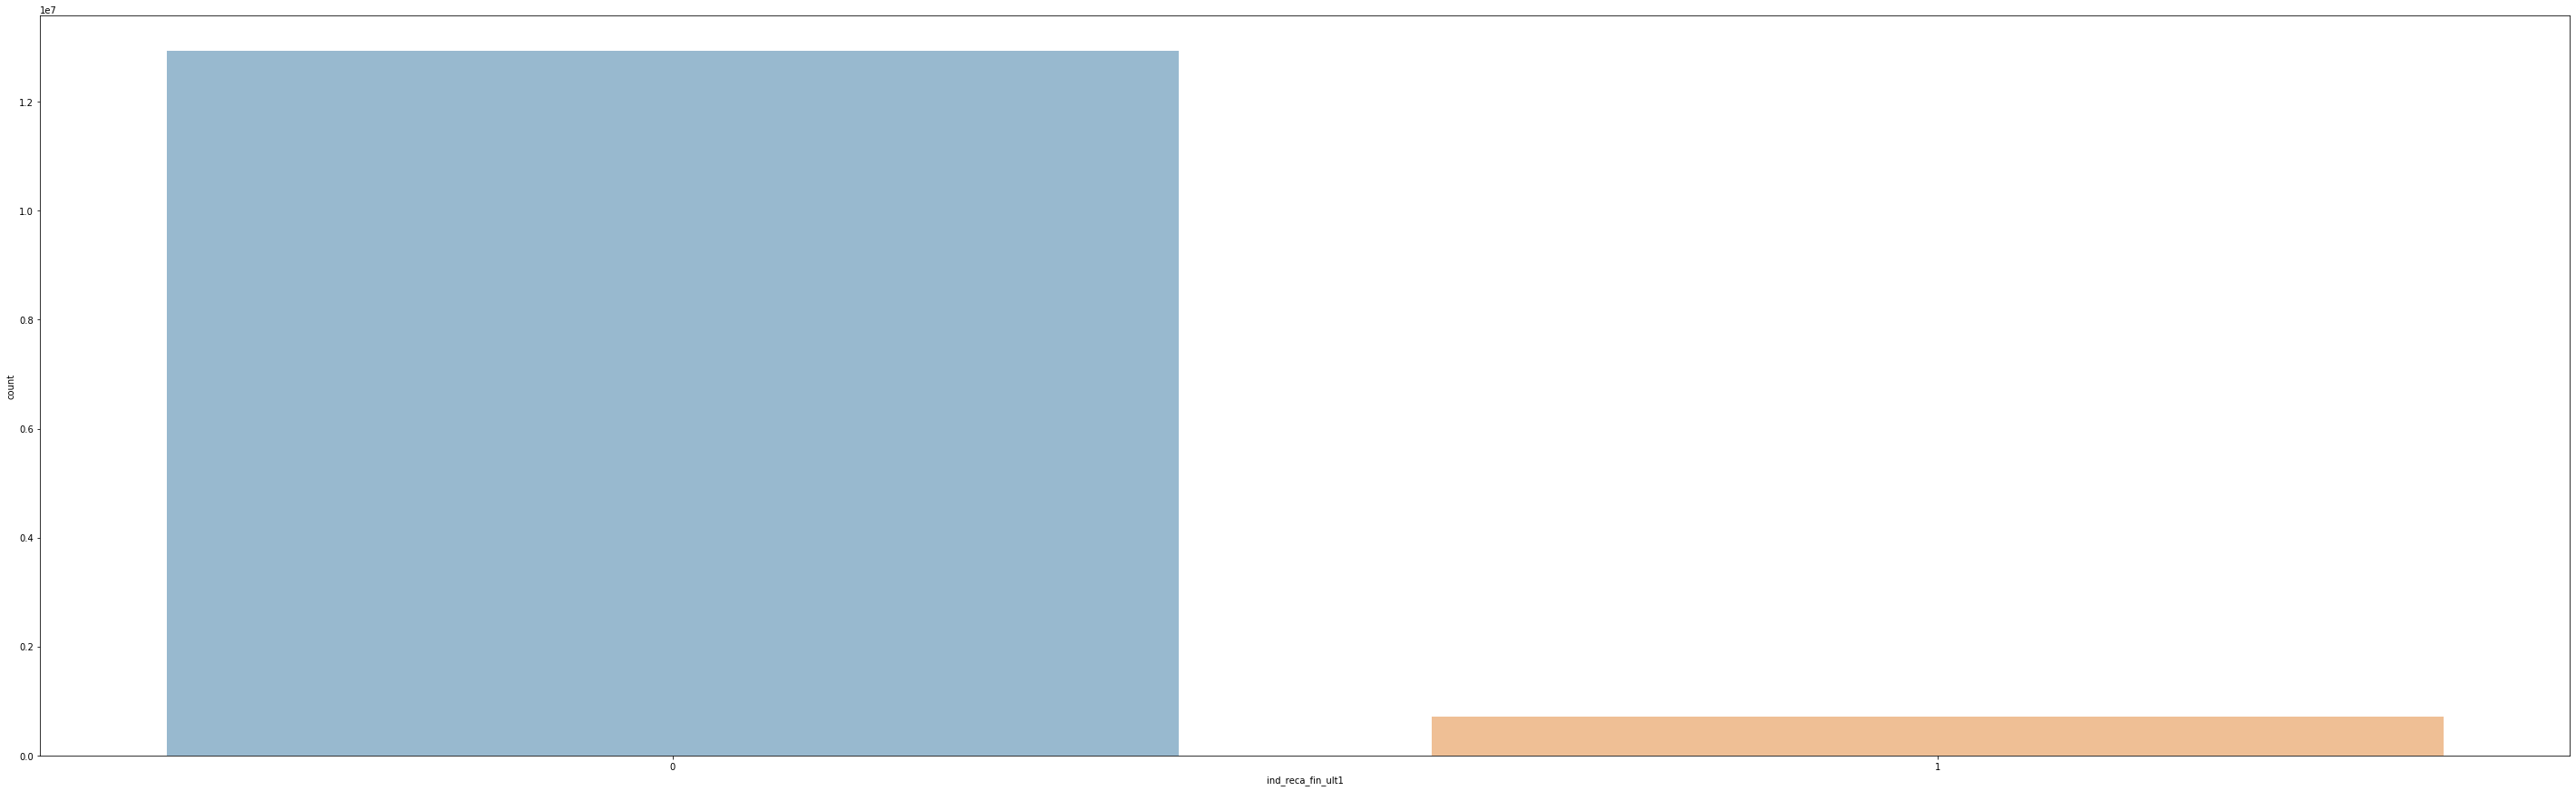

--------------------------------------------------
col:  ind_tjcr_fin_ult1


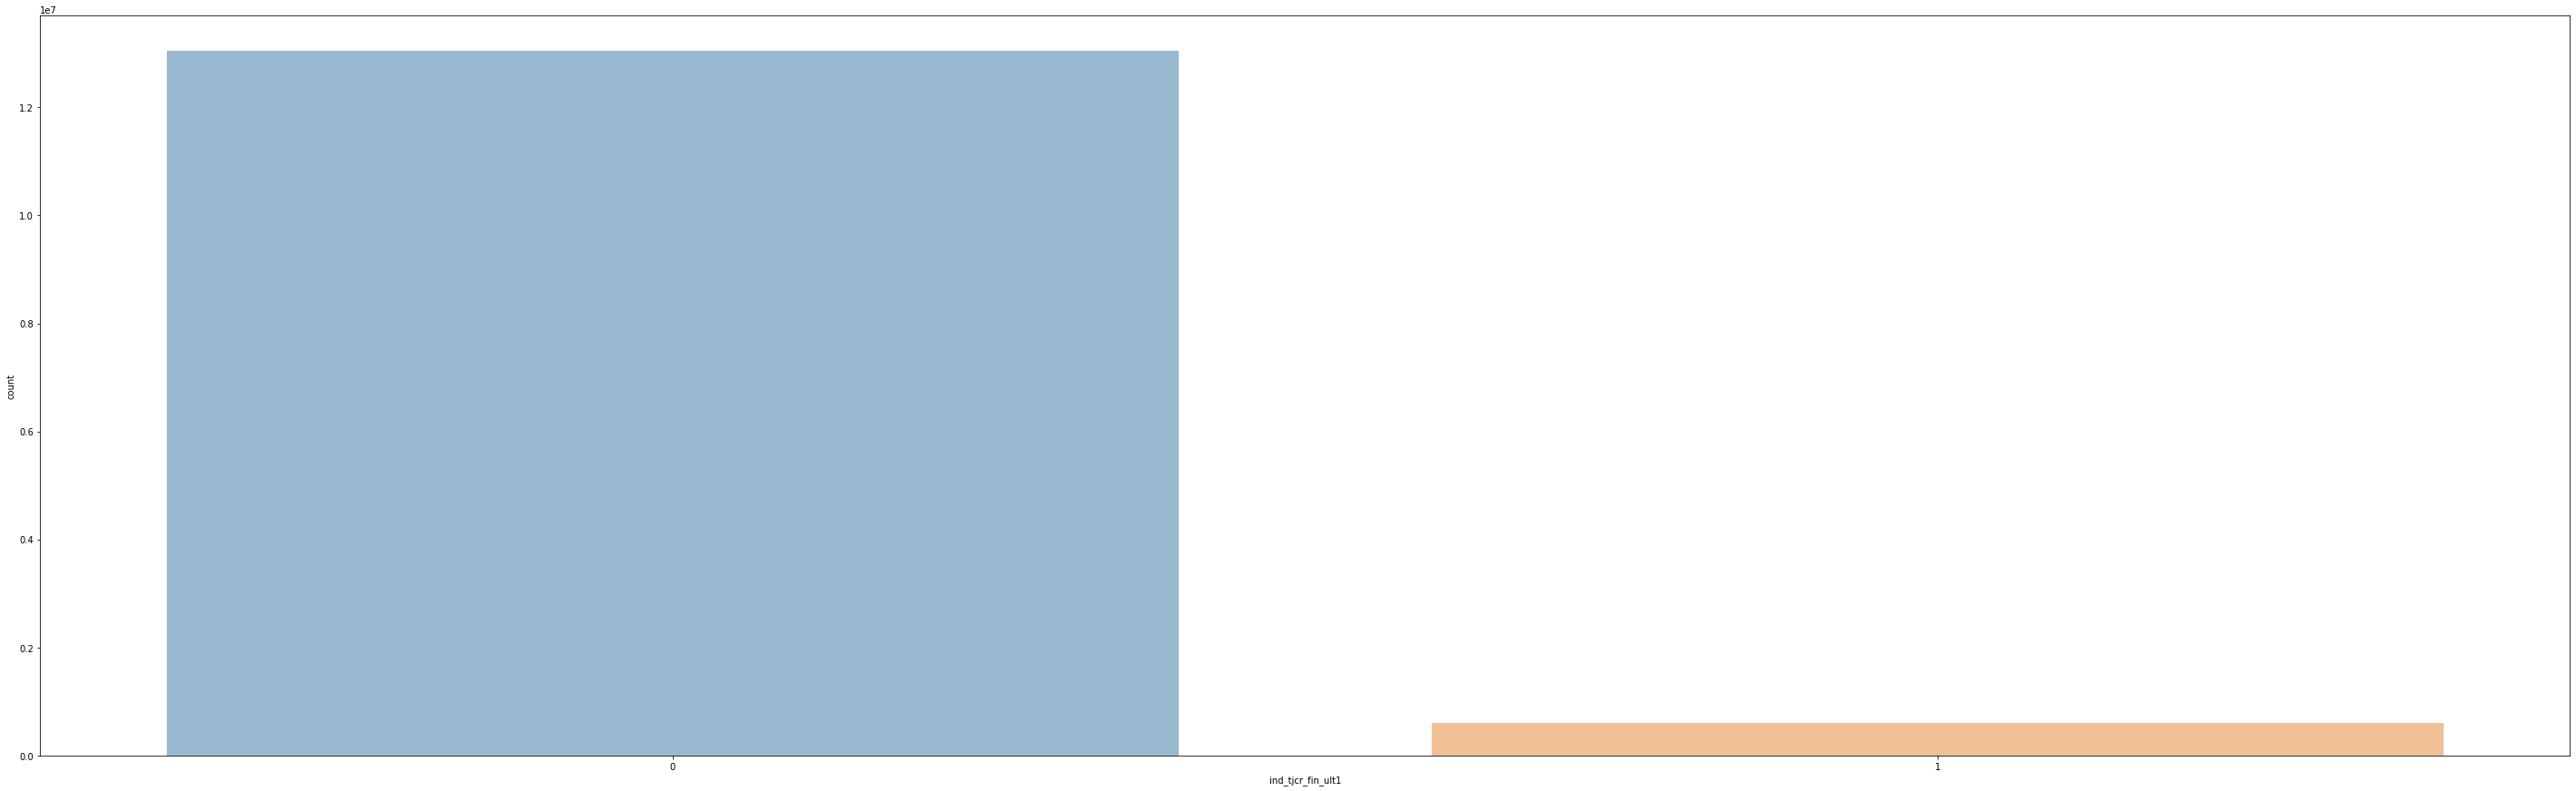

--------------------------------------------------
col:  ind_valo_fin_ult1


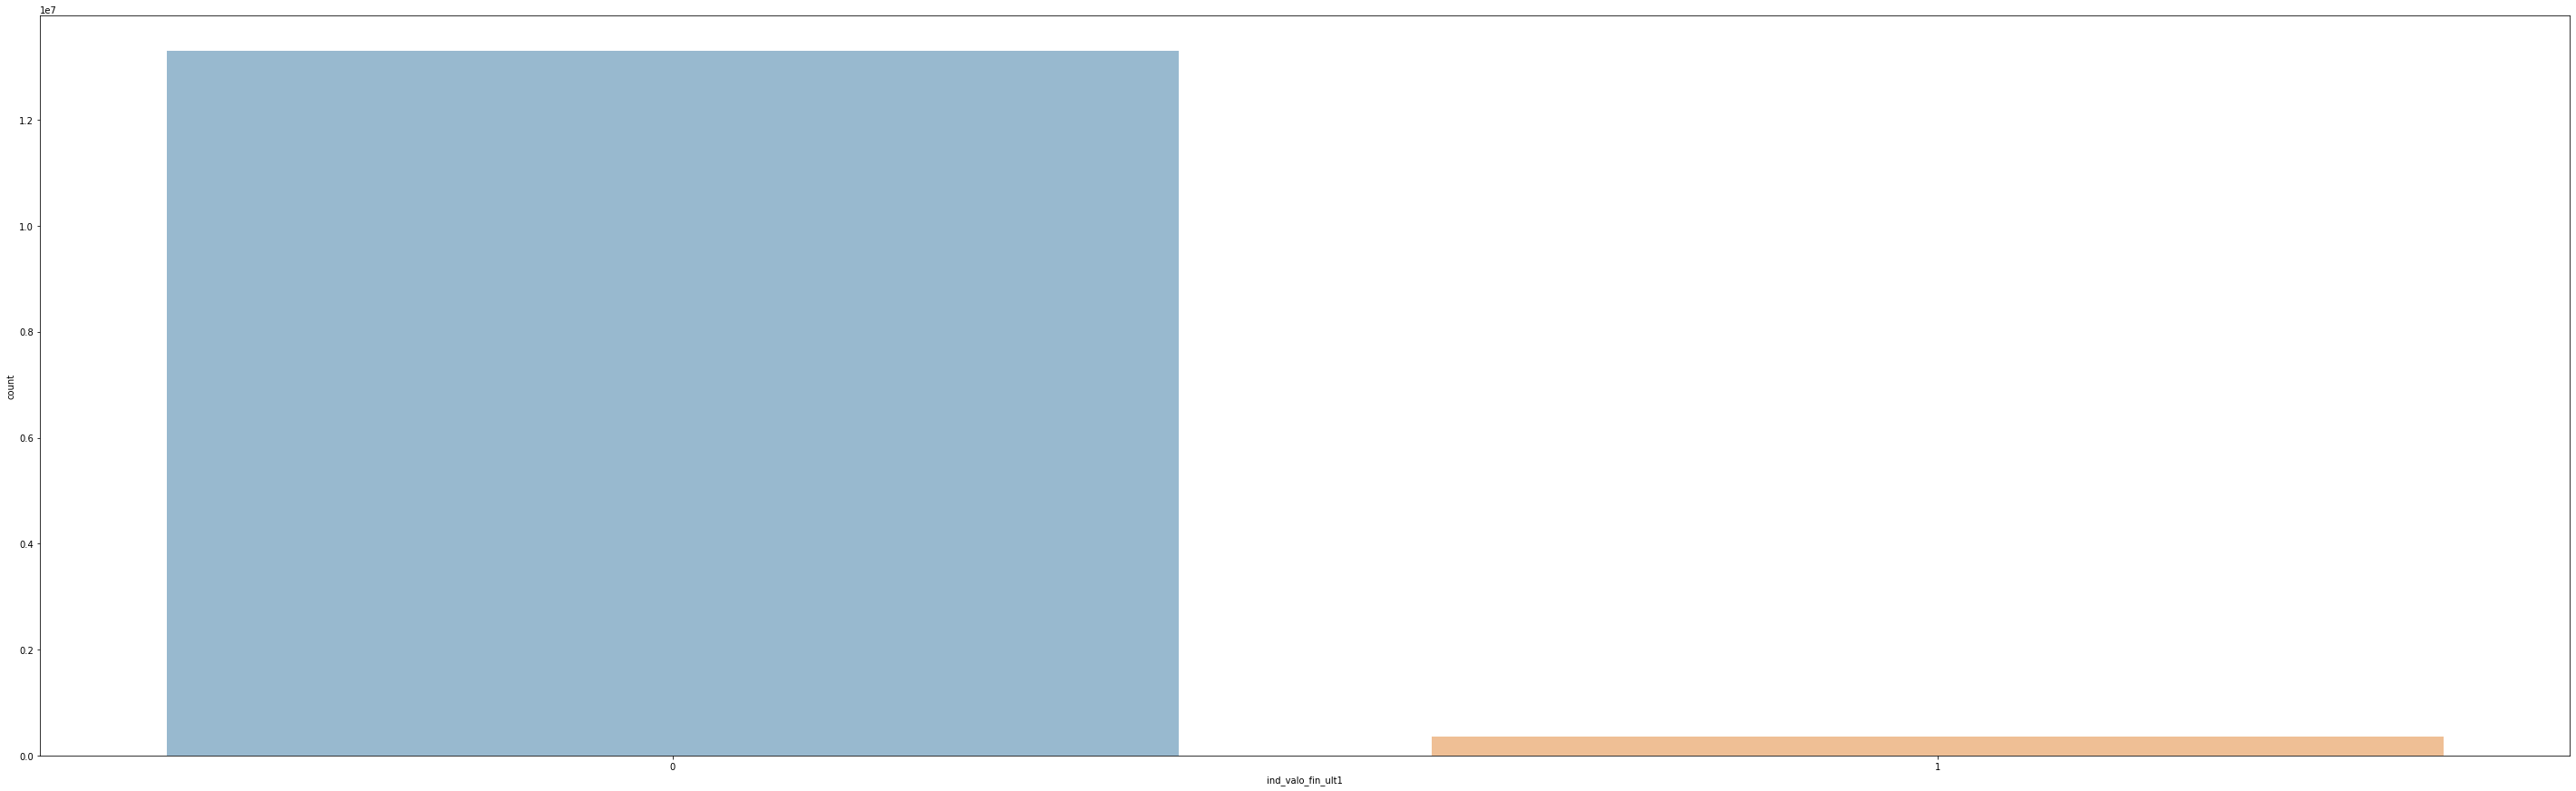

--------------------------------------------------
col:  ind_viv_fin_ult1


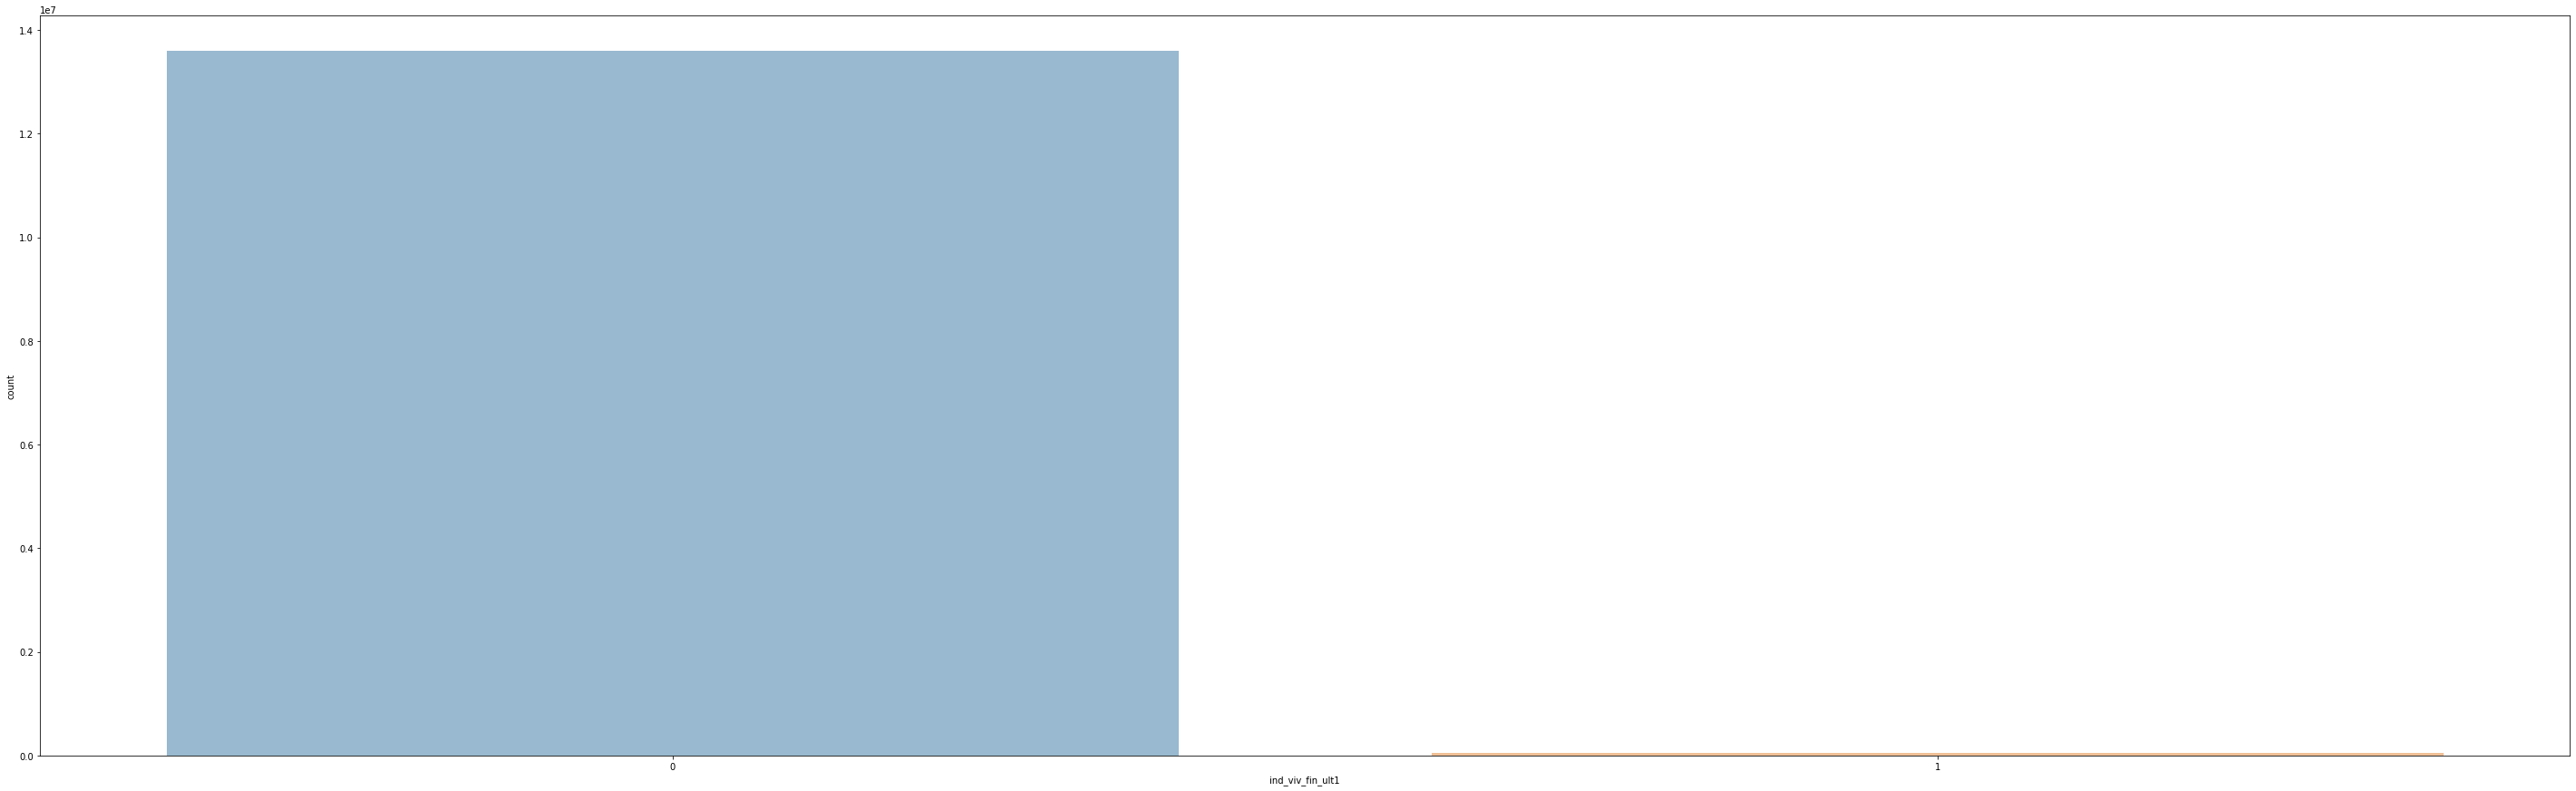

--------------------------------------------------
col:  ind_nomina_ult1


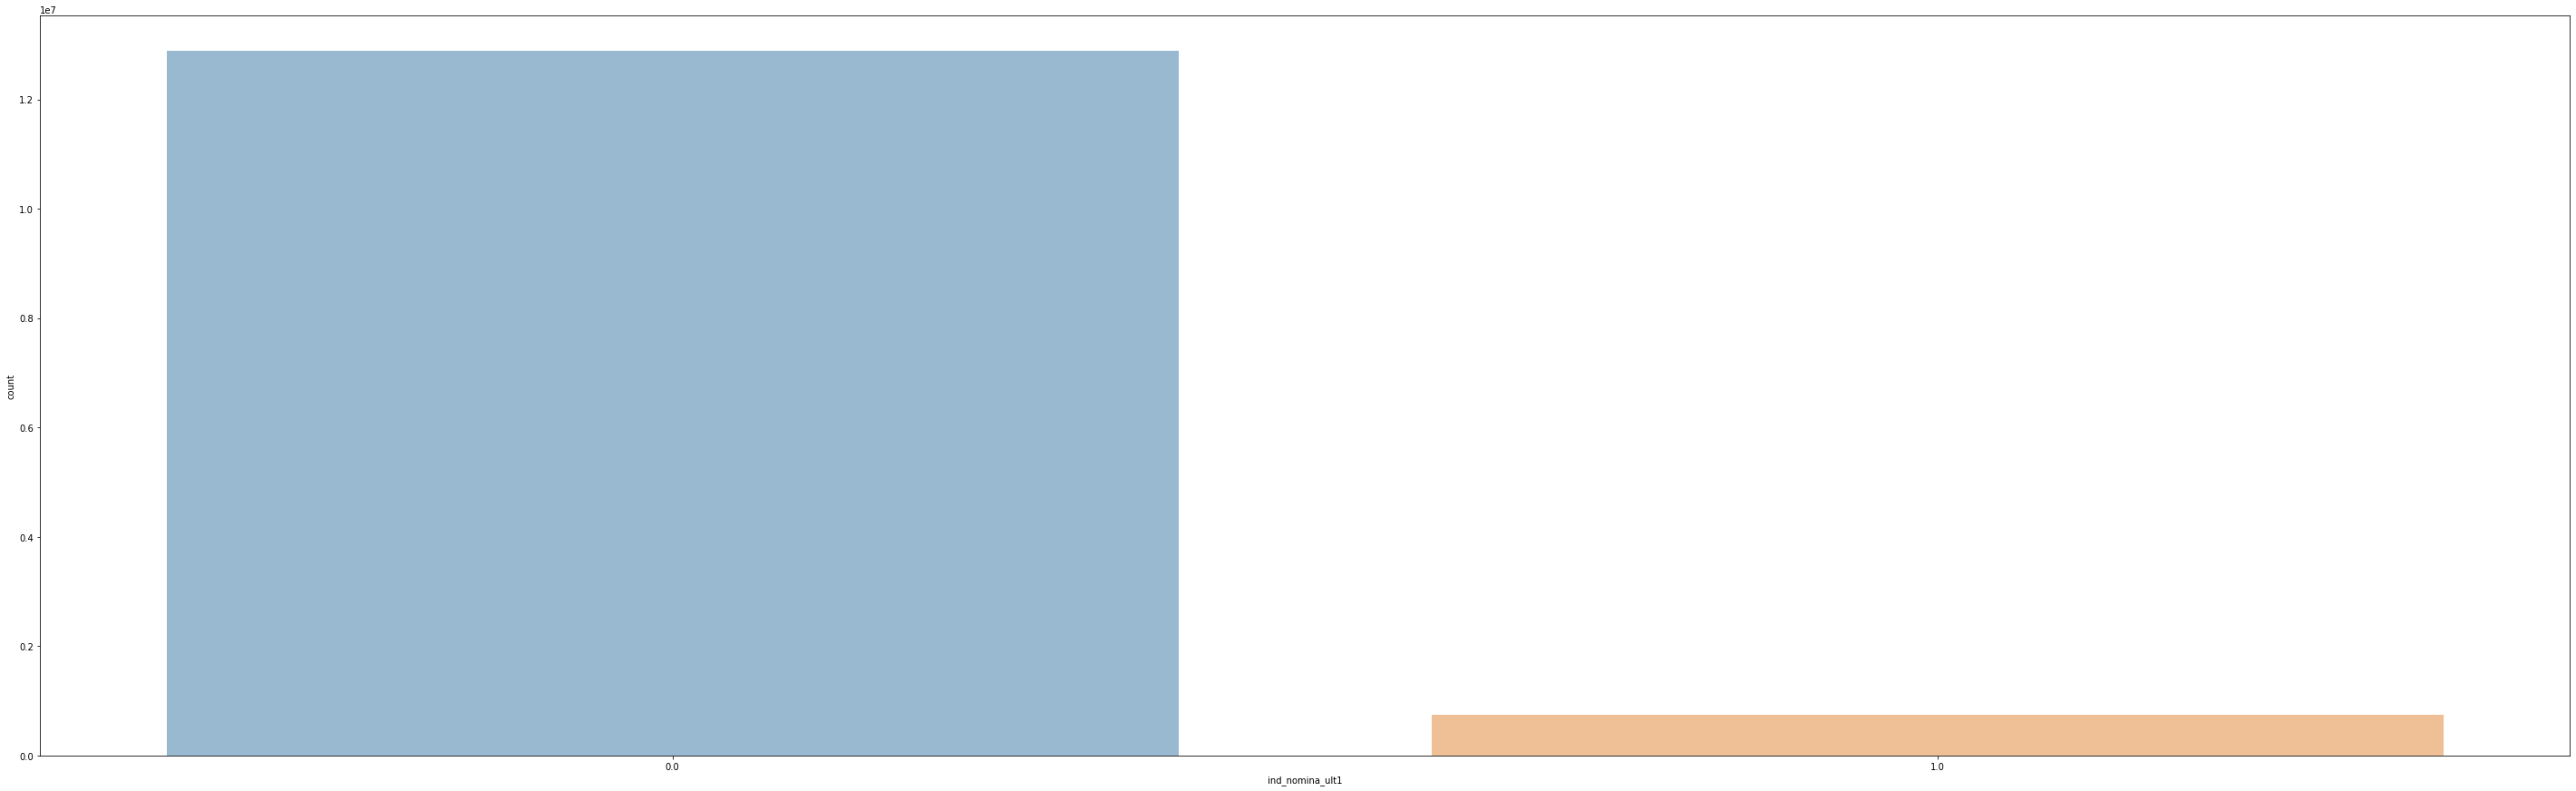

--------------------------------------------------
col:  ind_nom_pens_ult1


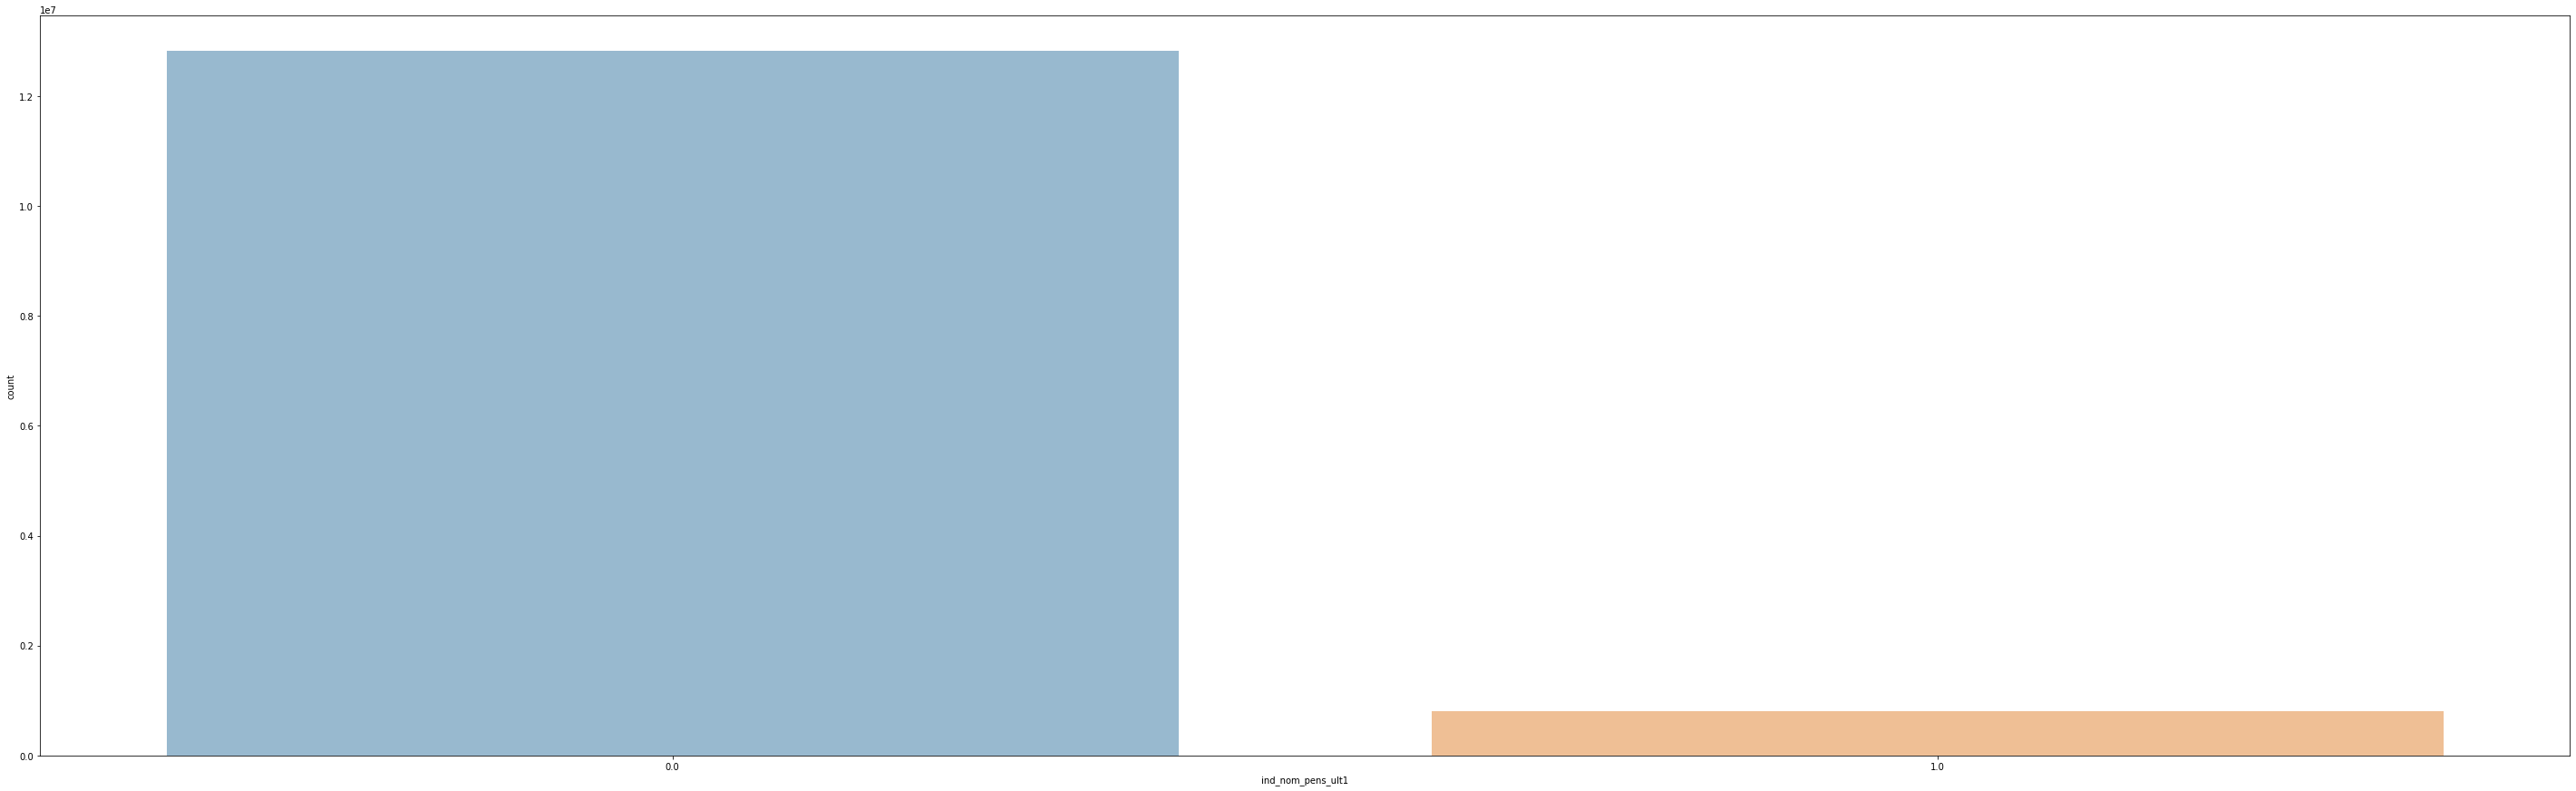

--------------------------------------------------
col:  ind_recibo_ult1


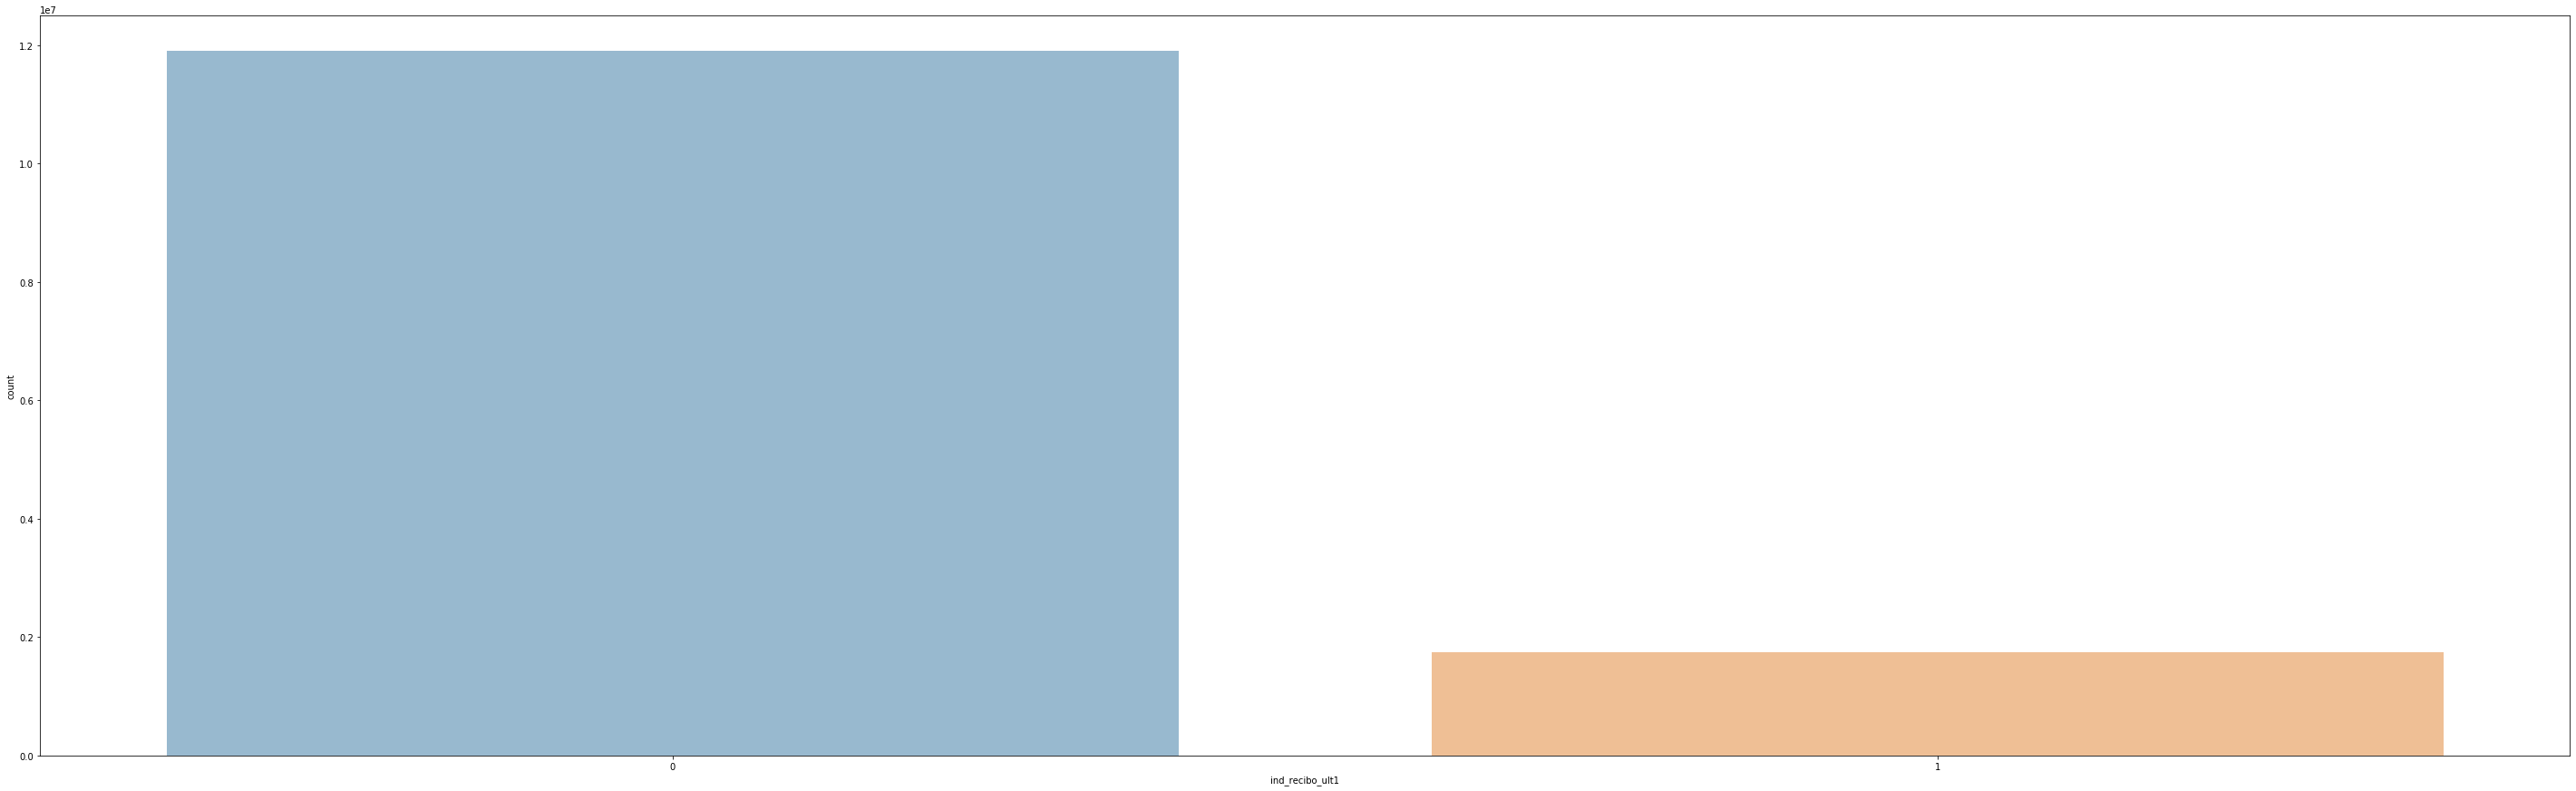

In [0]:
skip_cols = ['ncodpers', 'renta']
for col in trn.columns: 
  # 시간이 많이걸리는 변수 skip
  if col in skip_cols:
    continue

# 보기편하게  영역구분과 변수명을 출력한다.
  print('-' *50)
  print('col: ',col)

    #그래프 크기를 (figsize)) 설정.
  f, ax = plt.subplots(figsize = (50,15))
    #seaborn을 사용한 막대 그래프를 생성한다.
  sns.countplot(x = col, data = trn ,alpha = 0.5)
     #show() 함수를 통해 시각화 한다 . 
  plt.show()

#**월별 금융 제품 보유 데이터를 누적 막대 그래프로 시각화**

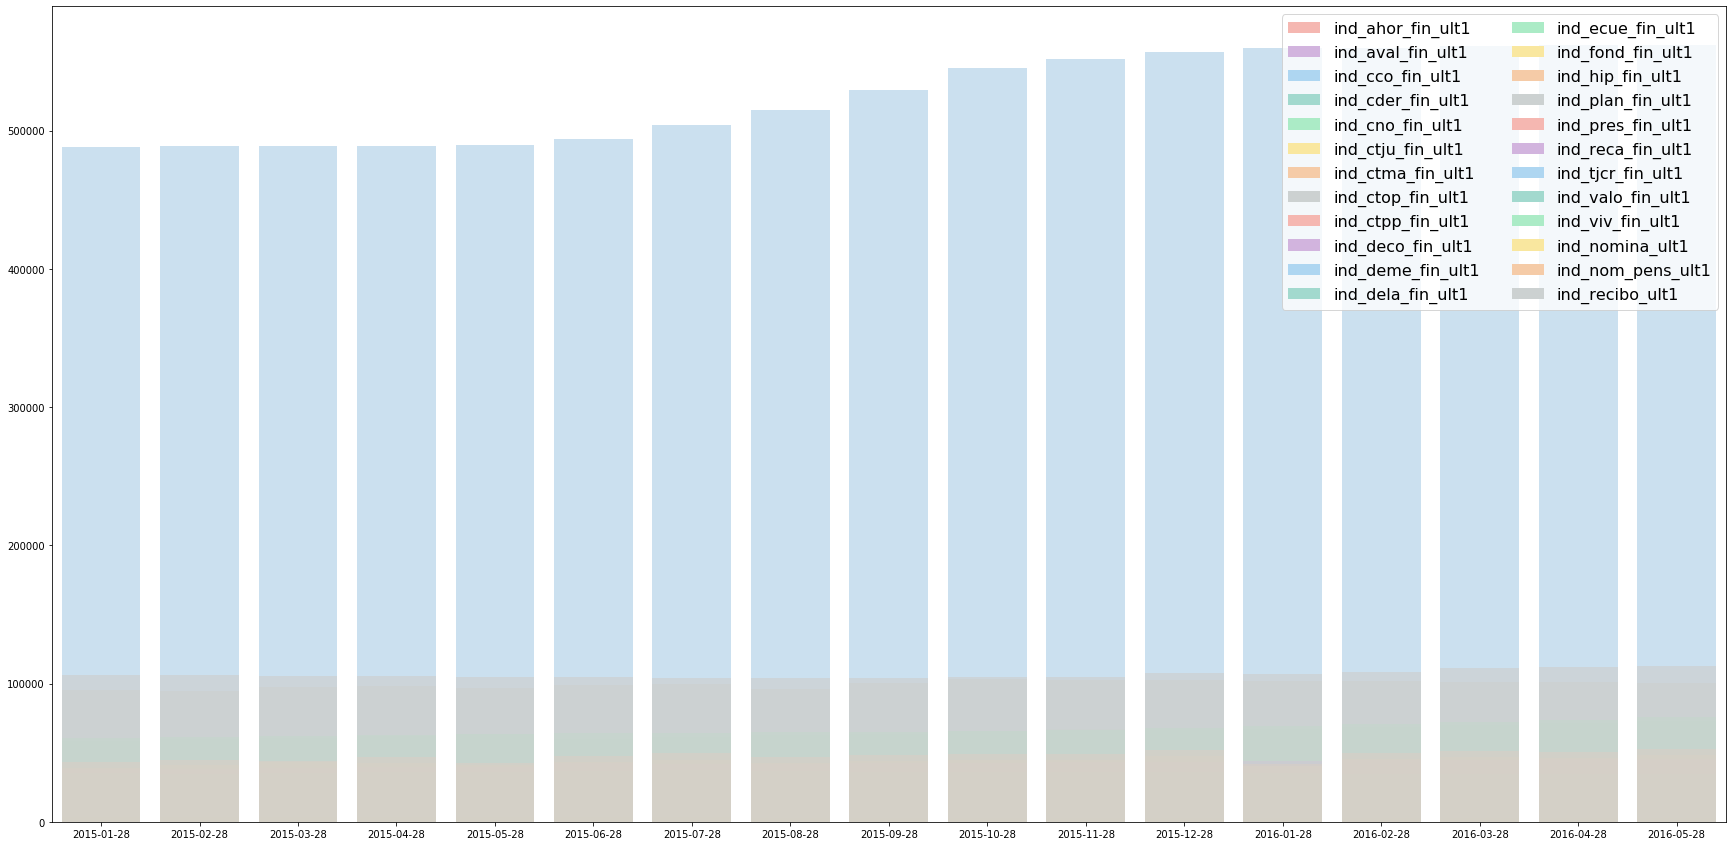

In [0]:
months = trn['fecha_dato'].unique().tolist()
# 제품 변수  24개를 추출한다.
label_cols = trn.columns[24:].tolist()


label_over_time = []
for i in  range(len(label_cols)):
  #매월, 각 제품의 총합을 groupby(..). agg ('sum')으로 계산하여,  label_sum에 저장한다.
  label_sum = trn.groupby(['fecha_dato'])[label_cols[i]].agg('sum')
  label_over_time.append(label_sum.tolist())

label_sum_over_time = []
for i in range(len(label_cols)):  
  #누적 막대 그래프를 시각화하기 위하여, n번째 제품의 총합을 1~n 번째 제품의 총합으로 만든다 .  
  label_sum_over_time.append(np.asarray(label_over_time[i:]).
  sum(axis=0))

# 시각화를 위하여 색깔을 지정한다.
color_list = ['#F5B7B1','#D2B4DE','#AED6F1','#A2D9CE','#ABEBC6','#F9E79F','#F5CBA7','#CCD1D1']

#그림 크기를 사전에 정의한다.
f, ax = plt.subplots(figsize = (30,15))
for i in range(len(label_cols)):
  #24개 제품에 대하여 Histogram을 그린다.
  #x축에는 월데이터, y축에는 누적총합, 색깔은 8개를 번갈아 가며 사용하며, 그림의 
  #alpha값은 0.7로 지정한다.
  sns.barplot(x =months, y = label_over_time[i], color = color_list[i%8], alpha = 0.7)

#우측 상단에  legend르를 추가 한다. 
plt.legend([plt.Rectangle((0,0),1,1,fc = color_list[i%8], edgecolor = 
'none') for i in range(len(label_cols))], label_cols, loc = 1 , ncol = 2, 
prop = {'size':16}) 

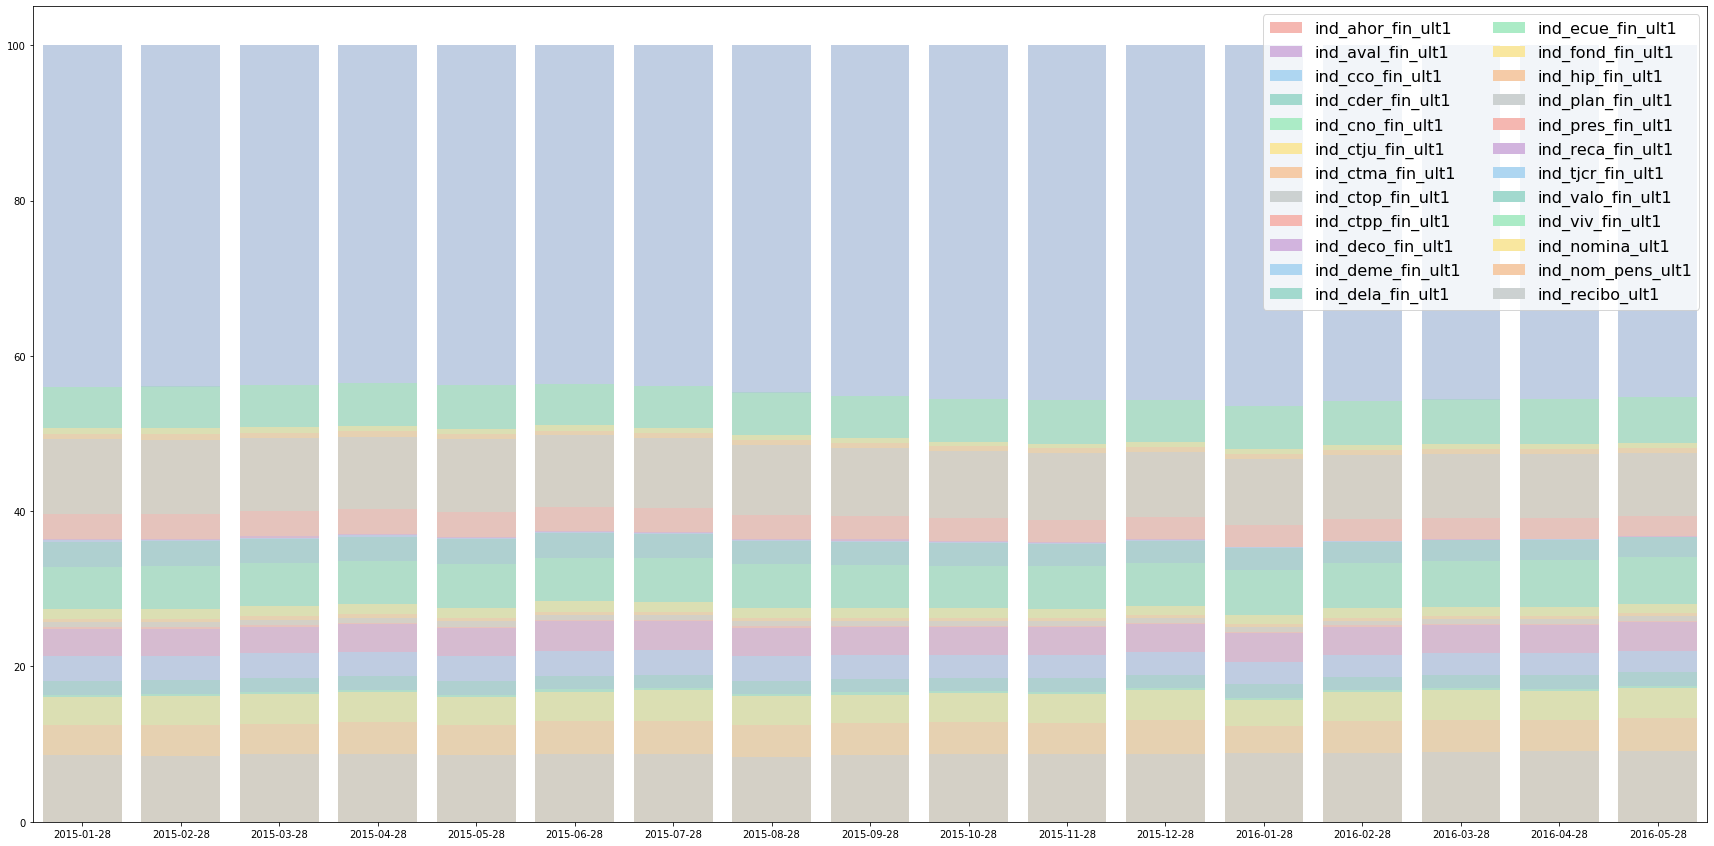

In [0]:
#월별 상대값으로 시각화하여 시각적으로 보기 쉽게 표현한다.

#label_sum_over_time의 값을 퍼센트 단위로 변환한다. 월마다 최댓값으로 나누고 100을 곱해준다.

label_sum_percent = (label_sum_over_time/(1.*np.asarray(label_sum_over_time).max(axis = 0))) * 100

#앞선 코드와 동일한 , 시각화 코드 


#그림 크기를 사전에 정의한다.
f, ax = plt.subplots(figsize = (30,15))
for i in range(len(label_cols)):
  #24개 제품에 대하여 Histogram을 그린다.
  #x축에는 월데이터, y축에는 누적총합, 색깔은 8개를 번갈아 가며 사용하며, 그림의 
  #alpha값은 0.7로 지정한다.
  sns.barplot(x =months, y = label_sum_percent[i], color = color_list[i%8], alpha = 0.7)

#우측 상단에  legend르를 추가 한다. 
plt.legend([plt.Rectangle((0,0),1,1,fc = color_list[i%8], edgecolor = 
'none') for i in range(len(label_cols))], label_cols, loc = 1 , ncol = 2, 
prop = {'size':16}) 

In [0]:
trn=pd.read_csv(path+'train_ver2.csv')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (5,8,11,15) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [0]:
#24개 금융제품에 대한 '신규구매' 데이터 생성하기 

In [0]:

# 제품 변수를 prods에 list 형태로 저장한다
prods = trn.columns[24:].tolist()

In [0]:


# 날짜를 숫자로 변환하는 함수이다. 2015-01-28=1 2016-06-28=18
def date_to_int(self):
  Y,M,D = [int() for a in str.strip(self).split("-")]
  int_date = (int(Y) - 2015)* 12 + int(M)
  return int_date


# 날짜를 숫자로 변환하여 int_date에 저장
trn['int_date'] = trn['fecha_dato'].map(date_to_int). astype(np.int8)

In [0]:
 


#데이터를 복사하고, int_date 날짜에 1을더해 lag를 생성. 변수명에 _prev를 추가 .
trn_lag = trn.copy()
trn_lag['int_date'] += 1
trn_lag.columns = [col + '_prev' if col not in['ncodpers', 'int_date']
else col for col in trn.columns] 

#원본 데이터와 lag데이터를 ncodper와 int_date 기준으로 합친다. lag 데이터의 int_date는
# 1 밀려있기때문에, 저번 달의 제품정보가 삽입된다.
df_trn = trn.merge(trn_lag, on = ['ncodpers', 'int_date'], how = 'left')

#메모리 효율을 위해 불필요한 변수를 메모리에서 제거 한다

del trn, trn_lag

#저번 달의 제품 정보가 존재하지 않을 경우를 대비하여 0으로 대체한다.
for prod in prods:
  prev = prod + '_prev'
  df_trn[prev].fillna(0, inplace =True)


#원본 데이터의 제품 보유 여부 - lag데이터에서의  제품 보유 여부를 비교하여 신규 구매 변수padd를 구한다 .
for prod in prods:
  padd = prod + '_add'
  prev = prod + '_prev'
  df_trn[padd] = ((df_trn[padd] == 1) & (df_trn[prev] == 0)).astype(np.int8)


# 신규 구매 변수만을 추출하여 labels에 저장한다.

add_cols = [prod + '_add' for prod in prods]
labels - df_trn[add_cols].copy()
labels.columns  = prods
labels.to_csv(path+'labels.csv', index  =   False)